In [2]:
import torch
from torch import nn
import torch.utils.data as Data
import torch.optim as optim
import numpy as np
from os.path import join as PJ
import matplotlib.pyplot as plt

In [3]:
torch.cuda.set_device(0)
print(torch.cuda.current_device())

0


In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image,ImageOps

In [5]:
import tensorflow as tf

In [7]:
def LoadFiles(mode="train"):
    if mode == "train":
        with open(TrainFile, 'r') as trainf:
            image_info = trainf.readlines()
            image_info = [path.strip().split() for path in image_info]
            image_info = np.asarray(image_info)

            # Split to image path and label
            image_paths = image_info[:, 0]
            label_ids = image_info[:, 1].astype(int)

#             labels = tf.one_hot(label_ids, num_class, dtype=tf.int32)
            print("in Load : ", label_ids.shape)
            return image_paths, label_ids
    else:
        with open(TestFile, 'r') as testf:
            image_info = testf.readlines()
            image_info = [path.strip().split() for path in image_info]
            image_info = np.asarray(image_info)

            # Split to image path and label
            image_paths = image_info[:, 0]
            label_ids = image_info[:, 1].astype(int)
#             labels = tf.one_hot(label_ids, num_class, dtype=tf.int32)
            return image_paths, label_ids

In [8]:
import cv2
class TermiteDataset(Dataset):
    def __init__(self, data_file, transform):
        with open(data_file, 'r') as f:
            image_info = f.readlines()
        image_info = [path.strip().split() for path in image_info]
        image_info = np.asarray(image_info)

        # Split to image path and label
        self.image_paths = image_info[:, 0]
        self.label_ids = image_info[:, 1].astype(int)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
#         print(idx, self.label_ids.shape, self.label_ids[idx])
        label = self.label_ids[idx]
        image_path = self.image_paths[idx]
        original_image = Image.open(image_path).convert('RGB')
        
#         print(original_image.size)
        
        if original_image.size[0] > 1000:
            original_image = original_image.resize((1000, original_image.size[1]*1000//original_image.size[0]))
        elif original_image.size[1] > 1000:
            original_image = original_image.resize((original_image.size[0]*1000//original_image.size[1], 1000))
#         print(original_image.shape)
        left = 500-original_image.size[0]//2
        right = 500-original_image.size[0]//2
        top = 500-original_image.size[1]//2
        bottom = 500-original_image.size[1]//2
        
        if left + right + original_image.size[0] != 1000:
            right = 1000 - left - original_image.size[0]
        if top + bottom + original_image.size[1] != 1000:
            top = 1000 - bottom - original_image.size[1]
        
#         original_image= cv2.copyMakeBorder(original_image,left,right,top,bottom,cv2.BORDER_CONSTANT,value=(0, 0, 0))
        original_image = ImageOps.expand(original_image, border=(left,top,right,bottom), fill=0)##left,top,right,bottom
        original_image = original_image.resize((130,130))
        transform1 = transforms.Compose([transforms.ToTensor()])
        original_image = transform1(original_image)
#         print(original_image.shape)
        
        
#         original_image = self.transform(original_image)
#         original_image.permute(2,0,1)
#         print(original_image.shape, answer.shape)
        return label, original_image, self.image_paths[idx]

def transform_set(train, new_size=None, pad=None):
    """
    train: True or False
    new_size: int or tuple
    
    """
#     transform_list = [transforms.ToTensor(),
#                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
    transform_list = [transforms.ToTensor()]
    # replace centercrop to padding
#     transform_list = [transforms.CenterCrop((crop_h, crop_w))] + transform_list if crop else transform_list
#     transform_list = [transforms.Resize(new_size)] + transform_list if new_size is not None else transform_list

#     transform_list = [transforms.RandomHorizontalFlip()] + transform_list if train else transform_list
    transform = transforms.Compose(transform_list)
    return transform

In [9]:
def CheckFile(filename):
    with open(filename, 'r') as f:
            image_info = f.readlines()
    image_info = [path.strip().split() for path in image_info]
    image_info = np.asarray(image_info)
    counts = {"台灣土白蟻兵蟻" : 0,
             "台灣土白蟻工蟻" : 0,
             "台灣家白蟻兵蟻" : 0,
             "台灣家白蟻工蟻" : 0,
             "截頭堆沙兵蟻" : 0,
             "截頭堆沙工蟻" : 0,
             "黃肢散工蟻" : 0,
             "黃肢散兵蟻" : 0,}
        
    Locations = {"L1" : 0,
             "L2" : 0,
             "L3" : 0}
    for line in image_info:
        path = line[0]
        if "L1" in path:
            Locations["L1"] += 1
        if "L2" in path:
            Locations["L2"] += 1
        if "L3" in path:
            Locations["L3"] += 1
        if "台灣土白蟻兵蟻" in path:
            counts["台灣土白蟻兵蟻"] += 1
        if "台灣土白蟻工蟻" in path:
            counts["台灣土白蟻工蟻"] += 1
        if "台灣家白蟻兵蟻" in path:
            counts["台灣家白蟻兵蟻"] += 1
        if "台灣家白蟻工蟻" in path:
            counts["台灣家白蟻工蟻"] += 1
        if "截頭堆沙兵蟻" in path:
            counts["截頭堆沙兵蟻"] += 1
        if "截頭堆沙工蟻" in path:
            counts["截頭堆沙工蟻"] += 1
        if "黃肢散兵蟻" in path:
            counts["黃肢散兵蟻"] += 1
        if "黃肢散工蟻" in path:
            counts["黃肢散工蟻"] += 1
    print(Locations, counts)

In [ ]:
BATCH_SIZE = 64
EPOCH = 100
LearningRate = 0.0001
Momentum = 0.9
TrainFile = "/home/ytliu/Termite-Bonnie/PAPER_termite/BENCHMARK-LARGE_Ind_trainfile_worker_1.txt"
ValFile = "/home/ytliu/Termite-Bonnie/PAPER_termite/BENCHMARK-LARGE_Ind_valfile_worker_1.txt"
TestFile = "/home/ytliu/Termite-Bonnie/PAPER_termite/BENCHMARK-LARGE_Ind_testfile_worker_1.txt"
# classes = ["O. formosanus Army","O. formosanus Worker", "C. formosanus Army","C. formosanus Worker", "C. domesticus Army","C. domesticus Worker", "R. flaviceps Worker", "R. flaviceps Army"]
classes = ["O.f Worker","C.f Worker","C.d Worker", "R.f Worker"]
model_directory = "/home/ytliu/Termite-Bonnie/PAPER_termite/*BENCH_test_time2/"
test_directory = "/home/ytliu/Termite-Bonnie/PAPER_termite/*BENCH_test_time2/"


In [ ]:
print("TrainFile : ", TrainFile)
print("ValidationFile : ", ValFile)
print("TestFile : ", TestFile)
CheckFile(TrainFile)
CheckFile(ValFile)
CheckFile(TestFile)

TrainFile :  /home/ytliu/Termite-Bonnie/PAPER_termite/BENCHMARK-LARGE_Ind_trainfile_worker_1.txt
ValidationFile :  /home/ytliu/Termite-Bonnie/PAPER_termite/BENCHMARK-LARGE_Ind_valfile_worker_1.txt
TestFile :  /home/ytliu/Termite-Bonnie/PAPER_termite/BENCHMARK-LARGE_Ind_testfile_worker_1_CFselected.txt
{'L1': 0, 'L2': 3200, 'L3': 3200} {'台灣土白蟻兵蟻': 0, '台灣土白蟻工蟻': 1600, '台灣家白蟻兵蟻': 0, '台灣家白蟻工蟻': 1600, '截頭堆沙兵蟻': 0, '截頭堆沙工蟻': 1600, '黃肢散工蟻': 1600, '黃肢散兵蟻': 0}
{'L1': 0, 'L2': 800, 'L3': 800} {'台灣土白蟻兵蟻': 0, '台灣土白蟻工蟻': 400, '台灣家白蟻兵蟻': 0, '台灣家白蟻工蟻': 400, '截頭堆沙兵蟻': 0, '截頭堆沙工蟻': 400, '黃肢散工蟻': 400, '黃肢散兵蟻': 0}
{'L1': 4000, 'L2': 0, 'L3': 0} {'台灣土白蟻兵蟻': 0, '台灣土白蟻工蟻': 1000, '台灣家白蟻兵蟻': 0, '台灣家白蟻工蟻': 1000, '截頭堆沙兵蟻': 0, '截頭堆沙工蟻': 1000, '黃肢散工蟻': 1000, '黃肢散兵蟻': 0}


In [ ]:
import torchvision.models as models
import os
# from MobileNetV2 import MobileNetV2
print(torch.__version__)
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
# mobilenet =  MobileNetV2(n_class=len(classes)).cuda()
mobilenet =  nn.Sequential(models.mobilenet_v2(pretrained=True), nn.Linear(1000, len(classes))).cuda()

1.3.0
0


In [ ]:
model = mobilenet
# model = MobileNet(len(classes))
# model.to(cuda)
# model = model.cuda()
model = model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LearningRate, momentum=Momentum)

In [ ]:
transform = transform_set(train=True)
trainset = TermiteDataset(TrainFile, transform)
trainloader = Data.DataLoader(
    dataset=trainset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=0,              # 多线程来读数据
)

In [ ]:
transform2 = transform_set(train=False)
valset = TermiteDataset(ValFile, transform2)
valloader = Data.DataLoader(
    dataset=valset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=0,              # 多线程来读数据
)

In [ ]:
# for labels, images in loader:
#     print(labels.shape)
#     print(images.shape)
#     ssssss

# TRAIN
### 
### validation

Train
[1, 00020] loss: 23.010 acc: 0.537
[1, 00040] loss: 30.994 acc: 0.694
[1, 00060] loss: 35.246 acc: 0.772
[1, 00080] loss: 38.827 acc: 0.814
[1, 00100] loss: 41.859 acc: 0.842
[0.841875]
[41.85879758000374]


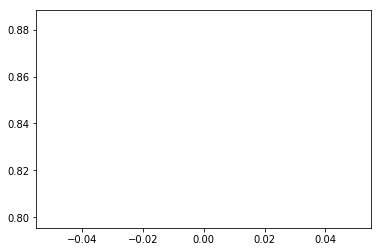

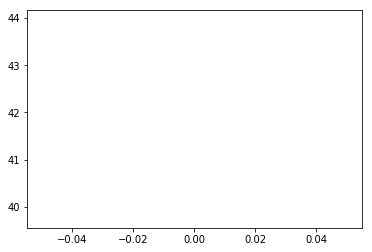

Validation
[0.9325]
[4.690167769789696]


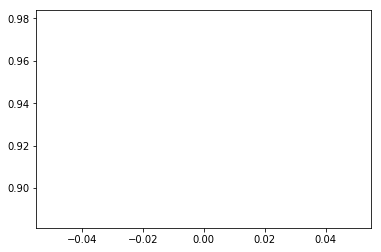

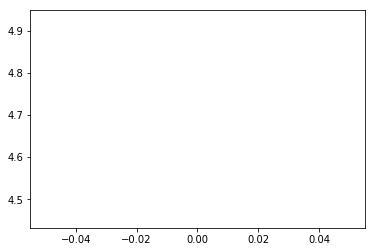


[1] accuracy: 0.932 loss: 4.690

66.0657730102539
Train
[2, 00020] loss: 2.396 acc: 0.960
[2, 00040] loss: 4.307 acc: 0.964
[2, 00060] loss: 6.033 acc: 0.969
[2, 00080] loss: 7.631 acc: 0.971
[2, 00100] loss: 8.891 acc: 0.973
[0.841875, 0.97296875]
[41.85879758000374, 8.890650175511837]


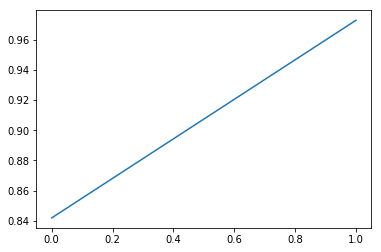

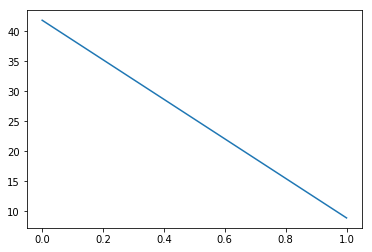

Validation
[0.9325, 0.96]
[4.690167769789696, 2.9906101524829865]


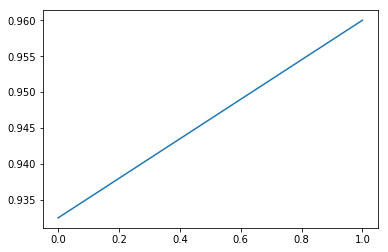

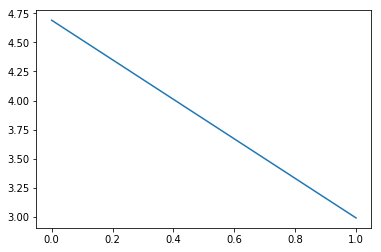


[2] accuracy: 0.960 loss: 2.991

132.15170240402222
Train
[3, 00020] loss: 1.045 acc: 0.988
[3, 00040] loss: 2.016 acc: 0.988
[3, 00060] loss: 2.924 acc: 0.988
[3, 00080] loss: 3.896 acc: 0.988
[3, 00100] loss: 4.827 acc: 0.988
[0.841875, 0.97296875, 0.9875]
[41.85879758000374, 8.890650175511837, 4.827199118211865]


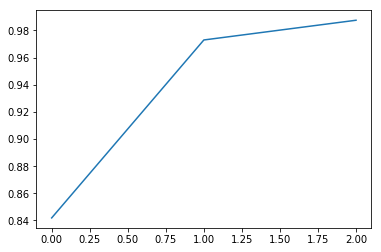

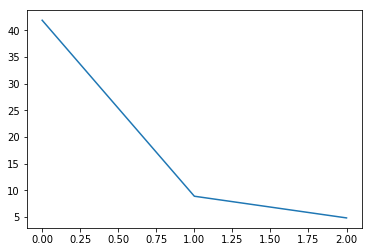

Validation
[0.9325, 0.96, 0.965]
[4.690167769789696, 2.9906101524829865, 2.2936201319098473]


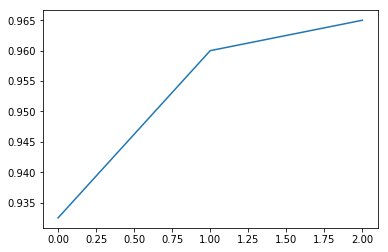

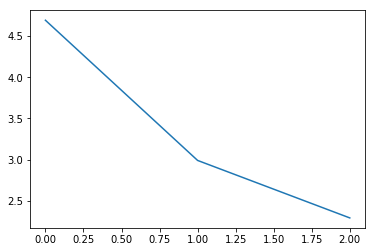


[3] accuracy: 0.965 loss: 2.294

199.11708974838257
Train
[4, 00020] loss: 0.723 acc: 0.990
[4, 00040] loss: 1.424 acc: 0.989
[4, 00060] loss: 2.079 acc: 0.989
[4, 00080] loss: 2.637 acc: 0.990
[4, 00100] loss: 3.362 acc: 0.990
[0.841875, 0.97296875, 0.9875, 0.98953125]
[41.85879758000374, 8.890650175511837, 4.827199118211865, 3.3620466366410255]


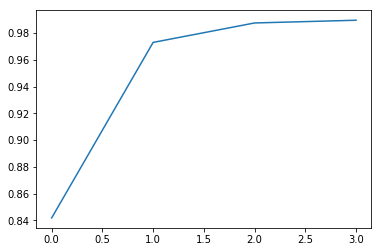

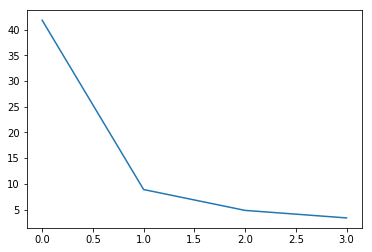

Validation
[0.9325, 0.96, 0.965, 0.9675]
[4.690167769789696, 2.9906101524829865, 2.2936201319098473, 1.9842718616127968]


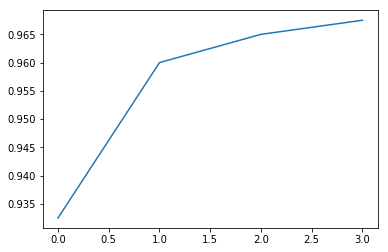

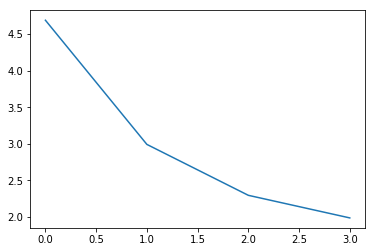


[4] accuracy: 0.968 loss: 1.984

265.49426555633545
Train
[5, 00020] loss: 0.528 acc: 0.992


In [ ]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []
import time
start = time.time()
for epoch in range(EPOCH):
    print("Train")
    total = 0
    correct = 0
    running_loss = 0.0
    for step, (labels, images,_) in enumerate(trainloader):
        optimizer.zero_grad()
#         print("in Train: ", images.shape, labels.shape)
#         images = images.detach()
#         labels = labels.detach()
        images = images.detach().cuda()
        labels = labels.detach().cuda()
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc = correct / total

        if step % 20 == 19:    # print every 2000 mini-batches
            print('[%d, %05d] loss: %.3f acc: %.3f' %
                  (epoch + 1, step + 1, running_loss, acc))

    train_acc.append(acc)
    train_loss.append(running_loss)
    print(train_acc)
    print(train_loss)
    plt.figure()
    plt.plot(range(0,epoch+1), train_acc)
    plt.savefig(model_directory + "train_acc_E%03d.jpg" % (epoch+1), dpi=500)
    plt.show()
    plt.figure()
    plt.plot(range(0,epoch+1), train_loss)
    plt.savefig(model_directory + "train_loss_E%03d.jpg" % (epoch+1), dpi=500)
    plt.show()
    
    # Evaluate validation set
    print("Validation")
    total = 0
    correct = 0
    running_loss = 0.0
    for step, (labels, images,_) in enumerate(valloader):
        optimizer.zero_grad()
        images = images.detach().cuda()
        labels = labels.detach().cuda()
#         images = images.detach()
#         labels = labels.detach()
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        running_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        acc = correct / total
    
    val_acc.append(acc)
    val_loss.append(running_loss)
    print(val_acc)
    print(val_loss)
    plt.figure()
    plt.plot(range(0,epoch+1), val_acc)
    plt.savefig(model_directory + "val_acc_E%03d.jpg" % (epoch+1), dpi=500)
    plt.show()
    plt.figure()
    plt.plot(range(0,epoch+1), val_loss)
    plt.savefig(model_directory + "val_loss_E%03d.jpg" % (epoch+1), dpi=500)
    plt.show()
    
    print('\n[%d] accuracy: %.3f loss: %.3f\n' % (epoch + 1, acc, running_loss))
    running_loss = 0.0
    # Saving model
    model_path = PJ(model_directory, "%03d_weights.pt" % (epoch+1))
    torch.save(model.state_dict(), model_path)
    print(time.time() - start)

In [17]:
resultfile = open(model_directory+"train_results.txt", "a")
resultfile.write("train")
resultfile.write(str(train_acc))
resultfile.write("\n")
resultfile.write(str(train_loss))
resultfile.write("\n")
resultfile.write("validation")
resultfile.write("\n")
resultfile.write(str(val_acc))
resultfile.write("\n")
resultfile.write(str(val_loss))
resultfile.write("\n")
resultfile.close()

# TEST
### evaluate
### test every model
### saliency map

In [25]:
transform = transform_set(train=False)
testset = TermiteDataset(TestFile, transform)
testloader = Data.DataLoader(
    dataset=testset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=0,              # 多线程来读数据
)


[1] accuracy: 0.855 loss: 24.344

[0.85475]
[24.343521431088448]


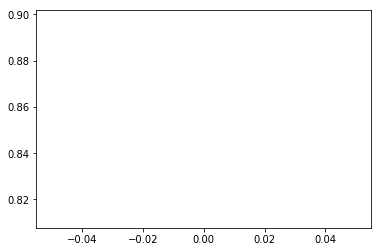

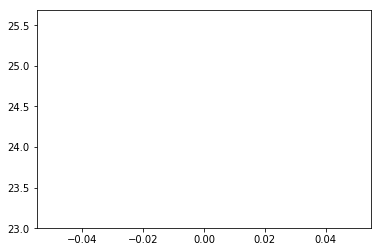

[0, 3, 0, 0, 0, 0, 1, 1, 0, 3, 1, 3, 2, 2, 3, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 3, 3, 0, 0, 3, 0, 2, 3, 0, 1, 0, 1, 1, 2, 3, 0, 3, 0, 3, 2, 0, 3, 3, 1, 0, 1, 2, 3, 2, 3, 0, 0, 3, 1, 1, 2, 3, 3, 1, 3, 1, 1, 3, 3, 0, 3, 3, 3, 0, 0, 3, 1, 0, 0, 1, 0, 3, 3, 3, 0, 3, 0, 3, 1, 0, 1, 1, 3, 3, 1, 0, 1, 0, 1, 0, 3, 1, 0, 3, 3, 1, 0, 3, 3, 2, 3, 1, 0, 2, 1, 1, 3, 1, 1, 0, 3, 2, 1, 0, 3, 3, 2, 3, 1, 0, 0, 1, 3, 3, 3, 3, 0, 0, 3, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1, 2, 1, 3, 3, 0, 1, 3, 0, 1, 0, 1, 1, 2, 1, 1, 1, 3, 3, 0, 1, 0, 1, 2, 3, 0, 1, 1, 0, 1, 1, 0, 0, 0, 3, 0, 3, 1, 0, 1, 3, 0, 3, 0, 0, 0, 3, 3, 3, 0, 3, 1, 3, 2, 0, 1, 3, 0, 3, 1, 3, 1, 0, 3, 3, 3, 0, 3, 0, 3, 1, 0, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 0, 1, 2, 1, 0, 3, 0, 1, 0, 1, 3, 0, 0, 1, 0, 1, 3, 0, 3, 3, 0, 1, 1, 3, 1, 2, 1, 2, 3, 3, 1, 3, 0, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 1, 1, 2, 1, 3, 3, 3, 1, 1, 3, 1, 3, 0, 2, 0, 2, 2, 3, 0, 2, 3, 0, 1, 1, 0, 0, 3, 0, 3, 0, 1, 1, 2, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 0, 3, 0, 1, 3, 3, 3, 3, 3, 

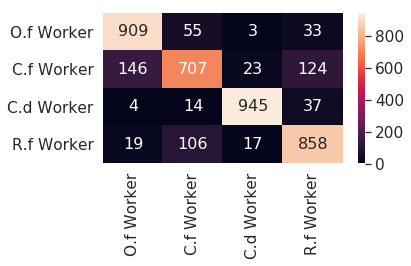


[2] accuracy: 0.891 loss: 17.990

[0.85475, 0.891]
[24.343521431088448, 17.989721469581127]


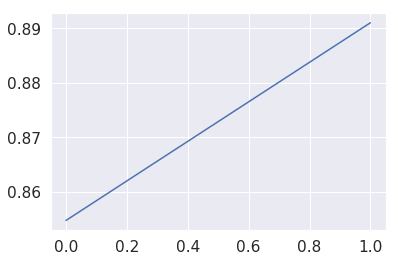

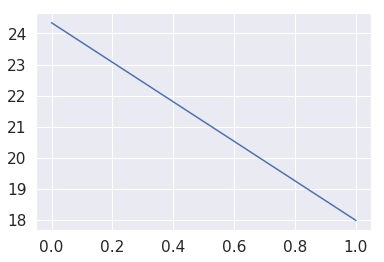

[3, 1, 0, 1, 3, 3, 1, 0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 0, 1, 0, 1, 0, 0, 1, 3, 1, 0, 1, 0, 3, 1, 0, 1, 1, 3, 1, 1, 0, 3, 3, 1, 3, 0, 1, 1, 1, 3, 1, 0, 0, 3, 0, 3, 1, 0, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 3, 0, 1, 3, 3, 1, 0, 3, 1, 0, 3, 3, 0, 0, 3, 3, 0, 2, 0, 2, 3, 3, 1, 1, 2, 0, 2, 0, 3, 2, 3, 1, 1, 3, 3, 1, 3, 3, 1, 0, 3, 3, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 2, 2, 0, 2, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 0, 0, 1, 3, 1, 3, 2, 1, 1, 3, 0, 1, 1, 2, 1, 3, 3, 0, 0, 1, 0, 0, 1, 2, 0, 3, 1, 1, 1, 3, 1, 0, 1, 3, 3, 3, 0, 3, 1, 1, 0, 1, 1, 3, 0, 3, 0, 1, 3, 0, 1, 1, 1, 2, 1, 1, 1, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 0, 1, 3, 3, 2, 2, 0, 1, 1, 0, 2, 1, 1, 3, 0, 0, 3, 0, 0, 3, 1, 3, 2, 3, 0, 2, 0, 1, 0, 3, 2, 3, 3, 2, 3, 3, 3, 3, 0, 0, 0, 3, 1, 3, 0, 2, 0, 2, 1, 0, 3, 3, 0, 3, 3, 1, 1, 3, 1, 3, 1, 0, 1, 3, 3, 2, 1, 2, 2, 1, 1, 1, 0, 1, 2, 3, 3, 0, 0, 1, 1, 0, 1, 3, 1, 2, 3, 0, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 

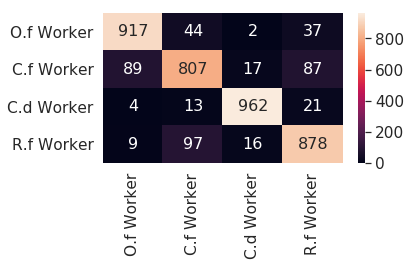


[3] accuracy: 0.903 loss: 17.438

[0.85475, 0.891, 0.903]
[24.343521431088448, 17.989721469581127, 17.4379405900836]


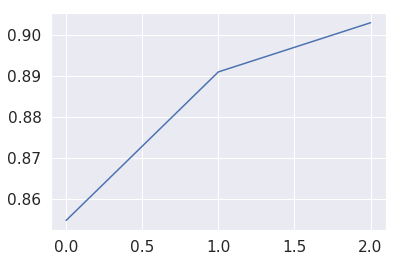

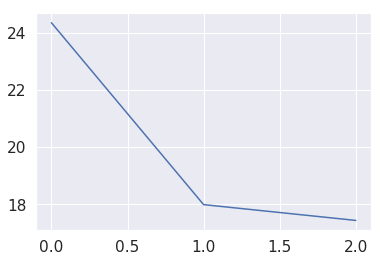

[2, 0, 3, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 3, 0, 1, 0, 2, 0, 3, 3, 0, 3, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 0, 1, 3, 1, 3, 0, 0, 3, 3, 1, 0, 3, 0, 0, 0, 1, 3, 0, 3, 3, 1, 3, 3, 1, 0, 1, 3, 0, 3, 3, 3, 1, 1, 0, 0, 0, 3, 0, 0, 3, 1, 1, 0, 3, 1, 1, 3, 0, 3, 0, 3, 3, 1, 3, 0, 0, 1, 3, 3, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 0, 3, 1, 0, 3, 0, 1, 3, 0, 1, 0, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0, 0, 1, 0, 0, 0, 3, 0, 1, 0, 0, 3, 3, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 3, 1, 3, 1, 0, 3, 0, 3, 1, 3, 3, 3, 1, 0, 1, 0, 0, 0, 0, 3, 0, 3, 0, 1, 3, 3, 0, 3, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 3, 1, 1, 1, 0, 3, 1, 3, 0, 1, 3, 3, 3, 0, 2, 0, 1, 1, 0, 1, 1, 3, 0, 3, 3, 0, 1, 0, 1, 2, 3, 2, 0, 0, 1, 3, 3, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 3, 0, 1, 3, 3, 1, 2, 3, 3, 0, 0, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 0, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 2, 0, 1, 3, 0, 3, 3, 1, 3, 1, 1, 0, 0, 1, 0, 2, 3, 2, 1, 1, 1, 0, 1, 0, 0, 1, 

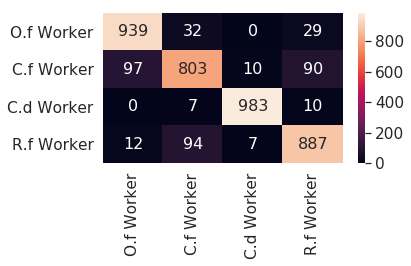


[4] accuracy: 0.911 loss: 15.888

[0.85475, 0.891, 0.903, 0.9115]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884]


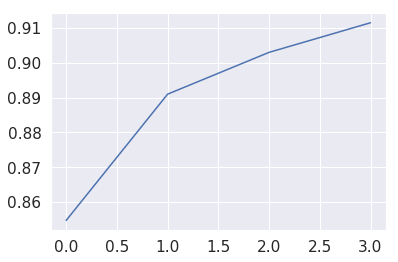

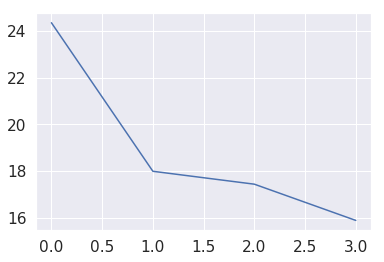

[3, 3, 1, 3, 0, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 2, 0, 3, 3, 0, 0, 3, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 2, 3, 1, 1, 0, 3, 3, 1, 0, 0, 0, 0, 0, 1, 1, 3, 3, 2, 1, 2, 3, 3, 3, 3, 0, 0, 1, 0, 3, 1, 1, 0, 2, 1, 3, 3, 3, 2, 1, 1, 0, 1, 1, 0, 1, 2, 3, 1, 3, 2, 3, 0, 3, 1, 0, 0, 3, 1, 1, 0, 1, 0, 1, 3, 0, 3, 0, 1, 0, 1, 0, 3, 0, 3, 3, 1, 0, 2, 1, 3, 3, 3, 1, 1, 1, 0, 1, 0, 2, 0, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 0, 3, 0, 1, 1, 3, 3, 0, 1, 3, 1, 3, 1, 1, 3, 0, 1, 0, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 0, 1, 3, 3, 1, 1, 1, 3, 0, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 3, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 3, 3, 1, 3, 0, 1, 3, 3, 0, 3, 3, 0, 0, 1, 3, 1, 3, 0, 1, 0, 0, 3, 0, 3, 1, 1, 3, 1, 2, 3, 1, 0, 1, 3, 1, 3, 1, 0, 0, 3, 1, 1, 0, 0, 1, 3, 0, 1, 1, 0, 0, 1, 1, 3, 3, 1, 0, 3, 1, 0, 2, 0, 3, 0, 1, 1, 1, 3, 1, 3, 0, 0, 1, 0, 2, 1, 1, 3, 3, 1, 3, 0, 3, 2, 1, 3, 3, 3, 1, 1, 0, 1, 3, 1, 3, 1, 1, 0, 0, 0, 3, 0, 3, 2, 3, 

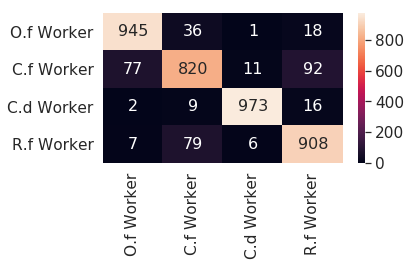


[5] accuracy: 0.914 loss: 16.297

[0.85475, 0.891, 0.903, 0.9115, 0.91375]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346]


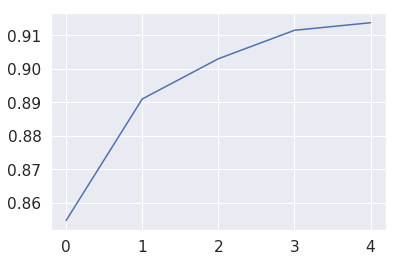

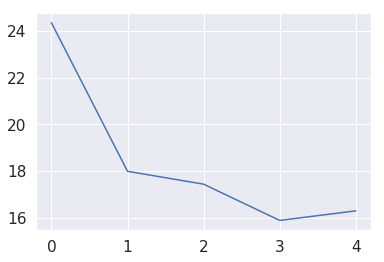

[3, 1, 3, 0, 1, 3, 1, 2, 2, 3, 3, 0, 0, 1, 1, 1, 3, 1, 1, 0, 1, 3, 1, 0, 0, 1, 0, 3, 3, 3, 1, 0, 1, 0, 0, 3, 1, 3, 3, 1, 2, 1, 3, 0, 0, 3, 3, 3, 1, 1, 2, 3, 2, 1, 1, 0, 0, 3, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 3, 3, 0, 1, 1, 0, 1, 2, 1, 0, 3, 1, 1, 1, 3, 1, 1, 2, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 0, 3, 1, 0, 3, 1, 3, 3, 3, 3, 0, 1, 2, 3, 0, 3, 3, 3, 3, 1, 3, 3, 0, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 0, 0, 0, 3, 0, 0, 1, 3, 0, 3, 0, 3, 3, 1, 1, 1, 3, 1, 1, 0, 3, 0, 0, 1, 1, 1, 3, 3, 3, 2, 1, 2, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 0, 3, 3, 3, 1, 3, 2, 3, 1, 1, 2, 3, 2, 3, 3, 1, 1, 0, 0, 3, 1, 1, 0, 1, 3, 0, 0, 1, 2, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 0, 1, 3, 3, 3, 0, 1, 2, 0, 1, 3, 3, 1, 0, 3, 3, 0, 0, 1, 0, 3, 3, 1, 3, 2, 0, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 1, 0, 1, 3, 3, 2, 3, 1, 1, 1, 1, 3, 3, 0, 0, 3, 0, 3, 3, 1, 3, 0, 0, 3, 0, 0, 3, 3, 1, 1, 1, 0, 1, 1, 0, 3, 2, 0, 0, 3, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 0, 1, 3, 

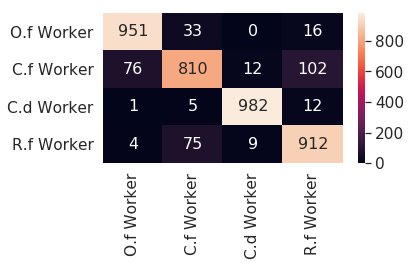


[6] accuracy: 0.916 loss: 15.509

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332]


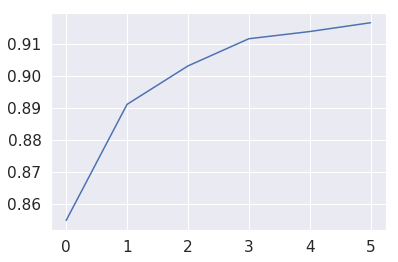

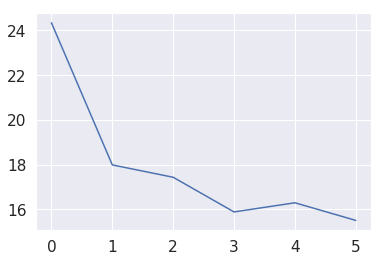

[1, 1, 1, 0, 3, 3, 3, 0, 1, 1, 2, 1, 3, 3, 2, 3, 3, 0, 0, 0, 3, 3, 3, 3, 1, 1, 0, 3, 1, 1, 3, 2, 0, 0, 1, 0, 3, 3, 1, 3, 2, 1, 3, 2, 3, 0, 1, 0, 3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 0, 3, 1, 2, 3, 3, 3, 2, 1, 3, 3, 0, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 3, 1, 0, 2, 3, 3, 0, 1, 3, 1, 3, 1, 1, 0, 1, 0, 3, 1, 2, 0, 0, 0, 2, 1, 0, 3, 0, 3, 1, 0, 0, 1, 1, 3, 1, 0, 1, 3, 0, 0, 0, 3, 0, 0, 3, 3, 1, 0, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 2, 2, 2, 3, 2, 1, 0, 1, 2, 3, 1, 1, 0, 3, 2, 1, 3, 3, 1, 1, 1, 0, 1, 0, 0, 3, 3, 3, 0, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 0, 2, 1, 3, 1, 0, 3, 3, 0, 1, 3, 0, 3, 3, 3, 1, 1, 1, 3, 0, 0, 1, 1, 1, 3, 3, 0, 1, 0, 3, 3, 3, 0, 2, 1, 1, 1, 3, 1, 1, 0, 3, 1, 1, 1, 3, 1, 0, 1, 0, 0, 1, 3, 1, 1, 1, 3, 0, 1, 0, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 3, 1, 0, 3, 2, 1, 0, 0, 3, 3, 0, 3, 1, 1, 2, 2, 3, 1, 1, 3, 3, 3, 1, 1, 0, 2, 1, 3, 3, 3, 0, 3, 3, 3, 3, 2, 1, 0, 0, 1, 1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 

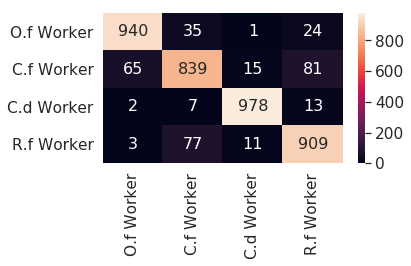


[7] accuracy: 0.915 loss: 15.223

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913]


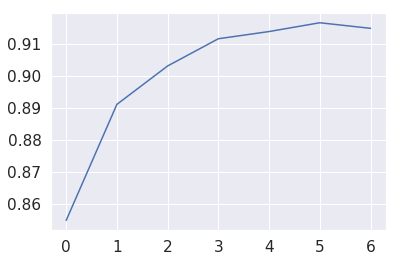

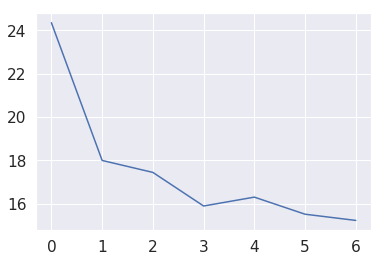

[2, 3, 3, 2, 1, 2, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 0, 0, 0, 0, 3, 3, 3, 1, 1, 3, 3, 0, 0, 1, 1, 1, 2, 3, 0, 3, 1, 0, 3, 3, 1, 1, 1, 1, 0, 1, 3, 3, 1, 3, 0, 2, 0, 0, 3, 3, 0, 3, 1, 1, 3, 0, 3, 3, 1, 1, 0, 1, 1, 2, 0, 3, 0, 3, 2, 0, 3, 1, 2, 3, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 2, 3, 0, 1, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 3, 0, 3, 1, 0, 0, 1, 1, 3, 3, 0, 0, 3, 3, 1, 3, 3, 3, 1, 0, 0, 0, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 0, 3, 1, 0, 2, 1, 3, 0, 3, 1, 0, 1, 2, 2, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 2, 3, 1, 3, 3, 0, 0, 3, 3, 3, 0, 0, 0, 3, 2, 0, 0, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 0, 1, 3, 1, 1, 1, 0, 3, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 3, 3, 1, 0, 3, 3, 1, 3, 0, 3, 1, 3, 3, 0, 0, 2, 0, 0, 3, 1, 3, 1, 1, 3, 1, 0, 2, 1, 3, 2, 3, 0, 1, 1, 1, 0, 3, 3, 0, 3, 3, 1, 3, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 0, 3, 0, 3, 3, 0, 1, 0, 3, 0, 2, 1, 1, 1, 2, 1, 0, 1, 0, 3, 1, 0, 1, 3, 1, 1, 1, 0, 1, 

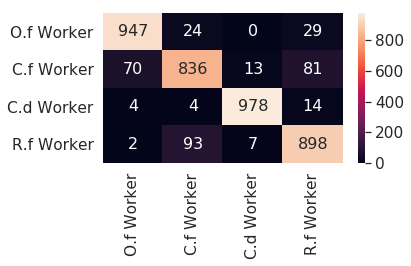


[8] accuracy: 0.918 loss: 15.213

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099]


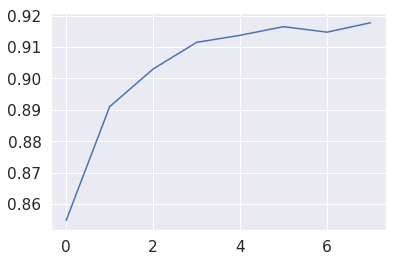

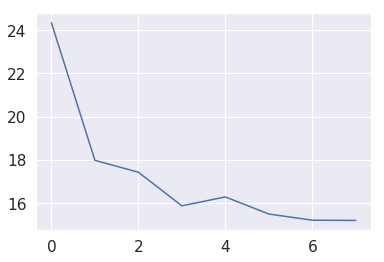

[1, 1, 3, 1, 3, 3, 2, 1, 0, 3, 1, 1, 1, 1, 3, 0, 1, 1, 0, 3, 3, 0, 3, 1, 3, 3, 2, 0, 1, 3, 1, 0, 1, 0, 0, 1, 0, 1, 0, 3, 1, 0, 1, 3, 1, 1, 0, 0, 1, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 0, 1, 3, 0, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 0, 0, 3, 1, 3, 0, 3, 1, 1, 0, 1, 3, 1, 0, 0, 1, 2, 0, 0, 3, 3, 3, 1, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 2, 1, 1, 1, 0, 3, 1, 1, 0, 0, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3, 1, 1, 1, 0, 0, 3, 1, 3, 1, 1, 3, 1, 3, 1, 2, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 0, 3, 2, 1, 3, 1, 0, 1, 0, 1, 3, 3, 3, 3, 0, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 1, 0, 0, 0, 1, 1, 3, 1, 0, 3, 0, 0, 0, 1, 3, 0, 3, 0, 3, 3, 1, 0, 1, 1, 1, 0, 1, 2, 0, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 2, 3, 0, 0, 0, 3, 0, 3, 1, 3, 1, 3, 3, 0, 1, 0, 3, 3, 1, 0, 3, 0, 3, 0, 3, 3, 3, 1, 0, 3, 0, 1, 3, 3, 1, 1, 2, 1, 1, 0, 3, 0, 1, 3, 3, 3, 1, 3, 0, 0, 1, 3, 1, 3, 3, 0, 3, 3, 3, 0, 1, 3, 0, 3, 1, 3, 3, 0, 0, 2, 1, 2, 1, 1, 0, 3, 3, 1, 3, 1, 2, 1, 3, 3, 0, 1, 1]
            

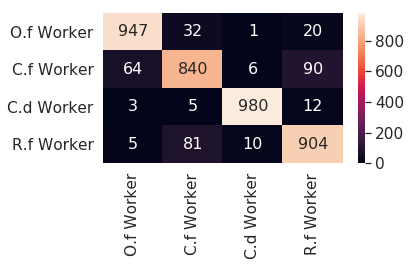


[9] accuracy: 0.921 loss: 14.769

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666]


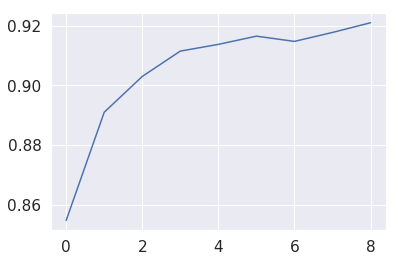

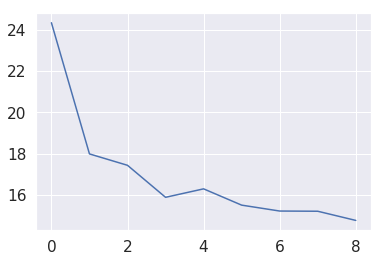

[1, 0, 0, 0, 1, 3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3, 3, 2, 1, 3, 0, 1, 0, 1, 2, 0, 3, 1, 3, 0, 1, 0, 3, 3, 0, 1, 3, 0, 0, 2, 3, 1, 3, 1, 0, 3, 1, 0, 1, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 1, 3, 1, 1, 0, 0, 0, 3, 0, 1, 2, 0, 3, 0, 3, 1, 1, 3, 3, 1, 1, 2, 2, 3, 3, 1, 1, 1, 3, 2, 0, 3, 2, 0, 2, 2, 3, 1, 1, 1, 3, 3, 0, 1, 0, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 2, 2, 0, 0, 1, 3, 1, 0, 0, 3, 1, 3, 0, 1, 2, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 0, 0, 0, 3, 0, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 2, 3, 0, 3, 0, 1, 1, 3, 1, 1, 0, 1, 3, 3, 3, 3, 0, 1, 1, 1, 3, 2, 0, 0, 0, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 2, 3, 1, 2, 3, 3, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 3, 0, 1, 3, 1, 3, 1, 0, 3, 0, 1, 3, 3, 3, 3, 1, 0, 0, 3, 0, 3, 3, 1, 0, 1, 1, 1, 3, 0, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 0, 3, 1, 2, 3, 3, 0, 3, 1, 0, 0, 1, 0, 1, 3, 1, 1, 3, 3, 1, 0, 1, 0, 3, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 0, 1, 0, 0, 0, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f

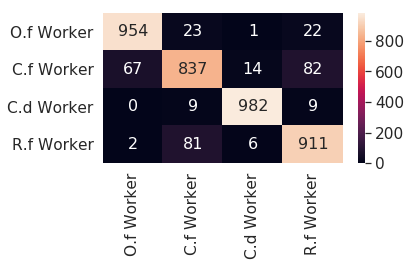


[10] accuracy: 0.918 loss: 15.554

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233]


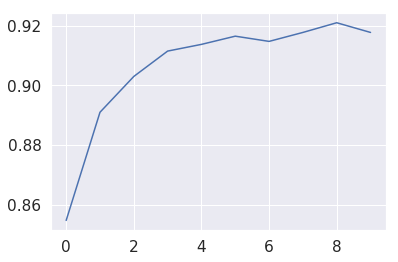

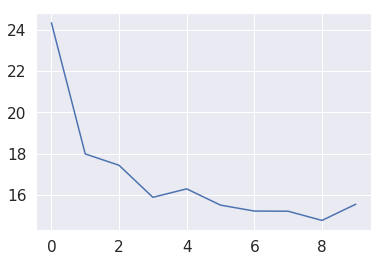

[3, 3, 1, 2, 1, 0, 0, 3, 0, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 3, 2, 3, 1, 1, 0, 2, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 1, 1, 3, 3, 1, 2, 1, 1, 0, 2, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 0, 3, 0, 0, 3, 1, 0, 1, 1, 2, 1, 0, 1, 0, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0, 3, 0, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 2, 0, 1, 3, 1, 1, 0, 0, 3, 3, 1, 3, 2, 1, 1, 0, 3, 0, 0, 1, 3, 1, 2, 3, 3, 3, 2, 1, 3, 3, 3, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 0, 1, 3, 2, 3, 1, 1, 3, 0, 3, 0, 1, 0, 1, 1, 1, 3, 1, 1, 1, 0, 1, 3, 3, 0, 0, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 0, 1, 3, 3, 0, 1, 3, 3, 1, 1, 0, 1, 0, 3, 1, 1, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 0, 3, 0, 1, 0, 1, 0, 3, 1, 3, 0, 0, 1, 2, 3, 1, 1, 3, 3, 1, 3, 0, 2, 1, 1, 0, 1, 0, 0, 2, 3, 0, 0, 0, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 0, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 0, 0, 3, 0, 1, 3, 2, 0, 3, 0, 0, 1, 0, 1, 3, 3, 3, 1, 3]
            

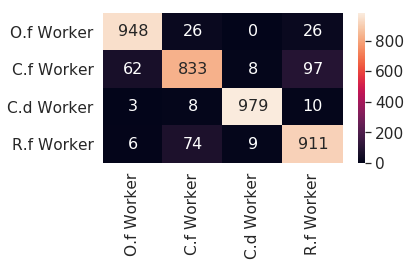


[11] accuracy: 0.917 loss: 16.150

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454]


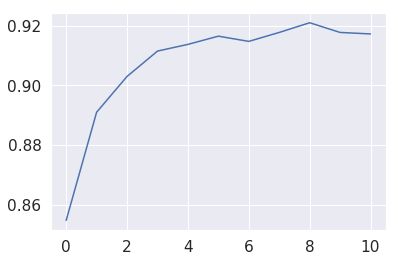

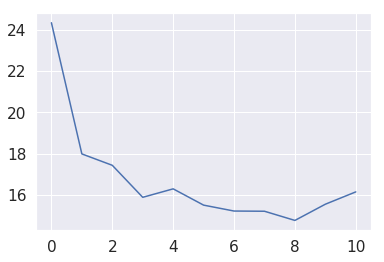

[3, 1, 3, 1, 1, 1, 1, 1, 2, 0, 2, 2, 3, 0, 1, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 3, 0, 0, 3, 3, 3, 1, 0, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 1, 3, 1, 0, 3, 3, 0, 0, 0, 1, 3, 1, 0, 1, 0, 3, 3, 3, 2, 1, 3, 1, 1, 0, 3, 1, 0, 3, 1, 1, 3, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 0, 1, 1, 3, 3, 1, 1, 3, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 1, 3, 1, 0, 3, 3, 0, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 3, 0, 1, 1, 2, 3, 3, 0, 3, 1, 0, 1, 3, 0, 3, 3, 2, 0, 3, 3, 0, 0, 1, 1, 3, 3, 0, 1, 3, 3, 0, 1, 2, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 1, 0, 1, 0, 0, 3, 0, 3, 1, 1, 1, 1, 3, 2, 3, 0, 3, 1, 2, 1, 2, 3, 3, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 0, 2, 0, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 0, 0, 1, 3, 3, 0, 3, 3, 1, 1, 1, 1, 0, 3, 1, 1, 3, 0, 1, 0, 0, 2, 2, 3, 3, 0, 0, 3, 0, 3, 1, 2, 3, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 2, 3, 3, 1, 2, 3, 3, 3, 0, 1, 1, 3, 3, 3, 0, 1, 1, 1, 1, 1, 0, 0, 2, 3, 0, 1, 1, 1, 3, 3, 3, 3, 0, 1, 1, 2]
      

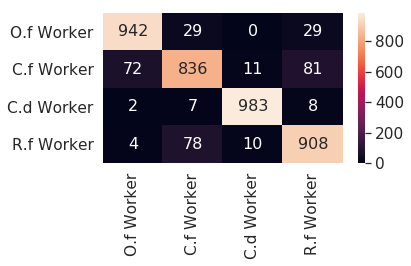


[12] accuracy: 0.924 loss: 15.251

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044]


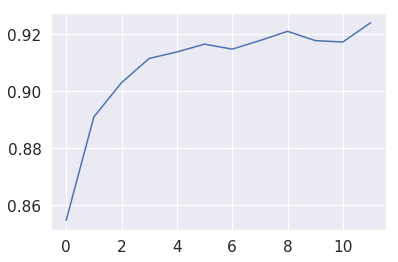

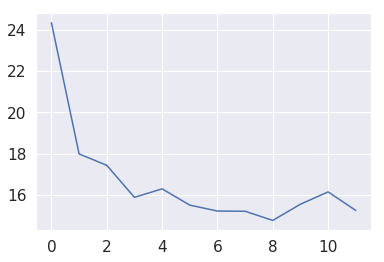

[1, 1, 3, 2, 3, 1, 1, 3, 3, 3, 0, 1, 3, 1, 1, 3, 3, 3, 1, 3, 0, 1, 0, 0, 0, 2, 3, 1, 0, 3, 1, 1, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 0, 2, 1, 3, 1, 1, 1, 2, 3, 3, 3, 0, 3, 3, 0, 3, 0, 1, 3, 1, 1, 2, 3, 3, 0, 1, 1, 1, 3, 1, 2, 3, 3, 3, 2, 3, 3, 0, 1, 1, 2, 3, 0, 0, 1, 3, 0, 1, 1, 1, 1, 3, 1, 0, 3, 3, 3, 3, 1, 0, 1, 0, 1, 0, 2, 3, 1, 1, 3, 3, 1, 0, 1, 1, 3, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 0, 0, 1, 1, 3, 0, 1, 3, 1, 0, 1, 3, 3, 1, 2, 3, 1, 3, 0, 3, 1, 1, 2, 2, 0, 0, 1, 3, 3, 0, 3, 1, 0, 0, 1, 1, 1, 0, 1, 3, 0, 3, 1, 2, 2, 3, 1, 0, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 0, 3, 0, 0, 1, 3, 0, 3, 3, 0, 3, 0, 2, 1, 1, 2, 1, 0, 3, 3, 3, 0, 0, 1, 1, 0, 3, 1, 1, 0, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 0, 0, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 1, 0, 1, 3, 3, 3, 0, 1, 1, 1, 0, 1, 0, 1, 3, 0, 3, 1, 1, 0, 0, 3, 1, 1, 3, 1, 3, 1, 1, 0, 1, 0, 3, 1, 1, 1, 0, 1, 1, 3, 3, 1, 0, 1, 1, 0, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         961      

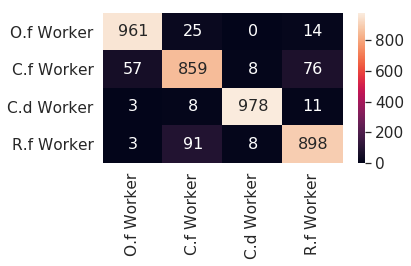


[13] accuracy: 0.929 loss: 14.865

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088]


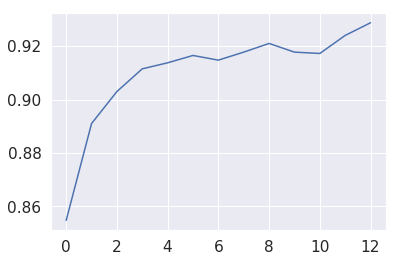

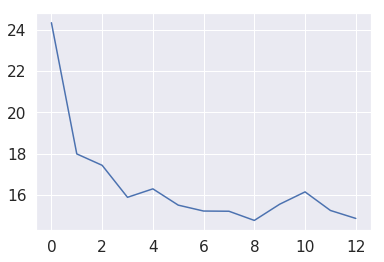

[1, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 1, 1, 0, 1, 2, 2, 3, 0, 0, 0, 3, 3, 1, 3, 3, 1, 0, 3, 3, 0, 0, 1, 1, 1, 0, 2, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 0, 3, 3, 1, 1, 1, 2, 2, 1, 1, 3, 3, 3, 0, 3, 3, 0, 2, 2, 0, 0, 3, 1, 3, 3, 3, 1, 0, 1, 0, 3, 3, 3, 3, 3, 3, 1, 0, 1, 2, 3, 1, 0, 1, 3, 1, 0, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 1, 1, 3, 1, 3, 1, 0, 0, 0, 3, 0, 3, 0, 0, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 0, 3, 0, 3, 1, 1, 0, 0, 0, 1, 1, 2, 3, 2, 0, 1, 3, 1, 0, 1, 3, 2, 1, 1, 3, 0, 1, 1, 1, 0, 1, 3, 3, 1, 2, 1, 0, 3, 3, 3, 3, 0, 3, 0, 0, 1, 0, 3, 3, 1, 1, 1, 0, 3, 2, 1, 1, 0, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 0, 1, 0, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 0, 0, 1, 1, 0, 1, 1, 1, 3, 1, 1, 3, 3, 0, 0, 3, 2, 1, 0, 1, 3, 3, 0, 2, 0, 3, 1, 3, 2, 0, 0, 3, 3, 0, 2, 1, 3, 3, 0, 2, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          22           2          16
C.f Worker          55    

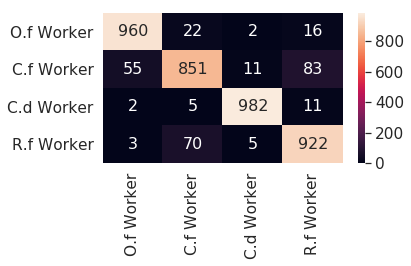


[14] accuracy: 0.926 loss: 14.609

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297]


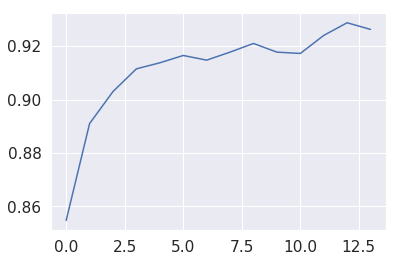

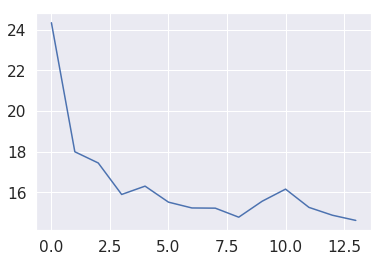

[1, 3, 2, 1, 0, 3, 1, 0, 0, 1, 0, 2, 0, 3, 1, 1, 1, 3, 3, 3, 3, 1, 2, 0, 1, 1, 0, 0, 3, 1, 1, 1, 0, 1, 0, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 3, 3, 0, 3, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 2, 1, 3, 0, 0, 1, 1, 1, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 0, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 1, 1, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 2, 1, 1, 0, 3, 1, 3, 0, 3, 2, 0, 0, 1, 3, 3, 3, 0, 1, 2, 1, 3, 0, 0, 1, 2, 2, 0, 1, 0, 0, 3, 1, 1, 0, 3, 3, 2, 2, 1, 0, 3, 1, 2, 1, 1, 1, 3, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 0, 0, 0, 1, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 3, 0, 0, 1, 0, 1, 3, 2, 1, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 0, 3, 3, 0, 0, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 2, 3, 0, 3, 0, 3, 2, 3, 1, 1, 0, 2, 1, 2, 3, 3, 3, 3, 3, 0, 1, 0, 1, 0, 3, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         965          19           0         

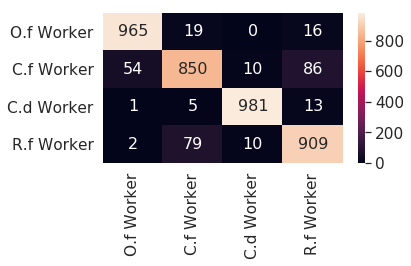


[15] accuracy: 0.925 loss: 15.476

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544]


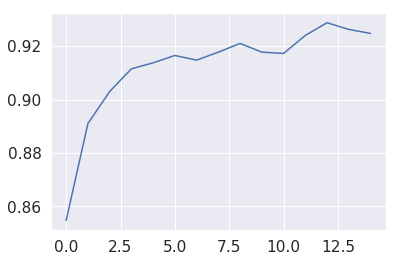

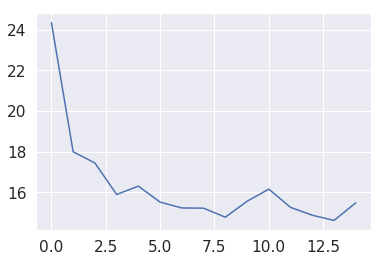

[3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 1, 1, 1, 2, 1, 3, 0, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 0, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 0, 1, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 0, 1, 1, 3, 3, 1, 1, 2, 0, 3, 1, 0, 3, 0, 1, 3, 1, 3, 1, 1, 3, 0, 1, 3, 3, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 3, 1, 1, 3, 0, 3, 0, 2, 3, 3, 1, 0, 1, 1, 0, 0, 1, 0, 0, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 0, 0, 1, 0, 0, 3, 3, 3, 1, 0, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 0, 3, 3, 0, 0, 3, 3, 1, 1, 0, 1, 3, 3, 0, 3, 3, 3, 3, 2, 0, 1, 3, 1, 0, 3, 3, 3, 2, 1, 1, 1, 1, 3, 1, 1, 3, 3, 0, 0, 1, 1, 0, 2, 1, 1, 3, 1, 0, 1, 0, 3, 3, 3, 3, 1, 3, 3, 0, 1, 0, 3, 0, 0, 0, 2, 0, 0, 1, 3, 2, 3, 3, 0, 3, 1, 2, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 2, 0, 1, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          17   

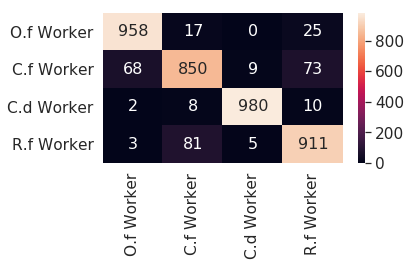


[16] accuracy: 0.927 loss: 14.950

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352]


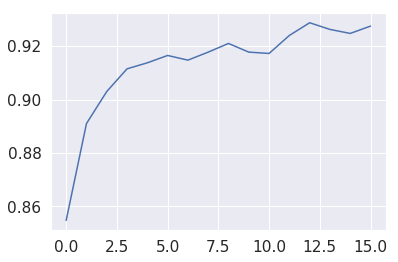

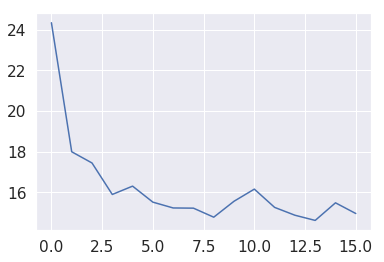

[2, 0, 1, 3, 3, 1, 1, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 1, 1, 1, 3, 2, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 1, 3, 0, 1, 1, 0, 1, 1, 1, 3, 3, 2, 1, 3, 0, 0, 2, 1, 3, 3, 0, 1, 3, 0, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 0, 1, 2, 3, 0, 3, 1, 1, 0, 3, 1, 1, 3, 1, 1, 3, 1, 2, 3, 0, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 1, 3, 0, 0, 3, 3, 3, 3, 1, 3, 0, 3, 0, 3, 1, 3, 3, 3, 1, 1, 1, 2, 3, 1, 3, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 0, 0, 0, 3, 3, 0, 0, 3, 2, 3, 3, 0, 3, 1, 3, 1, 3, 3, 2, 1, 1, 2, 0, 1, 1, 2, 0, 3, 1, 1, 3, 3, 3, 1, 2, 3, 0, 3, 3, 1, 0, 1, 1, 1, 0, 0, 1, 3, 0, 1, 3, 1, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 2, 1, 0, 1, 3, 0, 0, 1, 0, 3, 1, 1, 0, 1, 3, 3, 3, 3, 1, 0, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         959          23           0          18
C.f Worker 

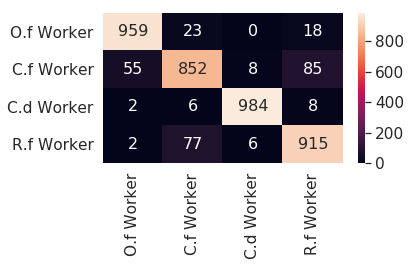


[17] accuracy: 0.924 loss: 14.809

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396]


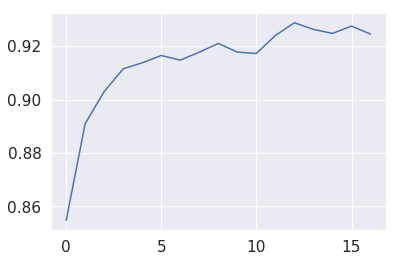

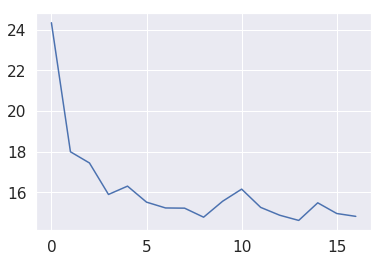

[0, 1, 3, 3, 3, 0, 0, 0, 1, 0, 3, 1, 0, 1, 0, 0, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 1, 3, 0, 1, 3, 1, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 3, 3, 3, 2, 1, 3, 1, 1, 3, 2, 3, 0, 3, 3, 0, 1, 0, 1, 1, 3, 3, 3, 3, 2, 3, 1, 1, 3, 0, 1, 1, 1, 3, 3, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 3, 1, 0, 1, 1, 0, 1, 3, 1, 0, 1, 0, 3, 3, 1, 3, 1, 3, 2, 3, 0, 1, 1, 0, 1, 3, 1, 2, 3, 0, 0, 3, 0, 3, 0, 1, 3, 1, 1, 0, 3, 0, 1, 3, 1, 3, 0, 3, 0, 2, 1, 3, 0, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 0, 0, 1, 0, 3, 3, 2, 2, 3, 1, 3, 3, 1, 2, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 0, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 2, 0, 0, 3, 1, 1, 3, 3, 1, 2, 0, 1, 3, 0, 0, 3, 3, 1, 0, 0, 0, 3, 3, 1, 3, 1, 1, 1, 0, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 1, 1, 3, 1, 3, 2, 0, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 2, 3, 3, 3, 1, 3, 1, 0, 3, 2, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 3, 0, 0, 3, 3, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          23

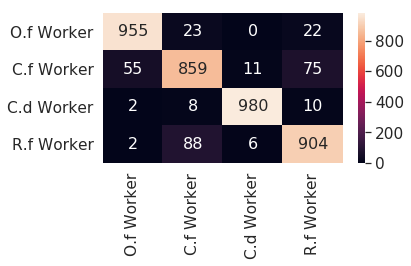


[18] accuracy: 0.926 loss: 15.133

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905]


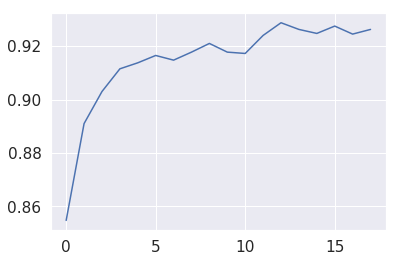

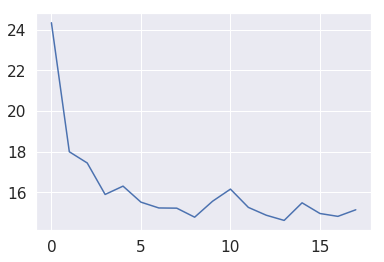

[0, 1, 1, 3, 0, 3, 1, 1, 0, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 2, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 2, 3, 0, 1, 3, 0, 0, 2, 3, 0, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 2, 1, 2, 1, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 2, 2, 0, 3, 3, 3, 1, 3, 0, 1, 1, 1, 0, 1, 3, 0, 0, 0, 1, 1, 1, 3, 0, 3, 3, 1, 3, 0, 1, 1, 3, 3, 0, 3, 3, 0, 0, 0, 1, 0, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 1, 1, 1, 3, 0, 0, 3, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 3, 1, 3, 0, 0, 0, 1, 3, 3, 0, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 1, 3, 0, 1, 3, 3, 0, 1, 1, 2, 1, 1, 3, 3, 1, 1, 0, 1, 3, 3, 3, 2, 2, 1, 3, 1, 3, 1, 1, 0, 1, 3, 1, 3, 3, 0, 1, 3, 0, 2, 3, 1, 2, 3, 0, 1, 3, 3, 1, 1, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 3, 3, 0, 3, 3, 1, 3, 3, 2, 1, 0, 3, 1, 1, 2, 0, 3, 0, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 0, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          24           1         

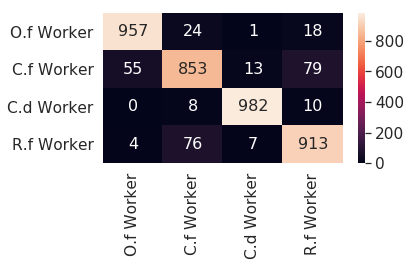


[19] accuracy: 0.926 loss: 15.240

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573]


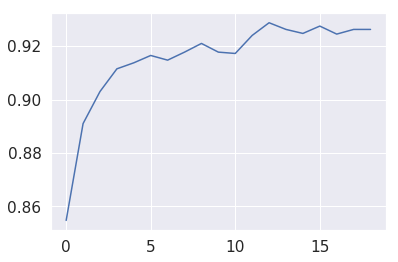

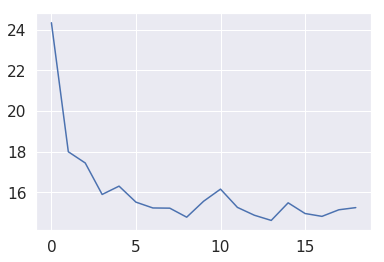

[0, 3, 1, 2, 1, 1, 0, 1, 3, 1, 1, 3, 0, 3, 0, 2, 0, 1, 0, 0, 1, 0, 3, 3, 0, 3, 0, 0, 0, 1, 2, 3, 1, 1, 3, 2, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 1, 3, 0, 0, 0, 1, 3, 1, 0, 2, 1, 1, 1, 0, 1, 3, 0, 3, 1, 3, 3, 1, 3, 3, 0, 1, 2, 1, 1, 3, 3, 1, 2, 3, 1, 3, 1, 3, 1, 3, 3, 3, 0, 1, 1, 3, 3, 0, 1, 1, 0, 0, 3, 1, 3, 1, 0, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 1, 0, 0, 1, 0, 3, 1, 3, 3, 0, 3, 3, 1, 0, 1, 0, 1, 2, 1, 3, 0, 1, 3, 0, 3, 1, 2, 0, 0, 3, 1, 1, 3, 1, 2, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 0, 0, 0, 3, 3, 1, 1, 3, 0, 1, 0, 1, 0, 0, 0, 0, 3, 3, 1, 2, 3, 3, 0, 2, 0, 1, 0, 0, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3, 0, 1, 0, 2, 2, 0, 1, 0, 1, 1, 0, 3, 0, 3, 1, 1, 3, 1, 0, 3, 3, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         946          28           1         

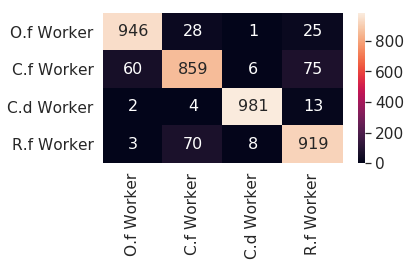


[20] accuracy: 0.928 loss: 15.421

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882]


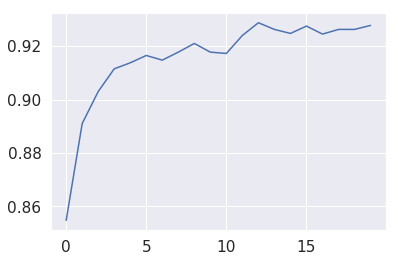

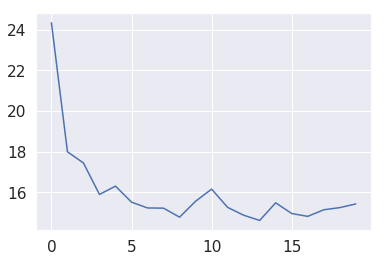

[3, 0, 0, 3, 0, 1, 1, 3, 1, 3, 3, 1, 3, 3, 0, 1, 1, 3, 3, 0, 3, 1, 3, 3, 0, 3, 0, 1, 3, 3, 3, 0, 1, 0, 2, 0, 0, 1, 1, 0, 1, 3, 3, 3, 1, 3, 3, 0, 0, 3, 0, 1, 0, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 0, 1, 3, 0, 1, 3, 3, 0, 1, 1, 1, 0, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 3, 3, 1, 0, 1, 0, 0, 0, 3, 1, 3, 1, 3, 3, 3, 3, 1, 0, 1, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 1, 3, 3, 0, 3, 1, 0, 3, 1, 1, 1, 3, 3, 0, 1, 0, 1, 1, 3, 0, 3, 3, 1, 3, 0, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 0, 1, 0, 3, 3, 2, 3, 0, 2, 3, 1, 0, 3, 1, 3, 0, 3, 3, 0, 0, 3, 3, 1, 2, 3, 3, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 2, 3, 1, 3, 0, 3, 1, 0, 1, 3, 0, 2, 1, 3, 1, 3, 0, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 1, 0, 3, 1, 1, 0, 3, 3, 3, 1, 3, 0, 1, 0, 3, 3, 1, 1, 1, 3, 2, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 0, 3, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         959          21           0          20
C.f Worker    

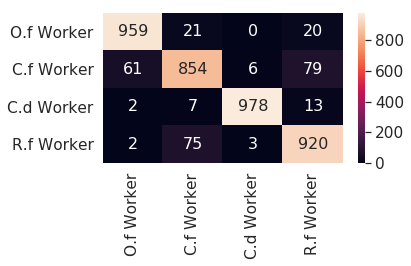


[21] accuracy: 0.925 loss: 15.375

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664]


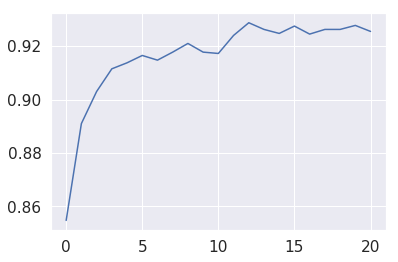

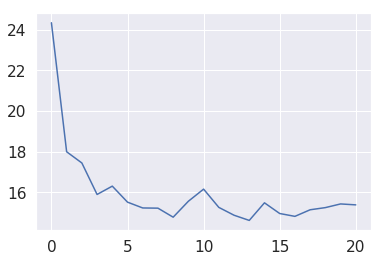

[3, 3, 1, 1, 3, 3, 3, 1, 2, 1, 1, 3, 1, 3, 1, 3, 3, 2, 1, 3, 0, 3, 3, 3, 3, 0, 2, 0, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 0, 3, 3, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 2, 2, 3, 1, 1, 1, 0, 1, 2, 1, 3, 0, 0, 1, 0, 0, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 0, 3, 1, 0, 0, 3, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 3, 1, 0, 3, 3, 3, 2, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 1, 1, 1, 1, 3, 0, 1, 2, 3, 1, 0, 3, 3, 1, 3, 2, 3, 0, 3, 0, 1, 1, 3, 1, 3, 0, 1, 1, 1, 1, 3, 3, 3, 1, 1, 2, 3, 3, 1, 3, 1, 1, 0, 0, 1, 3, 0, 1, 1, 3, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 3, 1, 3, 3, 0, 3, 0, 3, 1, 1, 0, 1, 0, 1, 1, 3, 0, 3, 3, 3, 3, 3, 0, 1, 1, 1, 0, 3, 2, 3, 3, 0, 1, 0, 3, 3, 3, 1, 1, 1, 3, 0, 3, 3, 1, 3, 2, 1, 3, 1, 0, 0, 0, 1, 3, 3, 1, 0, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 1, 0, 1, 3, 3, 1, 3, 1, 0, 1, 3, 2, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         956          25           0

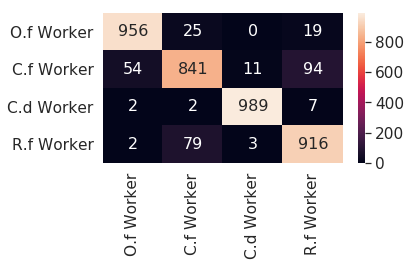


[22] accuracy: 0.931 loss: 15.775

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477]


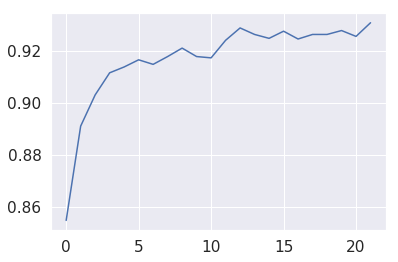

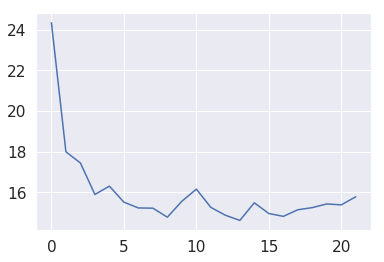

[1, 1, 1, 1, 1, 3, 2, 0, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 0, 3, 1, 1, 0, 0, 1, 0, 0, 1, 3, 3, 1, 3, 0, 1, 3, 1, 1, 1, 0, 0, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 0, 1, 0, 1, 3, 0, 0, 3, 3, 3, 3, 1, 0, 3, 3, 1, 1, 3, 1, 0, 3, 1, 3, 3, 3, 0, 0, 1, 1, 3, 1, 2, 3, 3, 3, 3, 3, 3, 0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 1, 3, 1, 0, 3, 2, 3, 3, 0, 1, 0, 1, 3, 3, 3, 0, 3, 3, 0, 3, 1, 2, 3, 3, 3, 1, 1, 1, 3, 0, 1, 0, 1, 1, 0, 1, 0, 3, 1, 1, 1, 0, 0, 3, 3, 3, 3, 3, 1, 2, 3, 1, 1, 1, 0, 3, 3, 0, 3, 0, 0, 3, 1, 3, 3, 2, 3, 1, 1, 1, 0, 1, 0, 3, 3, 0, 1, 3, 1, 1, 3, 1, 3, 0, 3, 1, 3, 3, 2, 1, 0, 1, 1, 2, 0, 0, 3, 0, 0, 1, 1, 1, 2, 1, 0, 3, 1, 1, 1, 3, 2, 0, 0, 0, 0, 3, 0, 1, 3, 0, 2, 0, 0, 3, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 2, 1, 1, 0, 3, 3, 3, 3, 3, 1, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          20           0          23
C.f Worker          55         862           9    

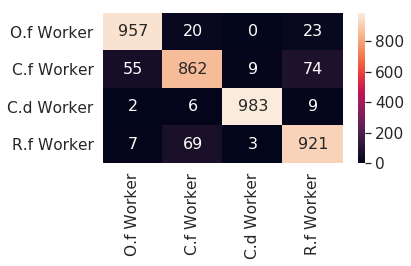


[23] accuracy: 0.925 loss: 15.764

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183]


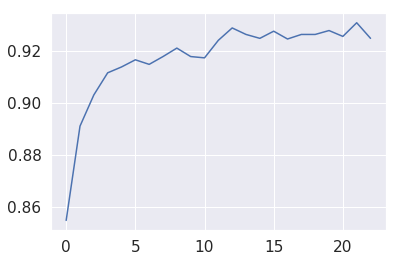

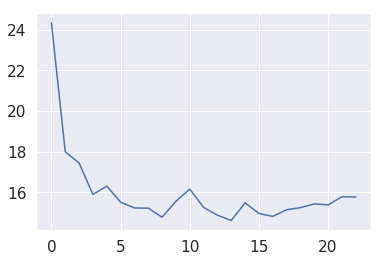

[1, 3, 3, 0, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 0, 0, 1, 1, 3, 3, 1, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 0, 1, 1, 3, 0, 3, 1, 1, 3, 1, 0, 1, 2, 0, 1, 3, 0, 2, 3, 1, 0, 0, 1, 0, 3, 0, 1, 3, 3, 3, 1, 0, 1, 3, 3, 2, 0, 3, 3, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 0, 1, 1, 0, 1, 2, 3, 0, 3, 1, 0, 0, 3, 3, 1, 1, 0, 1, 1, 0, 1, 0, 3, 3, 3, 0, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 2, 3, 1, 1, 3, 2, 3, 0, 1, 3, 1, 1, 1, 3, 1, 1, 1, 0, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 3, 3, 3, 0, 1, 1, 1, 3, 3, 0, 1, 3, 3, 0, 1, 1, 3, 1, 3, 3, 3, 3, 0, 2, 2, 0, 0, 3, 3, 1, 3, 3, 3, 0, 1, 1, 2, 3, 3, 0, 1, 0, 1, 1, 0, 2, 3, 1, 1, 0, 3, 0, 1, 3, 1, 3, 3, 3, 2, 0, 3, 0, 3, 0, 1, 1, 2, 3, 3, 1, 1, 0, 0, 1, 3, 1, 2, 3, 3, 3, 0, 0, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 0, 0, 1, 3, 1, 3, 3, 3, 1, 0, 1, 0, 3, 1, 3, 0, 3, 0, 1, 2, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 2, 0, 3, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          22   

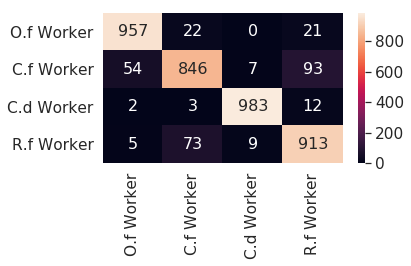


[24] accuracy: 0.926 loss: 15.547

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767]


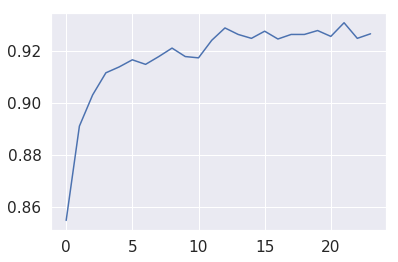

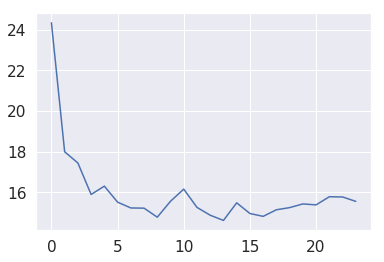

[3, 1, 1, 3, 0, 1, 0, 0, 3, 0, 0, 3, 0, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 0, 3, 0, 1, 1, 3, 1, 3, 3, 3, 0, 0, 1, 3, 1, 1, 3, 2, 3, 3, 0, 1, 1, 3, 3, 0, 3, 1, 0, 3, 3, 3, 1, 0, 0, 1, 2, 1, 1, 1, 3, 3, 3, 0, 3, 3, 0, 1, 1, 1, 1, 0, 3, 3, 0, 0, 3, 1, 0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 2, 1, 3, 2, 3, 3, 0, 0, 2, 3, 3, 0, 0, 3, 3, 1, 1, 1, 0, 1, 2, 2, 0, 2, 2, 1, 1, 1, 3, 3, 0, 3, 1, 3, 1, 1, 1, 0, 3, 3, 3, 0, 0, 1, 3, 3, 0, 3, 1, 1, 3, 2, 3, 1, 2, 3, 3, 0, 0, 1, 1, 1, 1, 3, 3, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 3, 1, 3, 1, 0, 0, 3, 3, 0, 2, 3, 3, 1, 0, 0, 1, 1, 0, 0, 1, 1, 3, 2, 1, 1, 3, 0, 3, 2, 1, 1, 1, 0, 1, 1, 3, 1, 0, 1, 1, 3, 1, 1, 3, 0, 3, 3, 0, 0, 0, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 3, 0, 1, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 3, 3, 2, 3, 0, 1, 1, 3, 3, 1, 3, 0, 3, 0, 1, 1, 3, 3, 0, 3, 1, 0, 0, 3, 3, 0, 1, 3, 3, 1, 0, 0, 1, 2, 3, 1, 3, 3, 3, 3, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         956          29           2          13

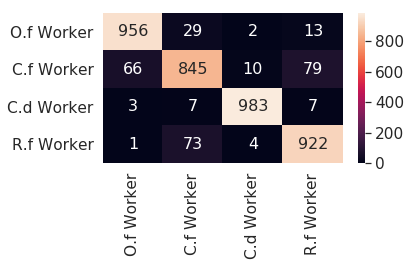


[25] accuracy: 0.928 loss: 15.437

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087]


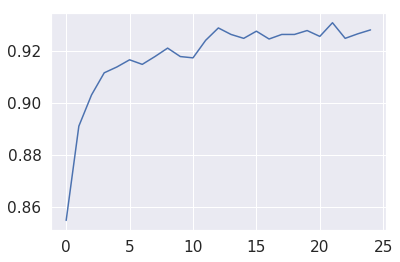

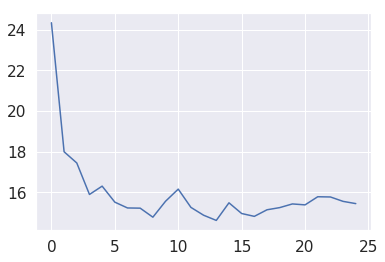

[2, 3, 3, 0, 0, 3, 0, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 0, 1, 0, 1, 0, 3, 0, 1, 2, 3, 0, 3, 3, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 0, 3, 0, 1, 1, 1, 3, 0, 0, 1, 0, 0, 1, 1, 1, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 0, 1, 3, 1, 3, 0, 1, 0, 0, 3, 3, 1, 3, 3, 2, 3, 3, 0, 3, 1, 1, 1, 1, 0, 0, 1, 3, 0, 1, 3, 1, 1, 1, 0, 3, 3, 2, 3, 3, 3, 2, 2, 0, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 1, 3, 3, 0, 0, 1, 3, 3, 3, 0, 3, 0, 3, 1, 0, 0, 3, 3, 0, 0, 0, 3, 1, 0, 1, 3, 1, 1, 1, 3, 1, 0, 3, 0, 3, 0, 3, 1, 3, 0, 1, 3, 1, 3, 1, 1, 0, 3, 1, 0, 1, 0, 1, 0, 0, 1, 3, 3, 3, 1, 3, 1, 0, 0, 3, 3, 3, 3, 3, 3, 2, 1, 1, 0, 0, 3, 1, 1, 3, 3, 2, 3, 0, 2, 1, 3, 0, 1, 1, 1, 1, 3, 1, 3, 1, 1, 0, 3, 3, 1, 3, 3, 0, 1, 3, 0, 3, 0, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 2, 1, 1, 1, 0, 3, 0, 1, 0, 0, 0, 1, 1, 0, 1, 3, 3, 0, 0, 0, 0, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          24           0          18
C.f Worker       

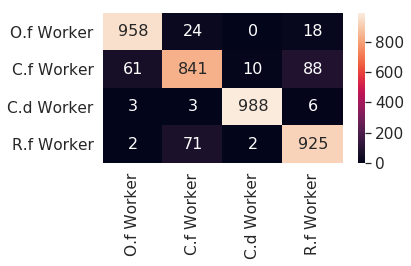


[26] accuracy: 0.929 loss: 15.709

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854]


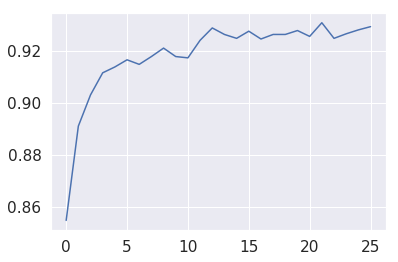

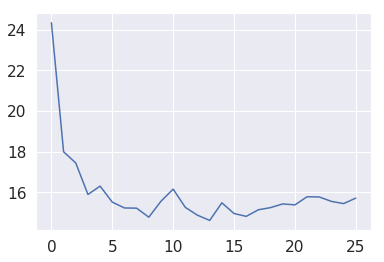

[0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 0, 2, 1, 3, 1, 3, 1, 3, 0, 0, 0, 3, 0, 0, 3, 0, 1, 1, 1, 1, 1, 3, 3, 1, 0, 1, 0, 3, 0, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 2, 0, 0, 3, 3, 1, 1, 3, 1, 0, 1, 1, 3, 2, 1, 3, 1, 1, 3, 1, 0, 3, 0, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 0, 0, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 0, 0, 1, 3, 1, 1, 0, 3, 0, 3, 1, 1, 0, 3, 1, 0, 3, 0, 3, 1, 3, 3, 3, 1, 0, 1, 0, 1, 0, 3, 3, 3, 2, 3, 1, 2, 0, 3, 3, 1, 1, 1, 0, 3, 1, 1, 1, 0, 3, 2, 0, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 0, 0, 1, 0, 3, 3, 1, 0, 1, 3, 0, 3, 1, 2, 0, 3, 3, 1, 1, 1, 0, 1, 1, 0, 3, 1, 3, 1, 1, 3, 3, 0, 3, 1, 3, 3, 0, 3, 1, 0, 1, 1, 1, 3, 0, 3, 3, 0, 3, 1, 1, 1, 1, 0, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 0, 1, 1, 0, 3, 0, 1, 1, 3, 1, 3, 1, 2, 2, 3, 1, 1, 0, 3, 1, 1, 1, 1, 0, 1, 0, 3, 2, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         943          32           1          24
C.f Worker          57         8

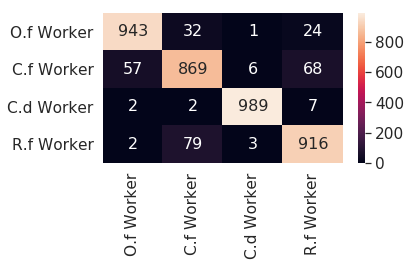


[27] accuracy: 0.925 loss: 15.484

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035]


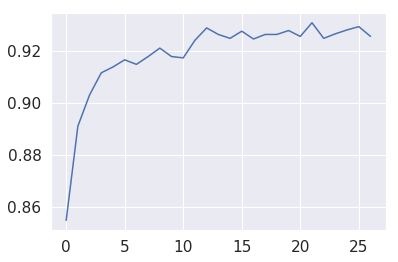

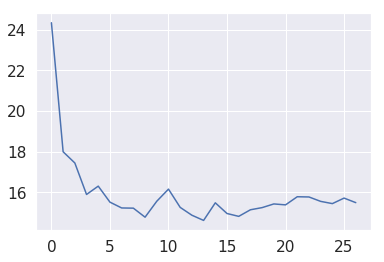

[3, 1, 3, 0, 2, 0, 1, 3, 3, 0, 1, 3, 3, 1, 0, 1, 3, 3, 0, 1, 1, 2, 3, 3, 2, 3, 3, 1, 0, 1, 0, 3, 3, 1, 2, 1, 1, 1, 3, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 2, 3, 1, 1, 3, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 2, 3, 1, 1, 3, 1, 3, 1, 0, 3, 3, 1, 0, 2, 1, 1, 3, 0, 1, 2, 2, 3, 2, 1, 0, 3, 1, 3, 3, 3, 0, 0, 0, 3, 0, 1, 0, 3, 0, 1, 3, 3, 0, 0, 1, 1, 3, 0, 1, 0, 0, 3, 0, 0, 3, 1, 3, 1, 3, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 1, 3, 3, 3, 1, 1, 2, 1, 3, 3, 3, 1, 1, 1, 1, 0, 3, 0, 1, 3, 0, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 0, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 0, 0, 3, 0, 0, 1, 2, 3, 1, 3, 0, 2, 3, 3, 1, 0, 0, 0, 3, 1, 1, 3, 3, 2, 3, 1, 1, 3, 3, 0, 1, 3, 1, 3, 0, 3, 1, 2, 1, 3, 1, 1, 0, 3, 3, 0, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 2, 1, 1, 0, 3, 3, 3, 3, 1, 0, 1, 0, 0, 2, 3, 1, 1, 3, 3, 0, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 0, 0, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 0, 1, 3, 0, 0, 1, 1, 1, 3, 1, 1, 0, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          25           1

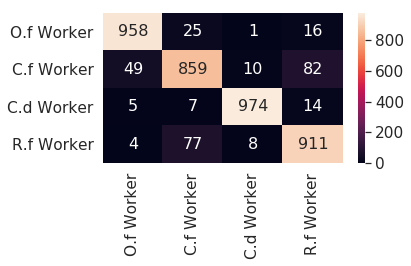


[28] accuracy: 0.927 loss: 16.863

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485]


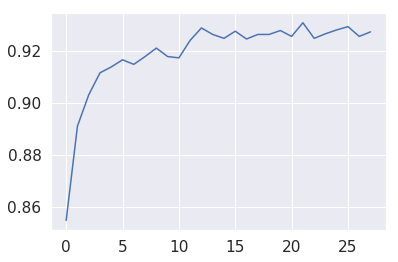

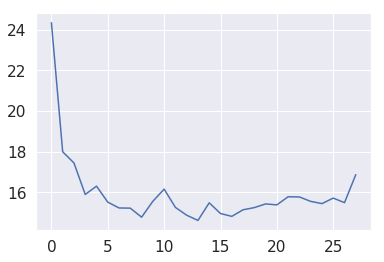

[0, 0, 0, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 2, 3, 2, 3, 3, 1, 0, 1, 1, 1, 3, 3, 0, 3, 2, 3, 0, 0, 1, 3, 3, 3, 3, 1, 0, 0, 0, 0, 1, 1, 3, 1, 2, 3, 0, 1, 0, 0, 0, 1, 1, 1, 0, 3, 0, 1, 3, 3, 3, 0, 3, 0, 3, 0, 1, 2, 1, 3, 3, 1, 2, 0, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 2, 0, 0, 1, 1, 3, 1, 3, 0, 0, 0, 0, 2, 1, 1, 3, 3, 0, 0, 3, 3, 0, 3, 2, 1, 3, 0, 3, 1, 1, 0, 1, 3, 1, 3, 0, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 2, 3, 1, 3, 1, 1, 1, 0, 3, 1, 1, 2, 0, 3, 0, 3, 3, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 3, 0, 3, 3, 2, 3, 0, 1, 1, 3, 3, 3, 0, 3, 1, 3, 1, 3, 0, 1, 3, 1, 1, 1, 1, 1, 2, 0, 2, 0, 3, 2, 3, 3, 3, 0, 1, 3, 0, 0, 0, 0, 1, 2, 1, 3, 1, 3, 1, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 2, 3, 1, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 0, 1, 3, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          22           0          23
C.f Work

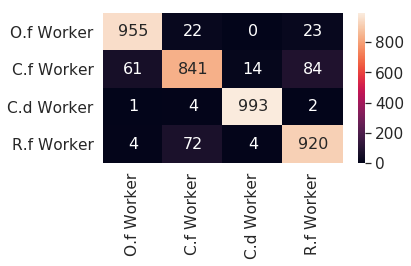


[29] accuracy: 0.926 loss: 15.545

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383]


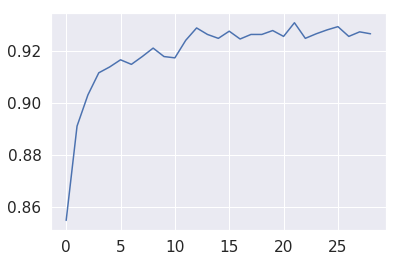

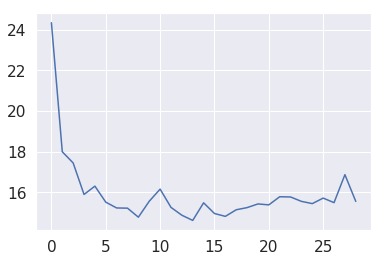

[2, 0, 0, 3, 3, 0, 1, 3, 2, 1, 3, 3, 1, 1, 1, 1, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 0, 2, 0, 1, 3, 3, 1, 0, 3, 3, 1, 1, 0, 3, 0, 3, 0, 0, 0, 3, 1, 1, 1, 3, 0, 0, 3, 3, 1, 1, 1, 3, 0, 1, 3, 1, 1, 0, 0, 3, 0, 0, 3, 1, 3, 1, 3, 3, 1, 1, 1, 0, 1, 2, 0, 3, 0, 3, 0, 1, 1, 3, 1, 0, 0, 0, 1, 1, 1, 2, 3, 3, 0, 0, 3, 3, 1, 3, 0, 3, 0, 3, 0, 0, 0, 1, 1, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 0, 0, 0, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 3, 1, 0, 0, 2, 3, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 3, 1, 3, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 3, 1, 3, 1, 3, 1, 1, 3, 0, 3, 2, 3, 3, 0, 1, 1, 3, 0, 3, 0, 0, 3, 1, 3, 3, 3, 3, 0, 1, 0, 3, 1, 0, 1, 3, 3, 3, 1, 3, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 0, 1, 1, 3, 1, 0, 1, 3, 3, 0, 1, 0, 2, 3, 0, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 2, 1, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          20           0          23

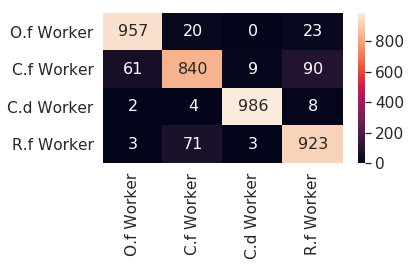


[30] accuracy: 0.925 loss: 16.682

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992]


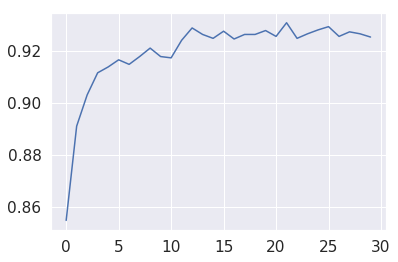

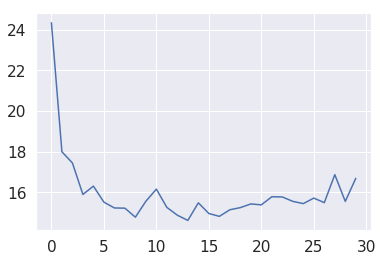

[1, 1, 3, 1, 1, 1, 0, 2, 0, 3, 0, 3, 1, 0, 3, 0, 3, 2, 2, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 3, 3, 1, 1, 2, 0, 0, 3, 0, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 0, 1, 3, 0, 3, 1, 0, 1, 2, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 0, 1, 3, 1, 1, 3, 1, 3, 3, 1, 2, 3, 2, 1, 3, 0, 1, 3, 3, 1, 3, 1, 1, 3, 0, 1, 1, 1, 3, 0, 0, 3, 1, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 3, 3, 0, 1, 2, 3, 3, 1, 1, 1, 3, 3, 1, 3, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 0, 3, 1, 0, 3, 3, 3, 0, 1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 0, 3, 0, 3, 1, 0, 1, 1, 3, 3, 0, 2, 3, 0, 0, 0, 3, 1, 0, 1, 3, 3, 0, 1, 0, 0, 1, 1, 1, 3, 2, 1, 0, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 0, 0, 3, 1, 3, 3, 0, 3, 3, 0, 3, 1, 3, 1, 3, 3, 3, 0, 3, 0, 3, 0, 3, 2, 2, 0, 0, 3, 0, 3, 3, 3, 2, 0, 0, 3, 1, 1, 3, 3, 1, 0, 0, 3, 3, 3, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          23         

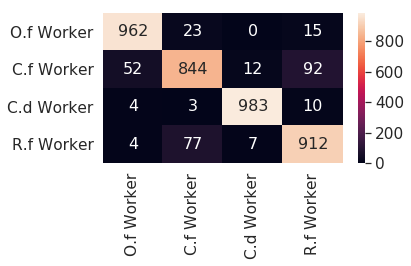


[31] accuracy: 0.927 loss: 15.760

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887]


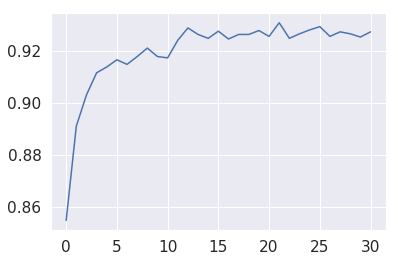

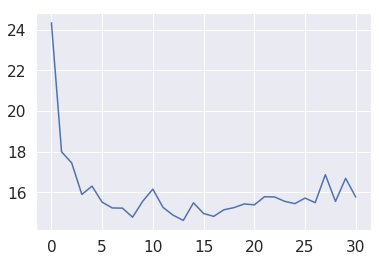

[0, 1, 1, 3, 0, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 3, 0, 3, 3, 1, 3, 0, 0, 0, 3, 3, 1, 2, 1, 3, 0, 1, 1, 1, 0, 3, 1, 3, 1, 3, 1, 0, 3, 3, 2, 3, 1, 1, 3, 3, 3, 3, 3, 0, 1, 1, 1, 3, 2, 3, 3, 1, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 2, 3, 0, 0, 3, 1, 0, 2, 0, 3, 3, 1, 1, 1, 1, 1, 2, 3, 0, 0, 0, 3, 3, 3, 3, 1, 3, 3, 0, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 0, 0, 1, 1, 1, 0, 3, 1, 1, 1, 3, 0, 3, 0, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 0, 1, 1, 3, 1, 2, 3, 3, 0, 1, 0, 0, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 1, 2, 0, 3, 0, 1, 3, 0, 0, 1, 1, 3, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 2, 3, 3, 1, 3, 1, 3, 2, 0, 1, 0, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 0, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 0, 0, 1, 3, 2, 1, 3, 3, 3, 3, 1, 0, 3, 0, 0, 3, 3, 1, 1, 1, 1, 1, 2, 3, 1, 0, 0, 0, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          21           0          19
C.f Work

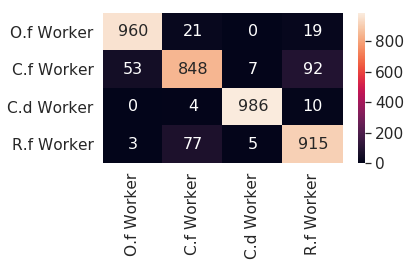


[32] accuracy: 0.925 loss: 16.576

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662]


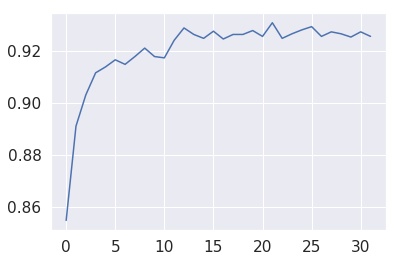

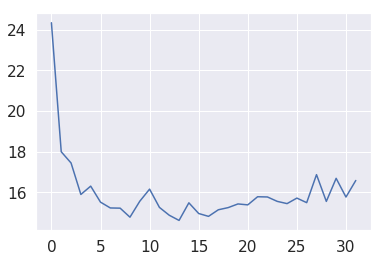

[2, 1, 3, 3, 3, 0, 2, 3, 1, 3, 0, 1, 3, 1, 1, 0, 1, 2, 0, 3, 3, 3, 0, 3, 3, 3, 1, 2, 3, 0, 1, 3, 3, 1, 0, 1, 0, 1, 0, 0, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 0, 0, 3, 3, 1, 3, 1, 1, 3, 2, 1, 0, 1, 3, 0, 2, 0, 3, 3, 1, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 2, 3, 0, 3, 3, 3, 1, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 3, 0, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 0, 0, 0, 0, 3, 1, 1, 0, 1, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 1, 1, 3, 0, 3, 3, 0, 0, 1, 1, 1, 3, 3, 1, 0, 0, 3, 1, 1, 3, 3, 0, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 3, 3, 0, 3, 1, 0, 1, 3, 3, 3, 1, 0, 0, 1, 0, 2, 3, 1, 3, 3, 1, 0, 3, 0, 1, 3, 1, 3, 1, 3, 1, 0, 0, 1, 1, 1, 2, 0, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 1, 1, 3, 2, 1, 2, 1, 1, 1, 3, 3, 2, 3, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 3, 3, 1, 0, 1, 3, 3, 1, 3, 0, 3, 1, 1, 0, 1, 1, 3, 3, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 3, 0, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          27           0

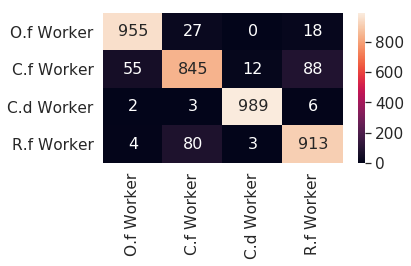


[33] accuracy: 0.925 loss: 16.668

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662, 16.667560514062643]


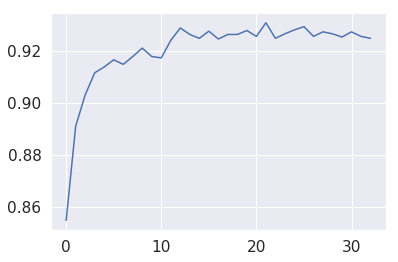

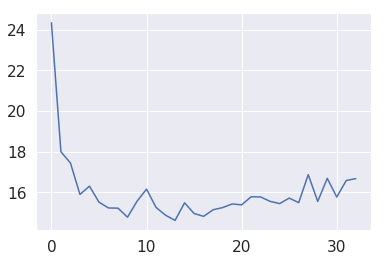

[1, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 1, 3, 0, 3, 3, 3, 0, 1, 1, 3, 1, 1, 3, 2, 3, 1, 3, 0, 0, 0, 0, 1, 0, 3, 1, 1, 3, 3, 0, 0, 1, 3, 1, 3, 3, 1, 1, 3, 0, 3, 3, 3, 2, 0, 2, 0, 0, 1, 3, 0, 0, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 3, 0, 1, 1, 0, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 1, 1, 3, 0, 1, 1, 1, 0, 1, 3, 3, 2, 0, 2, 0, 2, 3, 3, 2, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 1, 1, 3, 0, 3, 3, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 3, 1, 3, 3, 1, 1, 1, 1, 0, 3, 0, 3, 3, 3, 0, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 0, 1, 3, 0, 1, 3, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 3, 1, 3, 3, 0, 0, 3, 3, 0, 2, 3, 1, 3, 1, 3, 1, 0, 3, 0, 0, 3, 3, 3, 1, 2, 2, 2, 3, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 2, 3, 2, 0, 3, 0, 3, 0, 1, 1, 1, 3, 1, 2, 3, 0, 1, 1, 2, 1, 1, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 0, 1, 1, 3, 2, 3, 3, 3, 2, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         954          22   

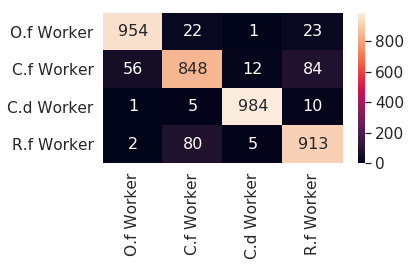


[34] accuracy: 0.927 loss: 16.568

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662, 16.667560514062643, 16.56811698898673]


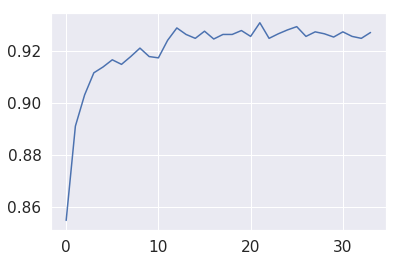

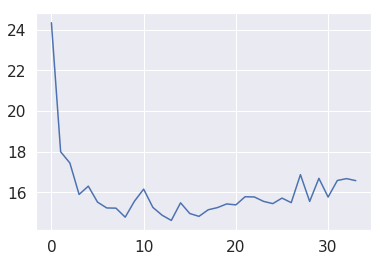

[0, 3, 1, 0, 1, 3, 3, 1, 3, 1, 0, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 3, 0, 1, 0, 3, 1, 1, 0, 3, 0, 1, 3, 1, 3, 0, 3, 3, 2, 3, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 1, 1, 3, 0, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 3, 0, 3, 0, 3, 2, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 0, 0, 0, 3, 1, 3, 3, 2, 3, 3, 3, 1, 0, 0, 1, 3, 1, 3, 0, 3, 1, 1, 3, 0, 0, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 2, 1, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 0, 0, 0, 3, 1, 1, 0, 0, 3, 1, 0, 1, 3, 1, 3, 1, 1, 1, 1, 3, 2, 0, 1, 2, 1, 1, 0, 3, 0, 1, 3, 3, 0, 3, 1, 0, 3, 3, 3, 1, 2, 2, 1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 0, 3, 0, 0, 0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 3, 1, 3, 0, 3, 3, 1, 1, 3, 1, 0, 2, 0, 1, 2, 3, 1, 3, 0, 1, 1, 3, 3, 0, 3, 0, 1, 3, 0, 1, 0, 1, 3, 1, 3, 1, 3, 3, 3, 0, 3, 3, 2, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 0, 1, 1, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         953          27           1          19
C.f W

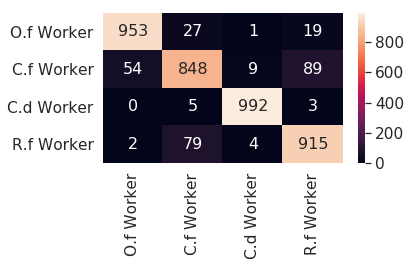


[35] accuracy: 0.927 loss: 16.645

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662, 16.667560514062643, 16.568116988986

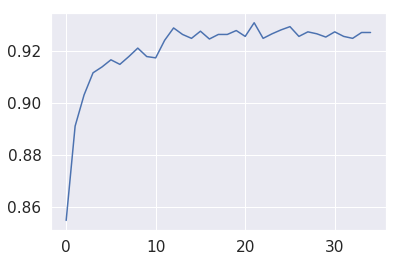

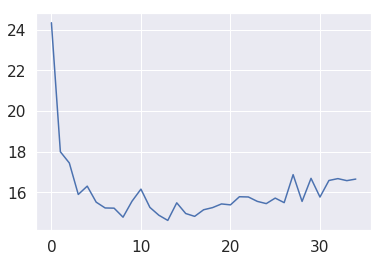

[1, 1, 3, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 2, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 0, 0, 1, 1, 0, 0, 3, 3, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 0, 0, 3, 0, 1, 3, 0, 3, 0, 3, 0, 2, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 1, 0, 3, 0, 3, 3, 3, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 1, 0, 1, 1, 0, 3, 1, 3, 2, 3, 0, 3, 1, 3, 0, 3, 0, 2, 3, 1, 1, 3, 1, 3, 2, 1, 2, 0, 0, 0, 3, 1, 1, 3, 1, 3, 1, 0, 0, 3, 3, 2, 1, 0, 1, 1, 1, 3, 0, 1, 3, 3, 2, 1, 3, 0, 1, 1, 3, 3, 0, 3, 1, 3, 3, 2, 1, 0, 3, 3, 0, 3, 1, 1, 2, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 1, 3, 1, 1, 0, 3, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 3, 1, 1, 0, 3, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 0, 0, 0, 1, 2, 3, 1, 3, 0, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 3, 3, 0, 1, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 1, 0, 3, 3, 1, 3, 3, 0, 1, 1, 3, 1, 3, 3, 3, 0, 1, 1, 1, 0, 0, 3, 1, 1, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          26           0          19
C.f W

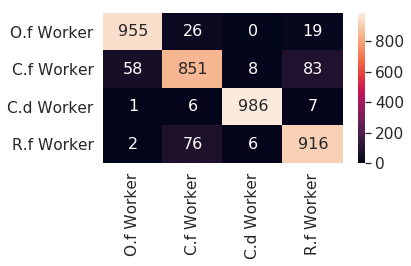


[36] accuracy: 0.928 loss: 16.059

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662, 16.667560514062643, 16.568

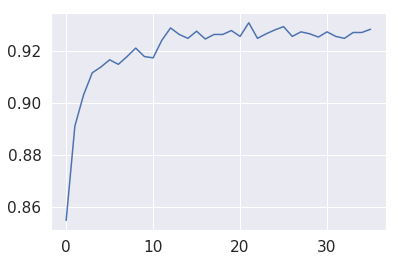

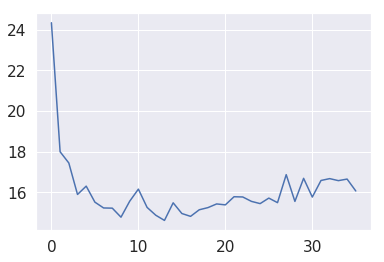

[3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 1, 1, 3, 3, 0, 1, 2, 3, 3, 1, 3, 1, 3, 0, 0, 0, 0, 0, 3, 3, 2, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 0, 0, 3, 0, 0, 3, 3, 1, 1, 0, 0, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 0, 0, 2, 0, 3, 3, 1, 1, 1, 3, 2, 0, 1, 0, 3, 3, 3, 0, 1, 1, 1, 3, 1, 0, 1, 3, 0, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 3, 1, 2, 1, 1, 1, 3, 3, 0, 1, 1, 2, 1, 2, 3, 0, 1, 3, 0, 1, 0, 3, 1, 0, 1, 3, 0, 0, 3, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 3, 2, 1, 1, 2, 1, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 0, 0, 2, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 0, 0, 0, 1, 0, 3, 2, 2, 0, 0, 1, 1, 0, 0, 3, 1, 3, 3, 0, 3, 2, 1, 0, 3, 1, 0, 1, 0, 3, 1, 0, 1, 3, 3, 1, 3, 0, 1, 1, 3, 3, 1, 3, 0, 2, 3, 2, 3, 0, 1, 2, 3, 3, 1, 0, 1, 1, 3, 0, 0, 3, 3, 1, 3, 3, 2, 0, 3, 3, 3, 0, 2, 3, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 0, 1, 2, 1, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         953          17           2          28
C.f Worker          

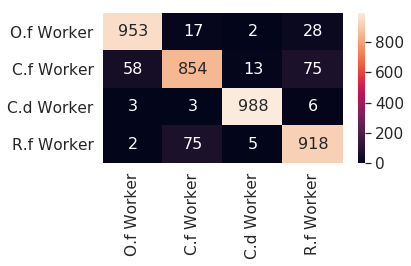


[37] accuracy: 0.928 loss: 16.002

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662, 16.66756051406264

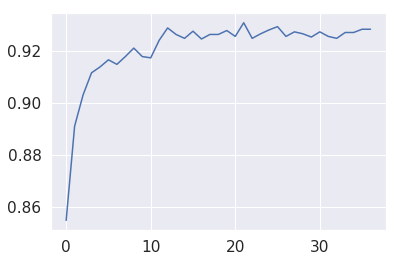

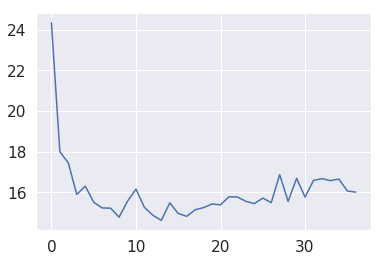

[1, 1, 3, 3, 1, 1, 0, 1, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 1, 3, 0, 3, 3, 1, 1, 3, 3, 0, 1, 3, 1, 1, 0, 3, 3, 2, 0, 1, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 1, 0, 3, 0, 3, 2, 1, 3, 3, 3, 1, 0, 3, 3, 0, 1, 3, 3, 2, 1, 0, 3, 0, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 0, 3, 3, 2, 0, 1, 0, 2, 1, 3, 1, 3, 0, 2, 3, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 0, 1, 3, 0, 3, 3, 0, 1, 1, 3, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 1, 3, 2, 3, 1, 3, 0, 3, 3, 3, 3, 2, 2, 0, 1, 1, 1, 1, 3, 2, 3, 3, 3, 3, 1, 1, 0, 0, 0, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 0, 3, 1, 1, 3, 1, 2, 3, 1, 1, 3, 3, 3, 0, 0, 1, 3, 3, 0, 0, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 0, 3, 2, 3, 1, 0, 0, 0, 0, 2, 3, 3, 0, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         945          30           0          25
C.f Worker          

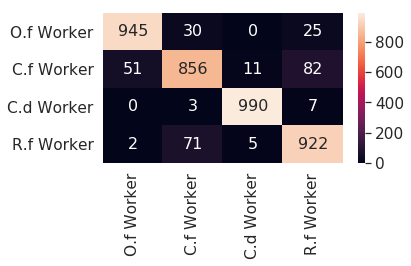


[38] accuracy: 0.929 loss: 16.376

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662, 16.66756

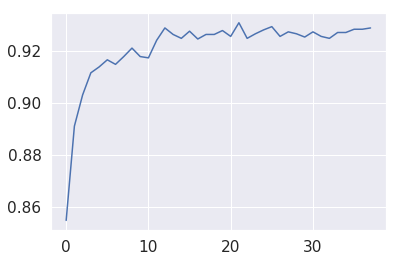

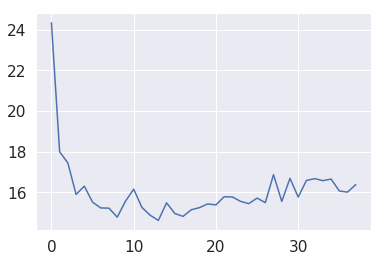

[0, 0, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 1, 0, 1, 2, 0, 1, 1, 2, 1, 3, 3, 1, 0, 0, 3, 0, 1, 3, 1, 1, 3, 1, 3, 0, 0, 3, 3, 1, 1, 3, 3, 3, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 0, 1, 1, 3, 1, 0, 3, 3, 0, 1, 3, 3, 1, 0, 0, 0, 1, 3, 3, 1, 1, 1, 1, 1, 0, 0, 1, 0, 3, 3, 2, 3, 0, 1, 1, 0, 0, 3, 2, 3, 3, 3, 0, 1, 0, 1, 3, 2, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 0, 3, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 0, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 2, 3, 3, 1, 0, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 0, 3, 0, 1, 1, 3, 3, 0, 1, 3, 3, 1, 1, 1, 3, 3, 0, 2, 1, 1, 1, 1, 3, 1, 3, 1, 1, 2, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 0, 1, 0, 0, 3, 3, 2, 3, 3, 1, 1, 2, 3, 0, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 3, 3, 1, 2, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 2, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         953          27           0          20
C.f Worker          53    

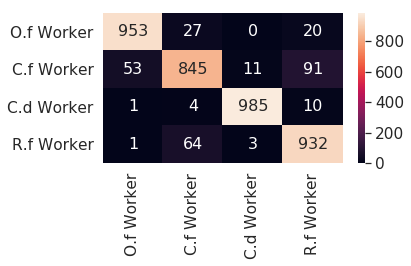


[39] accuracy: 0.929 loss: 16.412

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089989662, 

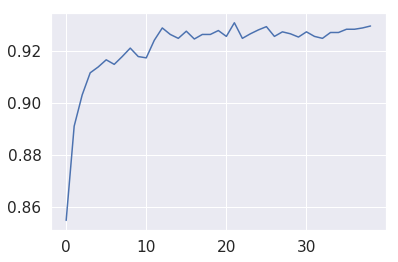

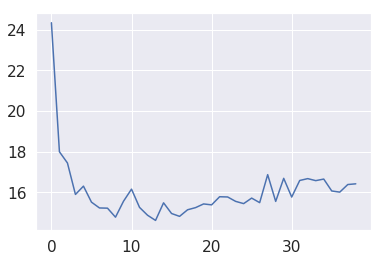

[3, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3, 1, 1, 3, 0, 3, 3, 1, 2, 3, 1, 1, 1, 2, 3, 3, 3, 2, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 1, 3, 1, 0, 1, 1, 0, 0, 1, 1, 3, 1, 1, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3, 3, 1, 3, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 0, 3, 0, 1, 0, 3, 2, 1, 3, 3, 2, 0, 1, 3, 3, 3, 2, 1, 3, 3, 1, 3, 3, 2, 3, 0, 3, 3, 1, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 0, 1, 3, 3, 0, 1, 3, 0, 3, 3, 3, 3, 3, 0, 1, 1, 0, 1, 3, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 3, 0, 1, 1, 0, 1, 0, 1, 0, 1, 3, 3, 0, 1, 0, 1, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 0, 0, 3, 1, 1, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 2, 1, 1, 1, 0, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 2, 0, 0, 1, 3, 3, 0, 0, 2, 3, 3, 0, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 1, 2, 1, 3, 1, 3, 1, 3, 0, 1, 1, 1, 3, 3, 1, 3, 3, 3, 2, 1, 2, 1, 0, 3, 3, 1, 1, 2, 1, 0, 0, 3, 0, 3, 3, 3, 3, 0, 0, 3, 0, 0, 3, 0, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         961          25           0          14
C.f Worker          61         843 

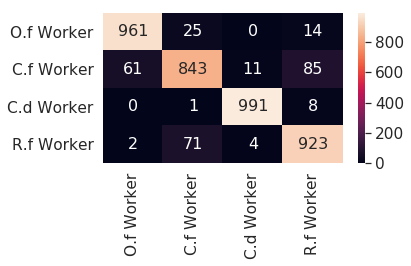


[40] accuracy: 0.924 loss: 16.136

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.576214089

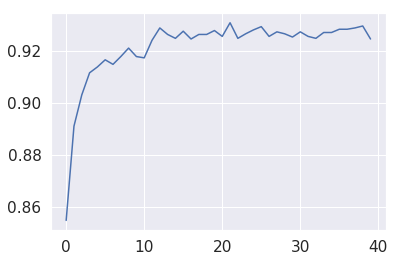

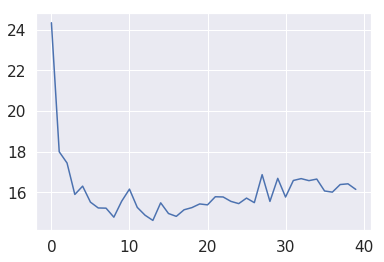

[3, 3, 3, 0, 3, 0, 1, 0, 1, 1, 0, 2, 3, 0, 1, 1, 0, 3, 3, 1, 1, 0, 2, 0, 0, 3, 0, 1, 3, 0, 1, 3, 3, 3, 0, 0, 0, 0, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 3, 1, 0, 2, 0, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 0, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 3, 3, 1, 3, 0, 1, 0, 3, 0, 2, 3, 1, 3, 1, 2, 3, 0, 1, 1, 0, 1, 3, 1, 2, 0, 0, 3, 0, 1, 0, 1, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 2, 3, 3, 0, 2, 3, 1, 3, 3, 1, 1, 3, 3, 2, 1, 0, 0, 3, 1, 0, 3, 3, 2, 0, 1, 1, 1, 2, 3, 2, 3, 0, 1, 3, 3, 1, 0, 1, 3, 1, 0, 0, 0, 0, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 3, 1, 0, 1, 3, 1, 1, 1, 3, 0, 3, 3, 0, 3, 1, 3, 1, 2, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 0, 3, 3, 1, 1, 2, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 0, 0, 1, 3, 3, 2, 3, 1, 1, 3, 1, 0, 3, 3, 0, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 0, 3, 3, 3, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         948          33

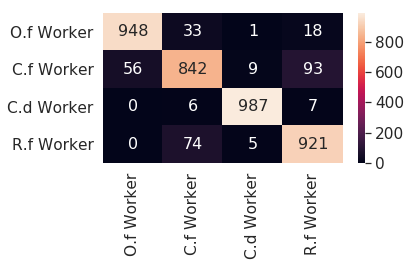


[41] accuracy: 0.925 loss: 16.554

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.759668480604887, 16.

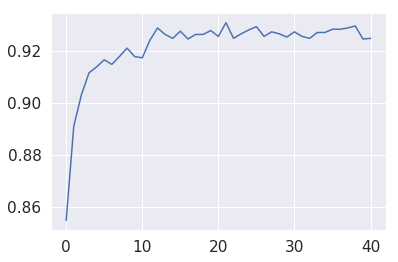

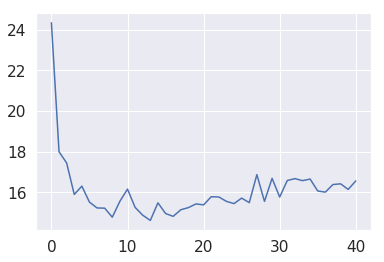

[1, 3, 1, 1, 3, 0, 3, 1, 0, 3, 0, 1, 3, 1, 0, 3, 2, 3, 1, 3, 0, 3, 3, 1, 3, 3, 0, 1, 2, 3, 3, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 3, 0, 2, 3, 0, 1, 1, 3, 1, 0, 1, 3, 1, 2, 1, 1, 1, 3, 0, 0, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 2, 0, 1, 3, 3, 1, 0, 3, 0, 3, 0, 3, 1, 3, 0, 0, 1, 1, 0, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 2, 0, 1, 3, 0, 1, 3, 1, 3, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 0, 3, 1, 1, 3, 0, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 3, 3, 3, 0, 3, 3, 3, 0, 1, 1, 0, 2, 0, 1, 3, 1, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 2, 3, 2, 1, 0, 3, 1, 2, 1, 2, 2, 3, 1, 0, 3, 3, 1, 0, 1, 3, 2, 3, 3, 1, 1, 3, 1, 3, 1, 0, 0, 1, 3, 0, 0, 3, 1, 0, 1, 3, 3, 1, 2, 3, 3, 3, 1, 1, 0, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 3, 1, 0, 3, 1, 1, 3, 3, 0, 0, 0, 3, 1, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 2, 0, 0, 0, 3, 1, 1, 3, 0, 3, 1, 3, 3, 0, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         947          28   

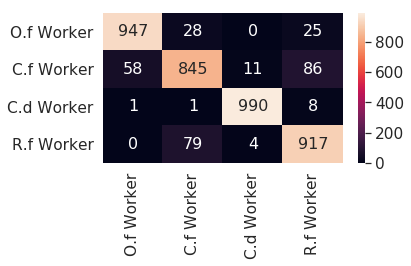


[42] accuracy: 0.928 loss: 16.660

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.75966848060

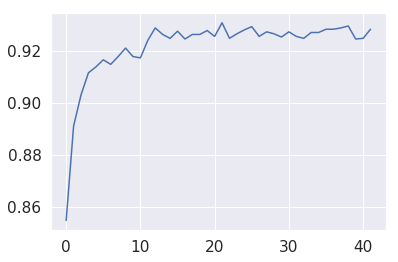

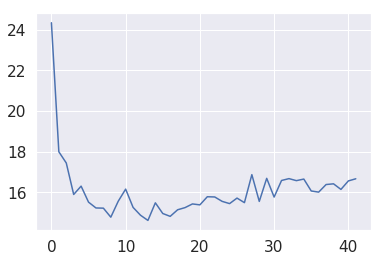

[3, 1, 0, 0, 3, 0, 0, 3, 2, 0, 0, 0, 1, 1, 1, 0, 3, 3, 1, 3, 3, 0, 0, 0, 3, 1, 0, 1, 2, 3, 1, 1, 0, 1, 0, 1, 3, 1, 0, 3, 2, 2, 1, 0, 3, 3, 3, 1, 0, 0, 0, 2, 2, 3, 3, 3, 1, 3, 1, 3, 0, 0, 1, 3, 0, 0, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 0, 3, 1, 3, 1, 1, 1, 0, 3, 3, 1, 3, 0, 0, 1, 1, 1, 0, 0, 0, 3, 3, 1, 1, 1, 3, 1, 2, 1, 3, 3, 3, 1, 3, 0, 3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 0, 3, 1, 1, 3, 0, 1, 3, 0, 3, 1, 2, 1, 3, 1, 1, 1, 3, 0, 1, 3, 0, 0, 1, 3, 1, 1, 3, 0, 2, 0, 0, 1, 3, 1, 0, 1, 3, 1, 0, 3, 1, 1, 0, 2, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 0, 2, 1, 3, 1, 3, 3, 2, 0, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 1, 0, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 2, 0, 1, 0, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 3, 1, 1, 0, 3, 2, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          31           0          11
C.f Worker          

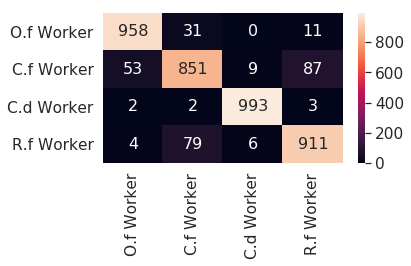


[43] accuracy: 0.925 loss: 16.864

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992, 15.75

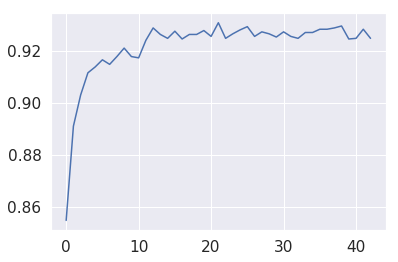

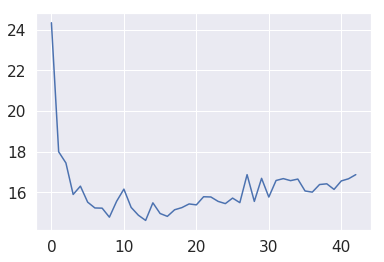

[0, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 1, 1, 3, 3, 1, 3, 0, 1, 1, 1, 0, 1, 3, 3, 0, 1, 3, 1, 1, 3, 3, 3, 0, 1, 1, 1, 0, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 0, 0, 3, 1, 1, 1, 3, 3, 0, 1, 2, 3, 1, 1, 1, 2, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 3, 1, 3, 1, 1, 0, 1, 3, 3, 3, 0, 3, 3, 2, 1, 1, 3, 3, 3, 0, 0, 3, 1, 0, 3, 1, 1, 3, 3, 3, 0, 1, 0, 3, 3, 3, 0, 1, 3, 0, 3, 3, 1, 1, 0, 1, 3, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 3, 2, 3, 1, 3, 2, 3, 3, 3, 0, 3, 1, 3, 3, 1, 0, 3, 3, 3, 1, 1, 0, 3, 0, 3, 0, 1, 3, 3, 3, 0, 3, 1, 1, 0, 1, 2, 0, 2, 3, 0, 3, 3, 1, 0, 3, 1, 0, 1, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 0, 1, 1, 0, 2, 3, 3, 2, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 0, 3, 0, 0, 1, 1, 2, 1, 0, 3, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 3, 0, 0, 1, 3, 1, 3, 0, 0, 3, 3, 3, 1, 3, 0, 0, 3, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         951          29   

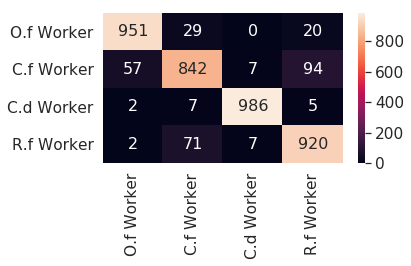


[44] accuracy: 0.931 loss: 16.406

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666739284992

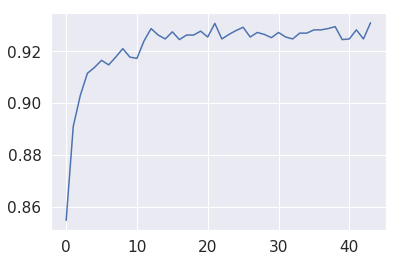

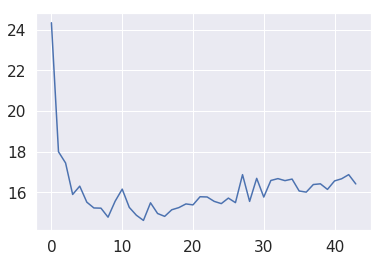

[0, 0, 2, 3, 0, 2, 1, 0, 0, 3, 3, 3, 1, 3, 3, 0, 2, 3, 3, 0, 3, 3, 3, 0, 1, 1, 2, 1, 1, 2, 3, 3, 3, 1, 3, 1, 1, 3, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 0, 0, 0, 3, 1, 2, 3, 3, 0, 1, 0, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 3, 2, 0, 0, 2, 3, 3, 1, 1, 0, 3, 3, 0, 1, 0, 3, 3, 0, 3, 1, 1, 3, 1, 1, 3, 1, 0, 1, 3, 3, 1, 1, 0, 0, 1, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 0, 3, 3, 3, 0, 1, 1, 1, 0, 0, 3, 2, 1, 3, 0, 3, 0, 3, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 3, 0, 1, 0, 3, 1, 3, 0, 3, 3, 2, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3, 0, 0, 0, 1, 2, 1, 1, 1, 3, 1, 3, 1, 1, 2, 0, 1, 0, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 2, 1, 3, 3, 1, 0, 3, 1, 0, 3, 3, 3, 3, 3, 0, 1, 0, 0, 0, 1, 3, 1, 1, 1, 0, 3, 1, 3, 1, 0, 3, 2, 1, 1, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          24           0          14
C.f Worker          64         841          10       

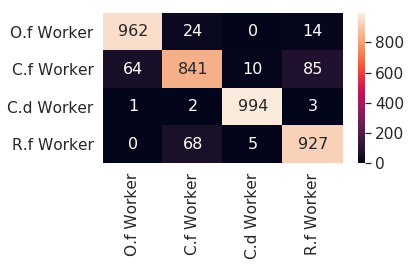


[45] accuracy: 0.934 loss: 16.965

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 16.681666

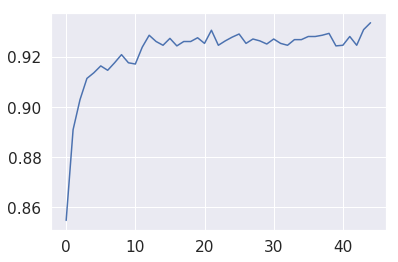

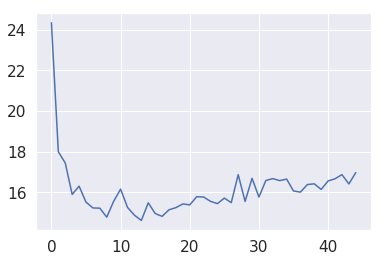

[1, 0, 0, 0, 1, 3, 1, 2, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 2, 3, 3, 1, 2, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 0, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 3, 0, 0, 0, 3, 3, 1, 3, 0, 2, 1, 2, 1, 2, 3, 1, 1, 0, 0, 3, 1, 0, 1, 1, 3, 2, 0, 1, 3, 3, 0, 3, 1, 3, 1, 1, 0, 1, 3, 0, 3, 3, 3, 0, 3, 1, 1, 0, 3, 2, 3, 2, 2, 1, 0, 0, 1, 1, 1, 3, 1, 1, 0, 3, 1, 1, 2, 1, 3, 1, 2, 3, 3, 0, 1, 1, 0, 3, 0, 0, 3, 1, 3, 0, 1, 1, 1, 3, 2, 0, 0, 3, 1, 3, 3, 1, 1, 1, 0, 1, 0, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 0, 0, 3, 0, 2, 3, 3, 3, 3, 1, 0, 0, 1, 3, 3, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 0, 3, 0, 1, 0, 1, 3, 0, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 3, 3, 1, 3, 0, 0, 3, 3, 0, 1, 1, 0, 3, 1, 3, 1, 1, 0, 3, 3, 3, 0, 0, 1, 3, 0, 3, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         965          19           0          16
C.f Worker          53         852          10          85
C.d Worker           0     

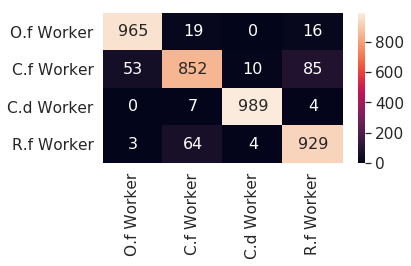


[46] accuracy: 0.931 loss: 16.047

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651476383, 

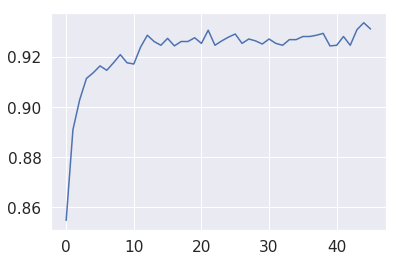

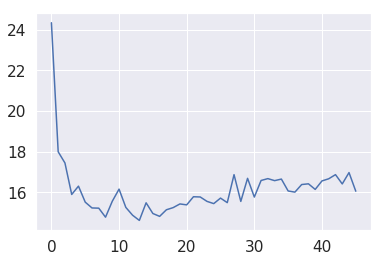

[1, 3, 1, 3, 0, 1, 1, 3, 0, 0, 0, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 2, 0, 1, 1, 3, 3, 0, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 1, 1, 3, 1, 3, 0, 3, 1, 0, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 2, 0, 0, 3, 1, 3, 1, 0, 0, 3, 0, 1, 3, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 3, 1, 1, 3, 1, 0, 3, 1, 1, 3, 0, 1, 2, 0, 1, 1, 3, 3, 3, 1, 0, 0, 1, 1, 3, 0, 3, 1, 0, 1, 3, 0, 0, 0, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 0, 3, 3, 1, 1, 1, 2, 1, 0, 1, 0, 1, 3, 0, 0, 3, 1, 3, 0, 1, 1, 1, 3, 3, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 3, 1, 1, 1, 3, 3, 1, 2, 1, 1, 3, 3, 1, 1, 0, 2, 3, 3, 1, 1, 3, 1, 0, 0, 1, 3, 3, 3, 2, 1, 0, 1, 0, 3, 1, 3, 3, 0, 1, 0, 1, 1, 3, 1, 0, 1, 2, 0, 2, 2, 3, 3, 1, 1, 0, 3, 1, 3, 3, 3, 1, 0, 1, 0, 1, 3, 1, 0, 0, 1, 3, 3, 3, 0, 3, 3, 1, 1, 1, 3, 1, 0, 0, 1, 1, 0, 3, 0, 3, 0, 2]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         959          23           0          18
C.f Worker          59         855          10          

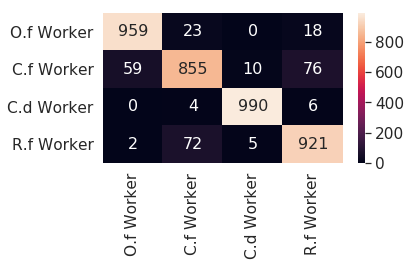


[47] accuracy: 0.933 loss: 15.843

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.545440651

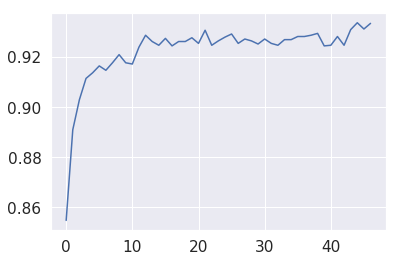

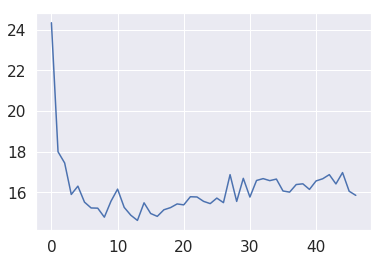

[3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 0, 0, 0, 0, 3, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 0, 3, 2, 1, 3, 3, 0, 3, 1, 2, 3, 3, 1, 3, 0, 0, 0, 0, 3, 3, 3, 1, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 0, 0, 3, 2, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 0, 3, 3, 1, 3, 0, 1, 3, 1, 2, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 3, 0, 0, 0, 3, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 0, 3, 0, 1, 0, 3, 0, 3, 0, 0, 1, 1, 1, 1, 1, 3, 3, 0, 0, 0, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 0, 3, 1, 3, 1, 3, 3, 0, 0, 1, 1, 0, 0, 1, 3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 3, 0, 1, 1, 0, 0, 3, 1, 1, 3, 1, 3, 1, 3, 2, 1, 3, 3, 0, 1, 1, 2, 0, 1, 3, 2, 1, 3, 3, 1, 0, 3, 1, 1, 0, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 0, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         966          19           0          15
C.f Worker          60         858           8          74
C.d Worker           0  

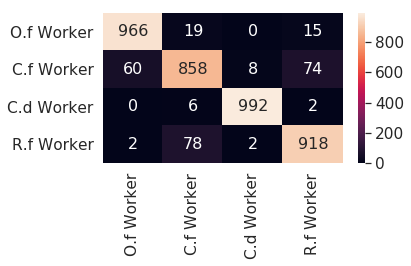


[48] accuracy: 0.934 loss: 16.030

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862952176481485, 15.

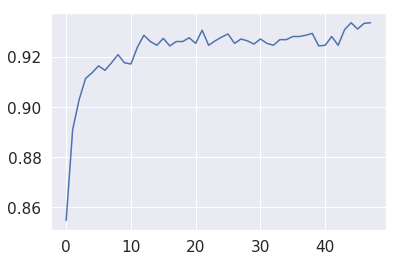

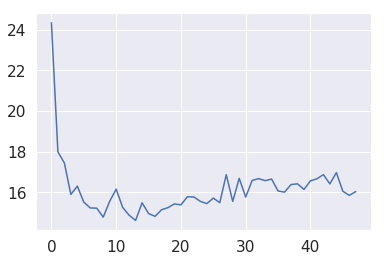

[1, 1, 0, 0, 0, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 2, 0, 3, 1, 3, 1, 3, 1, 2, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 0, 0, 3, 1, 2, 3, 0, 0, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 0, 1, 3, 1, 0, 3, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 3, 1, 3, 0, 1, 3, 0, 1, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 0, 2, 3, 3, 3, 3, 1, 0, 1, 1, 0, 3, 1, 0, 0, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 2, 1, 3, 0, 3, 3, 1, 0, 2, 3, 0, 0, 2, 1, 0, 0, 3, 3, 0, 1, 3, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 0, 2, 3, 0, 1, 2, 0, 3, 1, 1, 3, 1, 0, 3, 1, 3, 3, 1, 0, 1, 0, 3, 2, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 2, 1, 3, 0, 0, 3, 1, 2, 3, 1, 2, 3, 3, 3, 3, 1, 1, 1, 3, 2, 3, 3, 1, 1, 3, 1, 3, 0, 1, 1, 0, 2, 1, 3, 0, 1, 0, 0, 0, 1, 1, 0, 3, 3, 3, 3, 1, 3, 0, 1, 0, 0, 3, 0, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 1, 3, 1, 3, 0, 3, 0, 3, 1, 3, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          21           1          16
C.f Worker          56         852          14          78
C.d Worker           0     

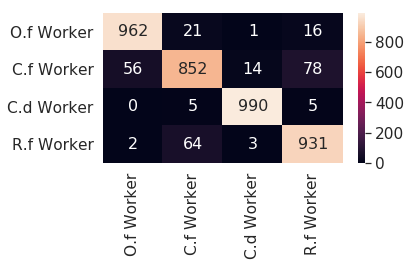


[49] accuracy: 0.931 loss: 15.852

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.86295217648

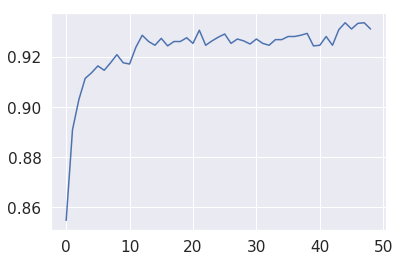

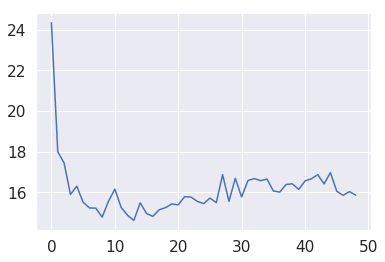

[0, 1, 0, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 0, 1, 0, 3, 0, 0, 1, 0, 0, 1, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 3, 1, 3, 0, 1, 1, 1, 0, 3, 1, 1, 1, 3, 0, 3, 1, 1, 3, 0, 0, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 3, 3, 3, 1, 1, 3, 0, 1, 3, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 3, 1, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 0, 1, 0, 0, 0, 2, 3, 3, 1, 1, 2, 0, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 1, 0, 1, 1, 0, 1, 0, 3, 1, 0, 1, 0, 2, 1, 3, 1, 3, 3, 0, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 0, 2, 0, 3, 0, 0, 0, 1, 1, 3, 3, 3, 3, 0, 1, 1, 3, 2, 0, 1, 3, 3, 0, 1, 1, 3, 0, 1, 1, 0, 2, 3, 3, 0, 3, 3, 3, 3, 3, 0, 1, 3, 3, 0, 3, 0, 3, 3, 1, 1, 2, 1, 3, 1, 0, 0, 2, 1, 3, 0, 3, 1, 0, 1, 3, 1, 0, 0, 1, 0, 1, 1, 1, 2, 1, 3, 0, 0, 0, 3, 0, 1, 0, 3, 3, 1, 1, 1, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         966          19           0          15
C.f Worker          59         848           9          

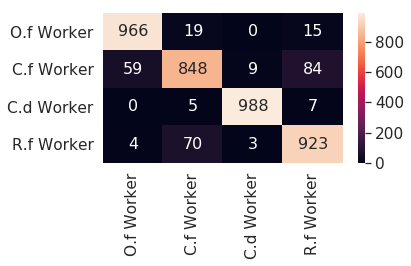


[50] accuracy: 0.931 loss: 16.628

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.484464187175035, 16.862

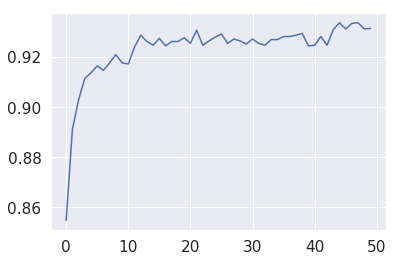

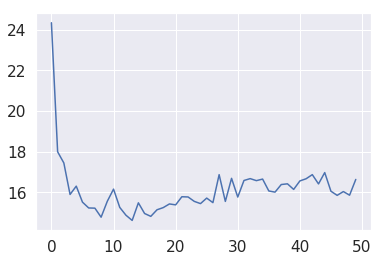

[1, 1, 1, 1, 3, 3, 1, 1, 0, 3, 0, 1, 0, 0, 1, 0, 1, 1, 3, 3, 3, 0, 0, 1, 0, 1, 3, 1, 1, 1, 3, 0, 2, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 0, 0, 1, 0, 3, 1, 1, 2, 0, 0, 3, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 1, 1, 2, 0, 0, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 0, 0, 2, 1, 1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 1, 1, 2, 3, 0, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 0, 1, 2, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 0, 0, 3, 3, 1, 0, 1, 2, 3, 0, 1, 3, 1, 0, 3, 0, 3, 0, 0, 0, 3, 2, 0, 0, 3, 3, 1, 1, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 0, 0, 3, 3, 1, 3, 3, 0, 1, 3, 3, 2, 3, 2, 3, 3, 0, 0, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 0, 0, 2, 3, 3, 0, 0, 3, 2, 1, 0, 1, 0, 3, 0, 1, 1, 0, 3, 0, 0, 0, 1, 1, 1, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          23           1          16
C.f Worker          55         864          10          71


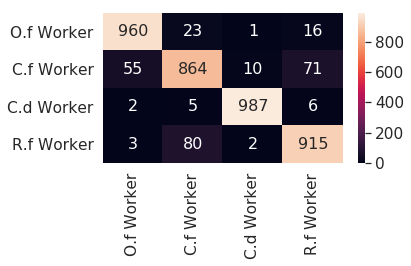


[51] accuracy: 0.930 loss: 16.231

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.48446418717503

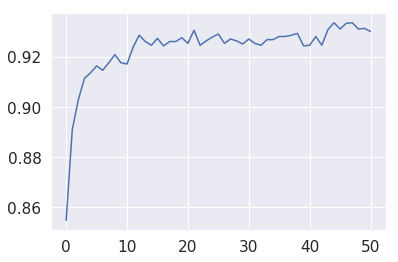

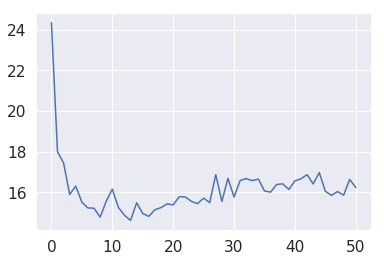

[1, 3, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 3, 1, 3, 3, 2, 3, 3, 1, 3, 0, 0, 1, 3, 1, 0, 0, 1, 3, 3, 1, 0, 0, 3, 1, 3, 0, 1, 0, 1, 3, 3, 2, 3, 2, 0, 1, 1, 1, 1, 3, 1, 3, 3, 0, 0, 1, 0, 3, 3, 1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 0, 0, 1, 0, 3, 3, 0, 3, 0, 1, 3, 1, 3, 1, 0, 3, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 1, 3, 3, 1, 1, 0, 0, 1, 1, 2, 3, 0, 3, 3, 3, 1, 0, 0, 3, 0, 2, 3, 1, 3, 1, 3, 0, 1, 0, 0, 2, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 3, 1, 3, 1, 0, 0, 1, 1, 1, 1, 0, 1, 3, 0, 3, 3, 1, 3, 1, 0, 1, 0, 1, 1, 0, 2, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 3, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 3, 3, 0, 0, 1, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 1, 0, 3, 1, 3, 1, 3, 3, 1, 3, 0, 2, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         967          22           0          11
C.f Worker          61         848          

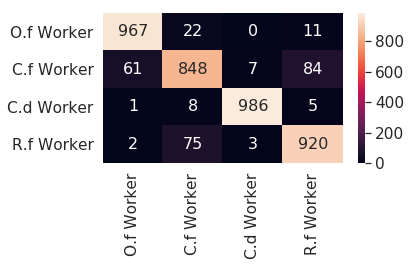


[52] accuracy: 0.929 loss: 16.835

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854, 15.48446

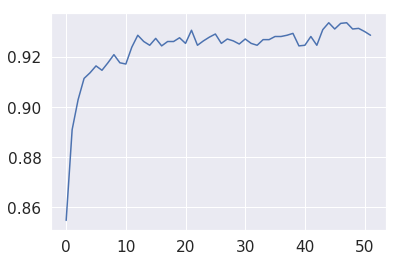

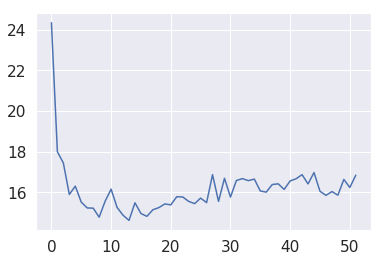

[1, 3, 1, 1, 0, 1, 2, 3, 0, 3, 0, 1, 1, 0, 3, 0, 3, 1, 1, 1, 3, 1, 1, 3, 2, 1, 0, 3, 3, 3, 3, 0, 3, 1, 1, 1, 0, 0, 3, 2, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 1, 3, 3, 0, 3, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 3, 2, 2, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 1, 3, 0, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 3, 1, 1, 1, 0, 0, 1, 0, 0, 0, 3, 0, 3, 3, 3, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 2, 1, 3, 3, 1, 0, 1, 0, 0, 2, 3, 3, 1, 3, 0, 3, 1, 1, 1, 0, 1, 1, 0, 1, 2, 3, 1, 0, 2, 3, 0, 3, 1, 3, 1, 0, 3, 1, 3, 0, 2, 1, 1, 0, 3, 2, 0, 2, 1, 1, 3, 3, 0, 3, 1, 0, 1, 1, 3, 1, 3, 0, 3, 1, 0, 0, 1, 0, 3, 3, 3, 2, 1, 3, 1, 0, 0, 0, 1, 1, 1, 3, 0, 3, 3, 3, 0, 1, 0, 1, 3, 3, 1, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 3, 1, 1, 0, 3, 0, 0, 0, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         961          26           0          13
C.f Worker          56    

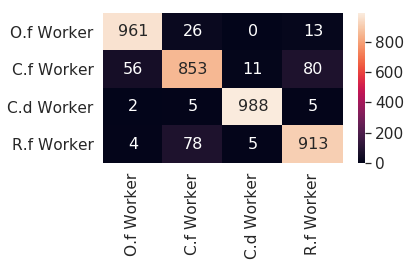


[53] accuracy: 0.930 loss: 16.336

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210829854,

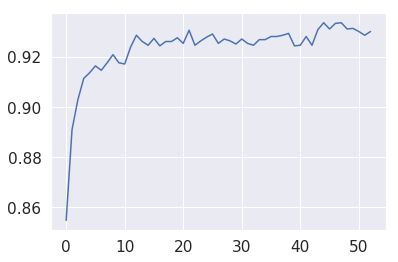

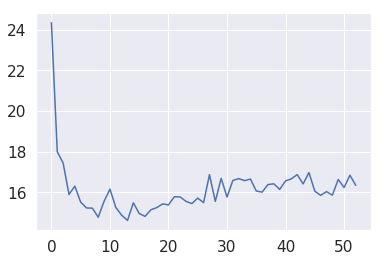

[0, 3, 0, 3, 3, 0, 3, 0, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 0, 0, 3, 1, 1, 3, 3, 1, 3, 0, 0, 3, 0, 1, 3, 1, 1, 2, 0, 1, 3, 1, 0, 1, 0, 3, 3, 2, 1, 1, 2, 3, 3, 0, 3, 1, 1, 1, 0, 2, 3, 3, 1, 0, 0, 0, 1, 3, 2, 3, 0, 1, 1, 3, 0, 3, 1, 1, 0, 0, 1, 0, 3, 3, 0, 3, 0, 1, 0, 1, 0, 3, 1, 1, 2, 3, 3, 3, 1, 0, 3, 3, 1, 1, 0, 1, 0, 1, 2, 1, 1, 3, 3, 2, 3, 3, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 2, 0, 1, 3, 3, 3, 3, 3, 1, 0, 1, 0, 0, 3, 3, 3, 3, 1, 3, 0, 2, 3, 1, 0, 1, 3, 1, 1, 1, 1, 0, 1, 3, 3, 0, 1, 1, 3, 3, 3, 1, 1, 1, 1, 2, 1, 0, 3, 1, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 3, 0, 3, 3, 0, 3, 3, 0, 1, 3, 0, 3, 1, 3, 0, 1, 1, 0, 1, 0, 0, 3, 3, 1, 3, 1, 1, 2, 1, 1, 3, 0, 3, 0, 1, 1, 1, 1, 1, 3, 3, 3, 0, 0, 1, 2, 1, 0, 0, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 3, 1, 3, 2, 0, 1, 0, 3, 3, 0, 1, 1, 1, 1, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         956          21           0          23
C.f Worker          57         858          

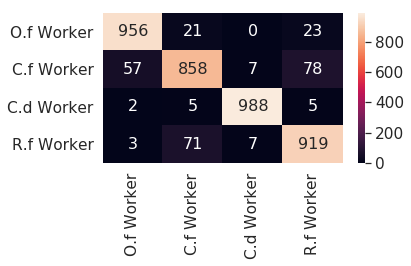


[54] accuracy: 0.934 loss: 15.776

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.70857210

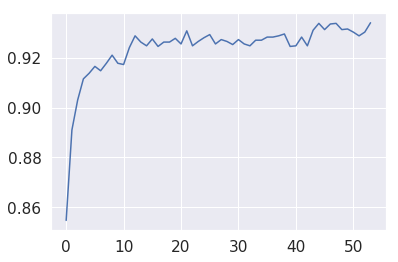

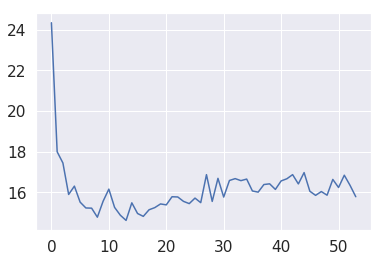

[1, 0, 3, 3, 0, 1, 3, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 1, 3, 0, 0, 0, 1, 1, 0, 2, 1, 1, 2, 3, 3, 0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 0, 0, 0, 0, 1, 0, 3, 2, 2, 0, 0, 1, 2, 3, 0, 1, 3, 1, 1, 2, 3, 3, 1, 1, 1, 1, 2, 3, 0, 3, 3, 1, 3, 3, 0, 1, 0, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 0, 2, 1, 0, 3, 3, 3, 3, 0, 3, 1, 3, 0, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 0, 0, 1, 0, 0, 1, 3, 1, 1, 0, 0, 1, 1, 3, 0, 1, 0, 1, 3, 0, 1, 1, 1, 3, 0, 3, 0, 1, 1, 3, 0, 1, 0, 3, 1, 0, 0, 3, 0, 2, 1, 2, 1, 3, 3, 3, 3, 1, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3, 3, 1, 0, 1, 1, 1, 0, 1, 3, 3, 2, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 0, 0, 1, 1, 3, 0, 3, 3, 3, 1, 0, 3, 0, 1, 0, 0, 0, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 3, 3, 1, 0, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         965          19           1          15
C.f Worker          58         858           8          76
C.d Worker           1        

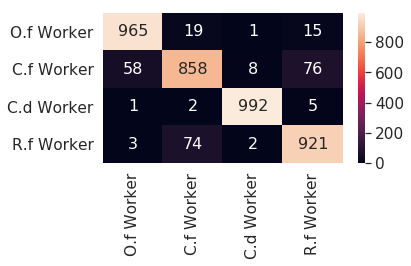


[55] accuracy: 0.933 loss: 16.162

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.436833936721087, 15.

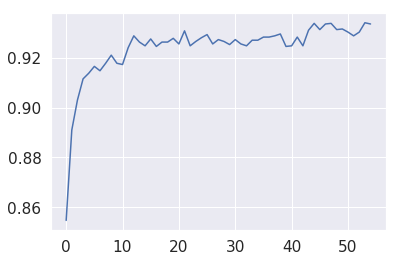

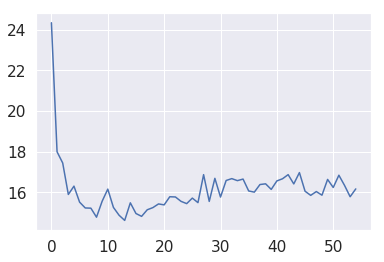

[1, 3, 3, 1, 2, 1, 0, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 0, 1, 3, 1, 1, 0, 3, 3, 1, 3, 3, 3, 0, 0, 3, 3, 2, 0, 0, 1, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 0, 1, 3, 1, 0, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 1, 1, 0, 0, 1, 3, 3, 0, 0, 0, 1, 1, 1, 1, 3, 2, 3, 3, 3, 0, 0, 3, 3, 1, 2, 1, 2, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 2, 0, 3, 1, 1, 1, 1, 3, 0, 2, 1, 1, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0, 1, 1, 3, 1, 3, 1, 1, 3, 0, 0, 1, 2, 0, 1, 3, 1, 3, 1, 3, 0, 3, 3, 1, 0, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 0, 0, 0, 1, 0, 1, 0, 3, 3, 1, 3, 3, 1, 0, 3, 3, 1, 1, 3, 0, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 2, 0, 0, 1, 0, 0, 1, 3, 1, 3, 3, 1, 3, 3, 3, 0, 1, 1, 1, 1, 3, 3, 0, 0, 1, 3, 0, 3, 3, 3, 0, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 3, 1, 3, 0, 0, 1, 3, 0, 1, 1, 2, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         963          20           0          17
C.f Worker          55         854           9          82
C.d Worker           0  

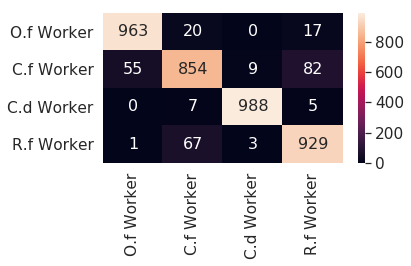


[56] accuracy: 0.934 loss: 15.657

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.43683393672

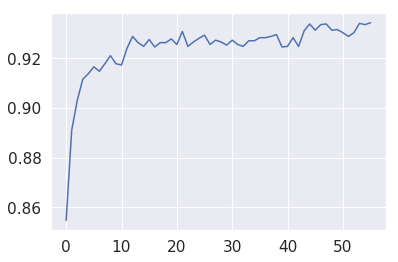

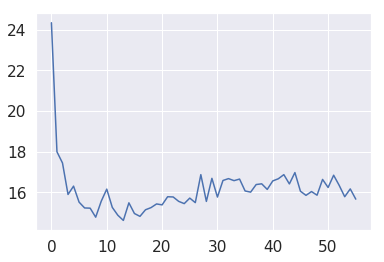

[1, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 1, 0, 1, 3, 3, 0, 3, 1, 2, 3, 3, 3, 2, 0, 1, 3, 3, 3, 3, 0, 3, 1, 2, 0, 0, 0, 3, 3, 1, 1, 3, 3, 0, 3, 3, 1, 1, 0, 1, 3, 1, 1, 3, 0, 0, 3, 3, 1, 0, 0, 3, 0, 1, 0, 1, 1, 0, 3, 1, 3, 3, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 3, 0, 0, 1, 1, 1, 2, 3, 0, 0, 1, 3, 2, 3, 0, 3, 0, 1, 1, 3, 1, 1, 0, 3, 3, 0, 3, 0, 3, 1, 0, 0, 3, 0, 3, 3, 0, 1, 3, 2, 1, 0, 2, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 3, 1, 0, 1, 1, 3, 3, 3, 0, 0, 1, 0, 3, 1, 3, 0, 0, 0, 3, 0, 0, 0, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 1, 2, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 0, 2, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 0, 3, 0, 1, 2, 1, 1, 2, 1, 1, 3, 3, 1, 0, 1, 2, 3, 0, 2, 2, 1, 1, 2, 1, 0, 1, 3, 3, 0, 3, 1, 3, 3, 3, 0, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         965          18           0          17
C.f Worker          51         858          12          79
C.d Worker           0           

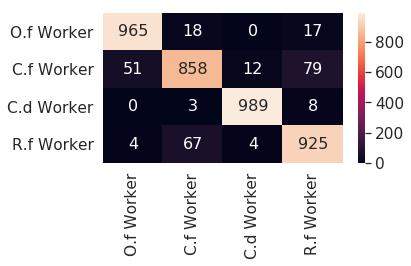


[57] accuracy: 0.929 loss: 15.761

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.547219950705767, 15.43

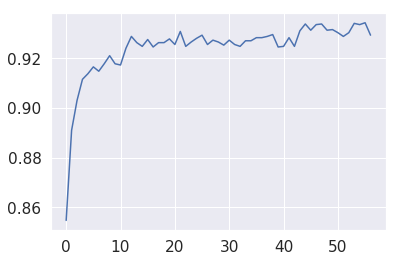

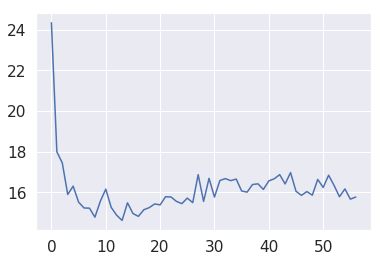

[2, 3, 3, 3, 1, 3, 1, 1, 1, 1, 2, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0, 1, 3, 0, 1, 3, 1, 1, 3, 0, 0, 1, 3, 0, 0, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 0, 3, 3, 1, 0, 1, 0, 1, 3, 3, 1, 3, 1, 1, 1, 1, 0, 1, 3, 0, 0, 3, 3, 2, 3, 3, 0, 2, 1, 1, 0, 1, 0, 1, 3, 1, 3, 3, 0, 1, 1, 0, 2, 0, 3, 0, 3, 0, 0, 2, 3, 0, 3, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 0, 1, 3, 3, 0, 1, 0, 3, 3, 1, 3, 3, 3, 3, 2, 1, 1, 0, 3, 1, 2, 3, 3, 1, 1, 1, 3, 1, 1, 1, 0, 0, 3, 3, 3, 1, 0, 3, 2, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3, 1, 0, 1, 0, 3, 2, 3, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 3, 1, 3, 0, 1, 0, 3, 3, 0, 3, 3, 0, 3, 1, 0, 0, 1, 0, 3, 1, 0, 3, 1, 1, 1, 0, 1, 3, 0, 0, 2, 3, 1, 3, 0, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 3, 3, 1, 3, 0, 1, 1, 0, 3, 3, 0, 1, 1, 1, 0, 3, 3, 3, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         956          23           0          21
C.f Worker          57         8

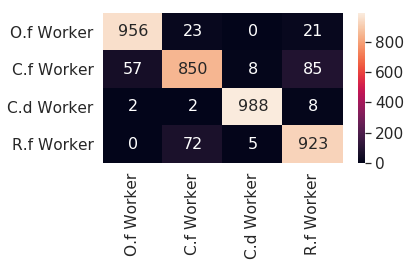


[58] accuracy: 0.932 loss: 16.780

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.5472199507057

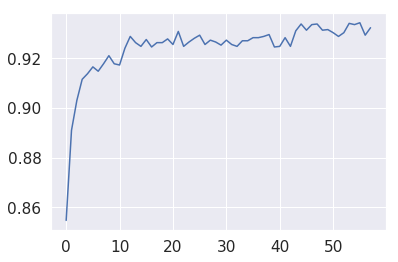

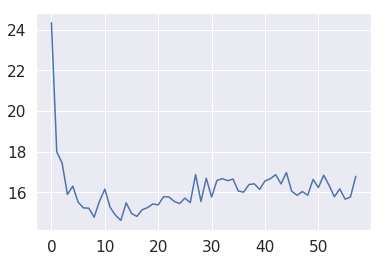

[1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 0, 2, 1, 1, 0, 1, 3, 3, 0, 1, 1, 1, 1, 0, 3, 1, 1, 3, 0, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 0, 1, 1, 1, 0, 3, 0, 3, 1, 0, 1, 1, 3, 1, 0, 1, 0, 0, 1, 3, 0, 3, 0, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 1, 3, 2, 3, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 0, 1, 1, 3, 1, 3, 0, 3, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 1, 3, 2, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 3, 1, 3, 3, 2, 1, 0, 0, 3, 1, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 0, 2, 3, 0, 1, 1, 3, 3, 0, 1, 1, 1, 1, 0, 3, 3, 1, 2, 3, 2, 1, 3, 3, 1, 1, 3, 3, 2, 3, 1, 3, 3, 3, 0, 0, 0, 3, 1, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 2, 1, 0, 2, 3, 3, 3, 2, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 2, 3, 1, 1, 0, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 1, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          28           1          16
C.f Worker          45         857          14          84
C.d Worke

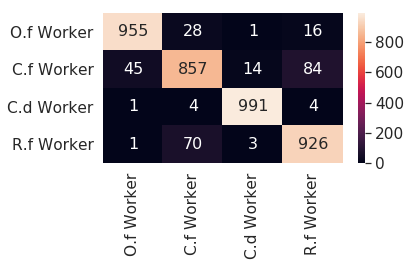


[59] accuracy: 0.933 loss: 16.220

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183, 15.5472

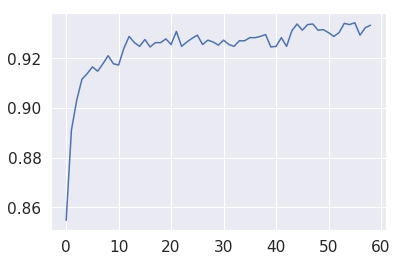

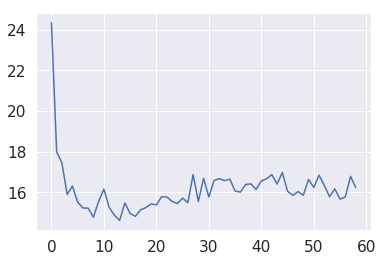

[0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 2, 0, 1, 1, 3, 0, 1, 0, 1, 3, 3, 1, 3, 0, 1, 1, 0, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 2, 3, 1, 0, 3, 1, 1, 3, 0, 1, 3, 3, 1, 0, 1, 1, 0, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 1, 3, 1, 0, 0, 1, 3, 3, 0, 2, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 0, 3, 0, 0, 3, 3, 3, 3, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 0, 1, 1, 1, 1, 3, 0, 0, 0, 3, 3, 0, 1, 3, 2, 1, 3, 0, 3, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 3, 3, 0, 1, 0, 1, 1, 3, 1, 3, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 1, 3, 3, 1, 3, 0, 3, 1, 0, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 2, 1, 3, 2, 3, 0, 3, 0, 0, 3, 3, 0, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 0, 1, 0, 1, 1, 2, 3, 3, 1, 1, 2, 3, 3, 3, 1, 3, 0, 3, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         968          19           1          12
C.f Worker          54         860           7          79
C.d Worker           

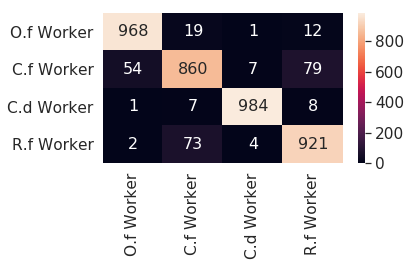


[60] accuracy: 0.926 loss: 17.600

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171682298183

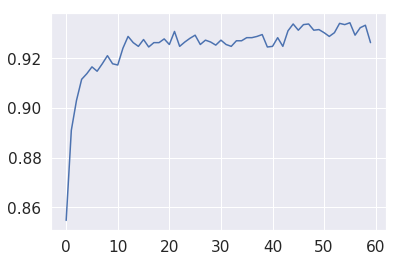

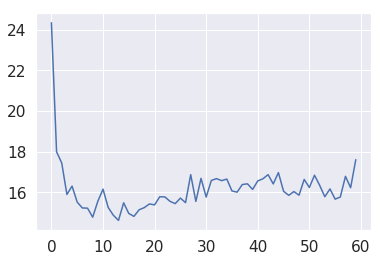

[3, 3, 0, 1, 1, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 0, 3, 0, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 0, 3, 3, 3, 3, 0, 0, 3, 2, 1, 1, 3, 1, 1, 3, 1, 3, 3, 2, 3, 0, 1, 3, 1, 0, 3, 3, 3, 0, 3, 1, 1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 2, 0, 1, 1, 1, 3, 3, 3, 0, 1, 2, 0, 1, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 3, 3, 3, 3, 1, 0, 1, 1, 2, 3, 0, 2, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 0, 1, 0, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 3, 2, 3, 1, 1, 2, 2, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 1, 3, 3, 3, 0, 3, 3, 0, 3, 1, 0, 3, 0, 1, 0, 3, 3, 0, 2, 2, 3, 3, 3, 3, 1, 0, 0, 3, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 2, 1, 1, 3, 1, 0, 3, 3, 0, 0, 0, 1, 1, 3, 0, 3, 2, 0, 0, 2, 0, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 0, 0, 3, 0, 1, 0, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         954          26           0         

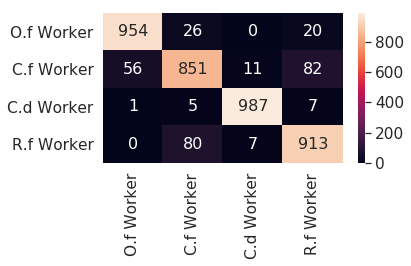


[61] accuracy: 0.930 loss: 16.129

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 15.764171

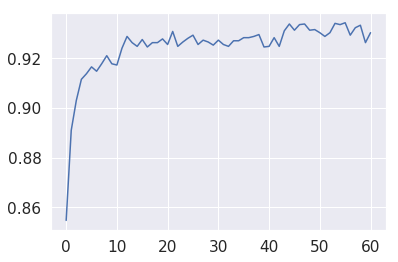

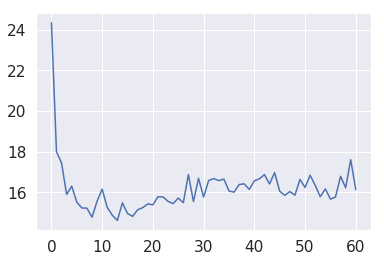

[1, 3, 1, 2, 1, 0, 3, 3, 1, 0, 3, 1, 3, 1, 3, 1, 3, 3, 0, 1, 3, 3, 1, 0, 3, 0, 0, 2, 1, 1, 3, 1, 3, 0, 2, 1, 0, 1, 3, 1, 1, 1, 0, 0, 1, 0, 2, 3, 3, 3, 1, 3, 1, 1, 0, 3, 2, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 0, 3, 3, 1, 1, 0, 0, 3, 3, 3, 0, 3, 1, 2, 0, 1, 3, 2, 1, 1, 1, 0, 1, 0, 3, 1, 0, 3, 0, 3, 3, 1, 1, 1, 1, 3, 0, 3, 0, 1, 0, 1, 0, 1, 1, 0, 1, 3, 1, 0, 0, 1, 1, 1, 3, 3, 1, 0, 0, 1, 1, 0, 3, 1, 3, 1, 3, 1, 0, 3, 3, 3, 3, 1, 0, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 0, 3, 3, 0, 3, 0, 0, 1, 1, 3, 1, 0, 3, 2, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 0, 3, 3, 1, 1, 3, 1, 0, 0, 1, 1, 2, 1, 1, 3, 3, 0, 3, 1, 3, 1, 0, 3, 0, 0, 1, 0, 1, 0, 1, 3, 0, 1, 3, 0, 0, 1, 1, 1, 1, 2, 1, 1, 3, 3, 1, 1, 3, 3, 1, 0, 3, 3, 1, 1, 3, 1, 1, 0, 3, 3, 1, 3, 0, 1, 1, 1, 2, 3, 0, 3, 3, 0, 1, 3, 0, 0, 1, 1, 2, 3, 1, 3, 0, 0, 1, 1, 1, 0, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         961          23           0          16
C.f Worker          60         852          

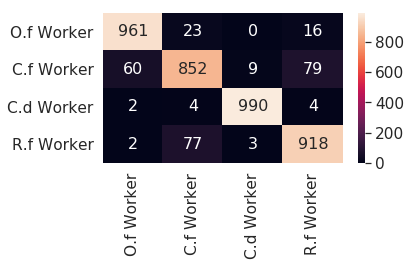


[62] accuracy: 0.933 loss: 15.688

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.775112740695477, 

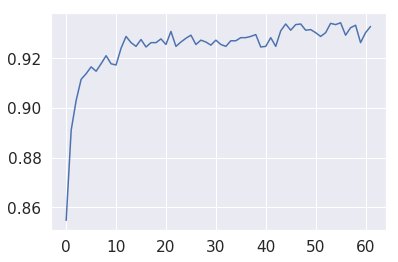

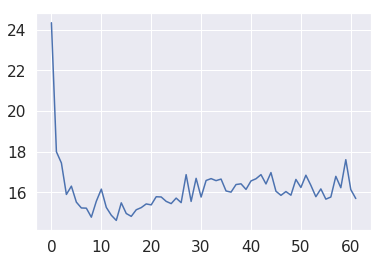

[3, 3, 0, 3, 1, 3, 2, 3, 3, 1, 0, 1, 0, 0, 3, 0, 1, 1, 1, 3, 0, 3, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 1, 1, 3, 2, 1, 0, 1, 1, 3, 1, 1, 1, 0, 3, 1, 3, 0, 3, 3, 3, 0, 3, 2, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 0, 3, 3, 3, 3, 2, 0, 1, 3, 1, 0, 3, 1, 0, 3, 0, 0, 1, 3, 3, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 3, 1, 1, 1, 3, 1, 2, 3, 0, 0, 3, 0, 1, 0, 0, 3, 0, 3, 1, 3, 0, 1, 3, 3, 1, 0, 1, 2, 1, 0, 3, 0, 2, 0, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 3, 0, 3, 3, 0, 3, 0, 1, 0, 1, 0, 1, 3, 1, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 0, 1, 3, 1, 0, 3, 1, 1, 0, 1, 1, 1, 1, 3, 2, 0, 3, 0, 0, 0, 1, 1, 1, 0, 0, 1, 3, 1, 3, 2, 3, 3, 1, 1, 3, 0, 3, 1, 3, 0, 0, 1, 2, 2, 1, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 2, 1, 3, 1, 1, 3, 0, 0, 1, 3, 0, 1, 3, 3, 1, 1, 3, 0, 0, 1, 2, 3, 3, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         964          19           2          15
C.f Worker          54         863           9          74
C.d Worker     

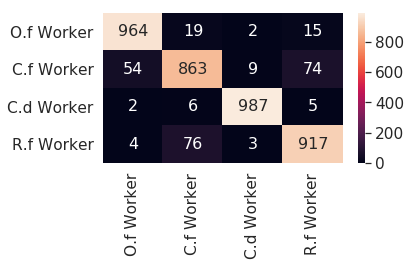


[63] accuracy: 0.932 loss: 16.548

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.77511274

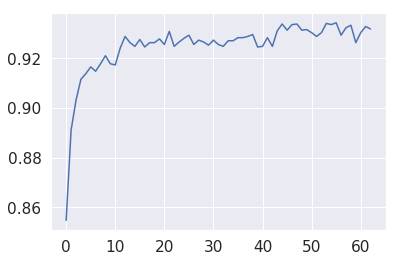

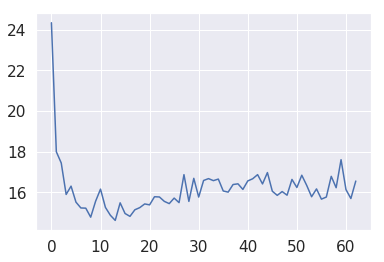

[0, 0, 3, 0, 3, 0, 1, 0, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1, 1, 0, 1, 3, 1, 0, 0, 3, 0, 2, 2, 1, 3, 3, 0, 0, 1, 1, 1, 3, 3, 1, 1, 3, 3, 2, 1, 1, 1, 3, 0, 3, 0, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 2, 3, 0, 1, 3, 3, 1, 0, 1, 3, 3, 1, 0, 3, 1, 3, 0, 1, 1, 3, 0, 1, 1, 3, 1, 1, 1, 2, 3, 1, 3, 3, 1, 1, 0, 1, 1, 3, 0, 0, 0, 0, 0, 3, 1, 3, 3, 0, 2, 1, 1, 1, 1, 1, 3, 0, 0, 3, 1, 3, 3, 0, 1, 3, 3, 2, 1, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 2, 0, 0, 1, 0, 3, 3, 1, 3, 1, 0, 3, 3, 1, 1, 3, 1, 1, 3, 1, 2, 2, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 2, 3, 3, 0, 0, 1, 3, 1, 3, 0, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 1, 0, 3, 3, 0, 1, 1, 3, 0, 0, 1, 0, 1, 3, 0, 3, 3, 2, 0, 1, 3, 1, 1, 1, 3, 0, 0, 0, 3, 0, 0, 2, 0, 2, 1, 1, 3, 2, 1, 0, 1, 1, 3, 0, 2, 0, 1, 3, 3, 0, 1, 1, 1, 0, 0, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         959          23           1          17
C.f Worker          57         862          11          70
C.d

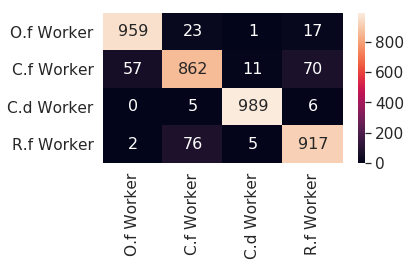


[64] accuracy: 0.931 loss: 15.920

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.375017024576664, 15.7

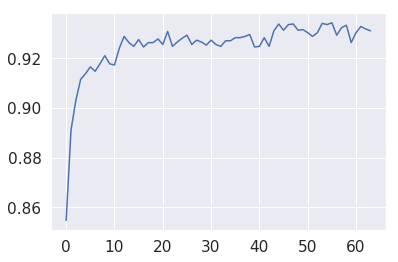

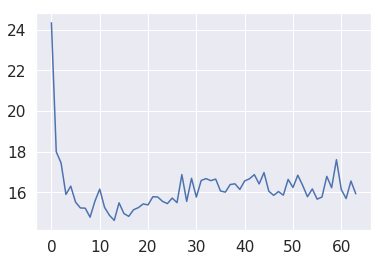

[1, 1, 3, 0, 3, 1, 3, 0, 1, 0, 3, 0, 0, 2, 0, 0, 1, 1, 2, 0, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 1, 0, 1, 0, 0, 1, 1, 1, 3, 2, 1, 0, 0, 1, 3, 3, 3, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 3, 3, 0, 0, 0, 0, 0, 3, 3, 1, 2, 2, 0, 0, 3, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 0, 3, 3, 1, 0, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 2, 3, 0, 3, 1, 1, 0, 0, 2, 3, 1, 1, 0, 1, 3, 1, 0, 1, 0, 1, 1, 1, 3, 3, 1, 1, 3, 0, 3, 1, 1, 1, 3, 2, 3, 3, 3, 1, 0, 3, 3, 0, 3, 0, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 0, 0, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 2, 3, 0, 0, 0, 3, 1, 3, 0, 3, 3, 1, 0, 1, 0, 3, 3, 0, 3, 0, 1, 0, 3, 0, 2, 2, 0, 3, 0, 1, 0, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 0, 3, 3, 1, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         952          28           1          19
C.f Worker          58         863           8       

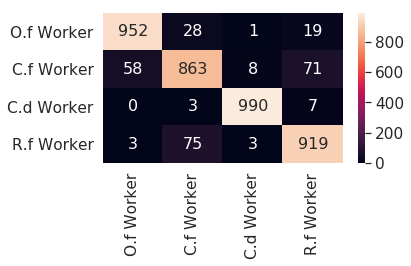


[65] accuracy: 0.932 loss: 16.375

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.37501702457666

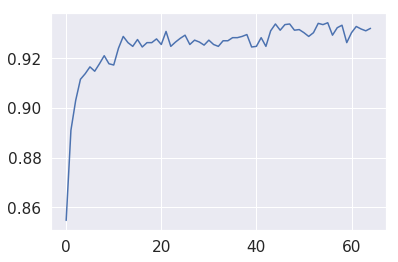

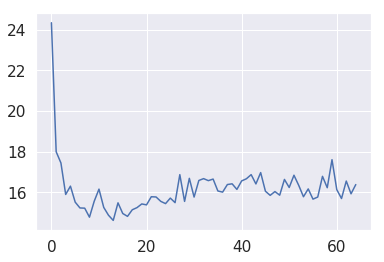

[0, 1, 0, 1, 3, 3, 3, 0, 3, 2, 0, 0, 1, 0, 3, 1, 1, 1, 0, 3, 0, 3, 3, 3, 1, 1, 0, 3, 2, 1, 0, 3, 3, 3, 1, 3, 1, 3, 1, 0, 3, 1, 0, 3, 1, 1, 3, 0, 2, 0, 2, 2, 0, 0, 2, 2, 1, 3, 1, 3, 3, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 0, 0, 1, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 3, 3, 3, 0, 0, 3, 2, 3, 0, 0, 1, 1, 3, 0, 3, 1, 3, 0, 1, 1, 0, 0, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 0, 0, 0, 0, 1, 0, 1, 1, 2, 3, 3, 3, 1, 0, 1, 1, 1, 3, 1, 0, 0, 1, 1, 3, 1, 1, 0, 3, 3, 1, 1, 0, 0, 1, 2, 0, 1, 3, 0, 0, 1, 0, 3, 0, 1, 1, 1, 1, 0, 0, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 3, 0, 0, 1, 3, 1, 2, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 0, 1, 1, 1, 1, 0, 1, 3, 2, 2, 3, 1, 1, 3, 3, 2, 1, 1, 3, 1, 3, 1, 0, 3, 1, 3, 3, 1, 3, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         956          24           1          19
C.f Worker          58         858           9          75
C.d Wo

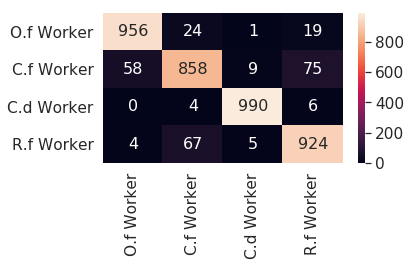


[66] accuracy: 0.932 loss: 16.052

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882, 15.37501

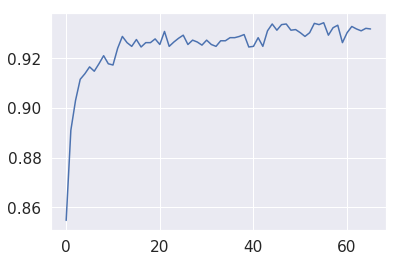

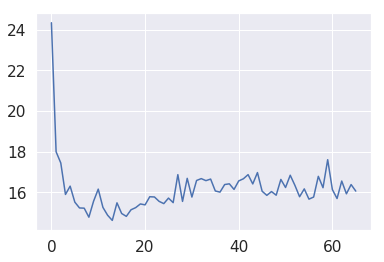

[1, 1, 3, 0, 2, 1, 3, 1, 0, 2, 3, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0, 1, 2, 2, 1, 3, 3, 1, 1, 2, 1, 1, 1, 0, 1, 3, 0, 3, 1, 3, 0, 0, 3, 1, 3, 0, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 0, 0, 1, 3, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 3, 3, 0, 1, 1, 3, 1, 3, 1, 0, 1, 2, 3, 2, 1, 3, 3, 0, 3, 3, 3, 2, 1, 1, 3, 1, 1, 1, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 0, 1, 0, 3, 1, 1, 3, 0, 2, 1, 3, 1, 3, 1, 0, 3, 0, 3, 1, 1, 3, 3, 0, 1, 1, 0, 1, 0, 0, 0, 3, 1, 1, 3, 1, 2, 3, 0, 3, 1, 1, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 0, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 0, 0, 3, 3, 2, 0, 1, 0, 3, 3, 3, 1, 0, 2, 3, 3, 0, 1, 1, 3, 3, 0, 0, 1, 3, 3, 1, 3, 3, 0, 1, 0, 2, 3, 1, 3, 1, 1, 0, 1, 0, 1, 1, 3, 2, 1, 1, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 3, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 0, 0, 1, 3, 3, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 0, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          25           1          17
C.f Worker          54         860          12          74
C.d

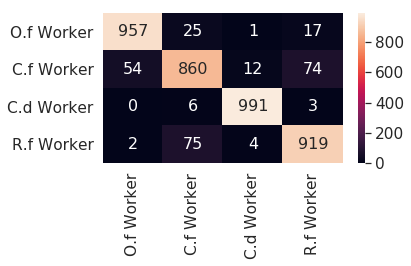


[67] accuracy: 0.931 loss: 16.778

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.420906700193882,

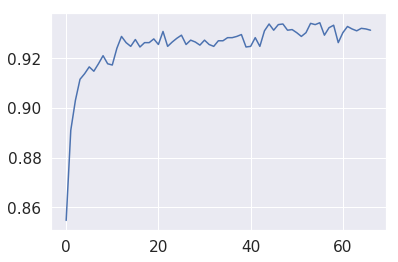

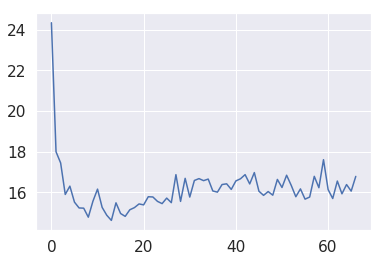

[1, 3, 1, 1, 2, 3, 0, 0, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 3, 1, 0, 0, 3, 1, 1, 0, 0, 1, 3, 3, 0, 1, 0, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 0, 1, 3, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 2, 0, 1, 1, 1, 2, 2, 1, 0, 0, 0, 2, 0, 2, 3, 3, 3, 1, 3, 0, 1, 1, 1, 0, 3, 1, 1, 1, 3, 0, 0, 1, 3, 3, 1, 3, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 0, 2, 3, 3, 1, 3, 1, 0, 1, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 0, 1, 3, 1, 2, 1, 1, 1, 1, 0, 0, 3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 0, 0, 3, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 2, 3, 1, 3, 0, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 3, 0, 1, 3, 0, 0, 1, 0, 1, 3, 1, 3, 2, 3, 2, 3, 3, 3, 1, 1, 1, 2, 3, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 0, 1, 3, 2, 1, 3, 2, 1, 3, 3, 0, 1, 0, 3, 3, 1, 1, 1, 1, 3, 0, 1, 0, 3, 1, 1, 1, 3, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          28           0          17
C.f Worker          49         862          10          

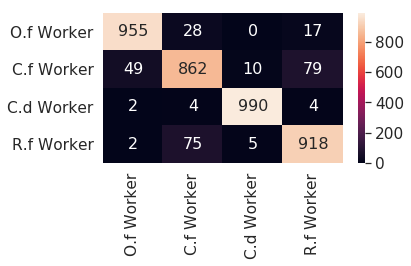


[68] accuracy: 0.931 loss: 16.360

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15.4209067

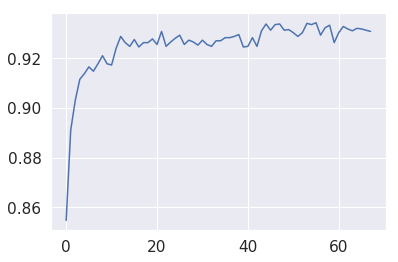

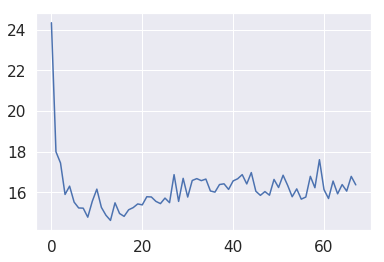

[1, 3, 1, 3, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 0, 1, 0, 0, 1, 0, 3, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 0, 0, 1, 3, 1, 0, 1, 3, 3, 3, 1, 0, 0, 1, 0, 2, 3, 1, 1, 1, 3, 3, 0, 2, 3, 3, 3, 3, 2, 0, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 0, 0, 1, 1, 1, 1, 3, 3, 2, 1, 0, 1, 3, 3, 3, 3, 3, 3, 0, 0, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 0, 0, 0, 3, 3, 0, 3, 1, 1, 3, 0, 0, 1, 3, 0, 2, 2, 3, 3, 3, 3, 1, 0, 1, 1, 3, 0, 3, 1, 1, 0, 3, 1, 0, 1, 3, 1, 0, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 2, 3, 1, 1, 3, 3, 3, 1, 0, 1, 1, 3, 1, 0, 0, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 0, 1, 0, 1, 3, 3, 0, 1, 3, 2, 3, 0, 1, 0, 0, 3, 0, 1, 1, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         949          23           1          27
C.f Worker          49         870           6    

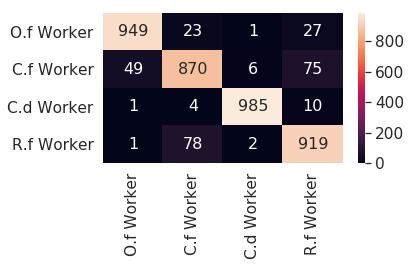


[69] accuracy: 0.928 loss: 17.614

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239851854741573, 15

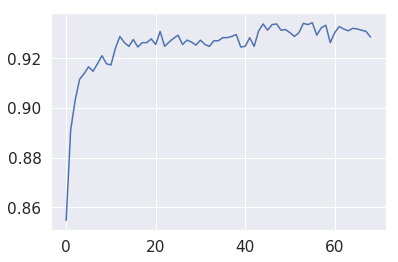

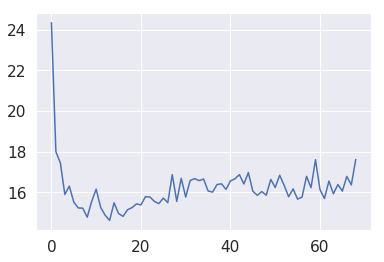

[0, 0, 1, 1, 3, 3, 1, 3, 1, 2, 1, 3, 1, 0, 2, 3, 1, 3, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 3, 1, 0, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 0, 1, 0, 0, 1, 0, 1, 1, 3, 1, 1, 2, 0, 1, 2, 3, 2, 1, 3, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 3, 3, 3, 3, 1, 2, 3, 2, 0, 0, 3, 3, 0, 0, 3, 1, 1, 2, 0, 1, 0, 3, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 2, 1, 3, 0, 2, 1, 3, 3, 3, 1, 0, 0, 0, 0, 0, 3, 0, 1, 3, 1, 1, 0, 0, 0, 1, 3, 1, 1, 2, 1, 1, 1, 3, 0, 3, 1, 3, 3, 1, 1, 3, 3, 3, 0, 1, 1, 3, 3, 3, 2, 1, 3, 1, 0, 3, 0, 3, 1, 2, 3, 3, 3, 1, 0, 3, 3, 1, 2, 1, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 0, 1, 0, 1, 1, 2, 1, 3, 1, 1, 2, 0, 0, 1, 1, 0, 3, 3, 0, 1, 1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 0, 2, 3, 2, 1, 3, 0, 0, 1, 3, 1, 1, 3, 1, 1, 1, 0, 3, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          22           0          18
C.f Worker          52 

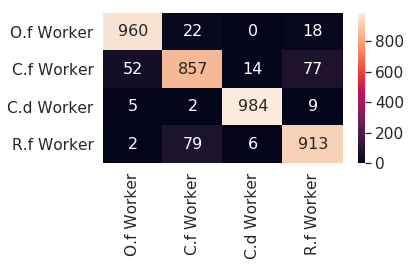


[70] accuracy: 0.934 loss: 16.501

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.23985185474

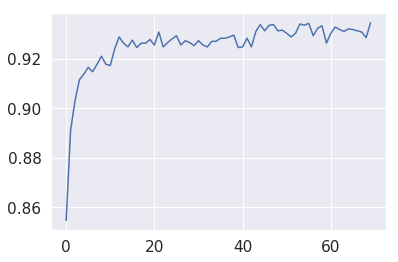

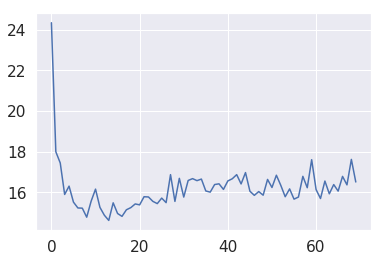

[1, 1, 3, 1, 0, 1, 3, 3, 1, 1, 3, 1, 1, 0, 0, 1, 0, 3, 0, 0, 1, 0, 0, 0, 3, 1, 0, 1, 1, 0, 1, 1, 0, 1, 3, 0, 1, 3, 2, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 0, 1, 3, 0, 3, 1, 0, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 0, 2, 1, 3, 0, 3, 0, 1, 1, 0, 0, 1, 3, 3, 0, 3, 1, 1, 3, 2, 2, 3, 1, 3, 1, 1, 1, 0, 0, 1, 3, 1, 1, 3, 3, 0, 1, 3, 1, 1, 1, 0, 1, 2, 3, 0, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 0, 2, 0, 3, 1, 1, 3, 1, 3, 1, 1, 3, 0, 0, 3, 0, 1, 3, 0, 1, 2, 1, 3, 1, 1, 3, 3, 1, 0, 0, 1, 3, 3, 3, 0, 2, 1, 0, 0, 0, 0, 0, 1, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 0, 1, 3, 1, 0, 1, 1, 2, 0, 1, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          18           0          20
C.f Worker          53         862           5          80
C.d Worker           1           3  

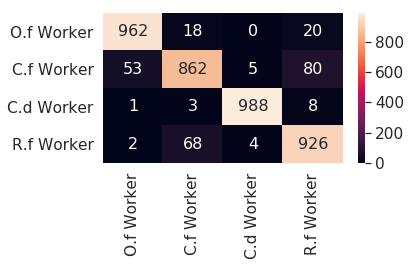


[71] accuracy: 0.929 loss: 16.688

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.13344744592905, 15.239

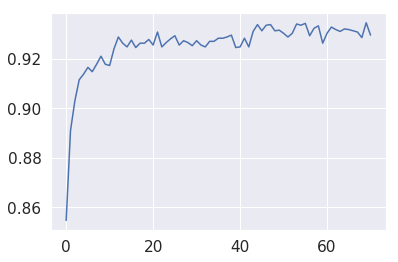

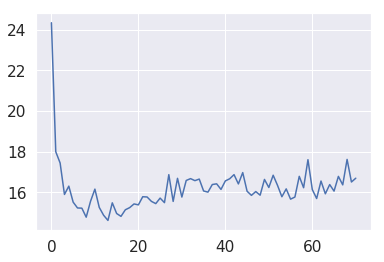

[2, 2, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 0, 0, 3, 3, 3, 1, 1, 0, 0, 3, 1, 1, 3, 2, 3, 2, 1, 0, 0, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 0, 2, 0, 1, 0, 1, 1, 1, 3, 1, 0, 3, 1, 2, 1, 3, 0, 1, 2, 3, 1, 3, 0, 3, 1, 0, 0, 3, 1, 0, 1, 1, 2, 0, 3, 3, 0, 1, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 0, 1, 3, 3, 1, 1, 0, 3, 3, 3, 2, 3, 1, 3, 0, 0, 0, 3, 3, 2, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 0, 3, 0, 1, 3, 1, 3, 0, 0, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 1, 3, 0, 0, 3, 1, 0, 3, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 0, 0, 1, 3, 0, 3, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 0, 3, 3, 0, 1, 1, 0, 0, 1, 0, 1, 3, 2, 3, 3, 3, 0, 1, 2, 1, 0, 0, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1, 1, 3, 0, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 0, 3, 3, 1, 1, 3, 0, 0, 1, 0, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 2, 1, 1, 3, 0, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          22           0          21
C.f Worker          54         852 

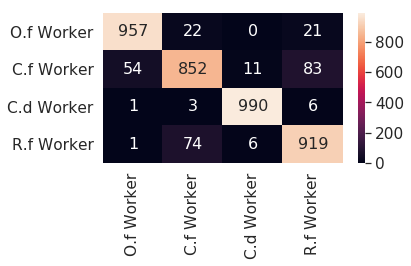


[72] accuracy: 0.932 loss: 17.020

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.1334474459290

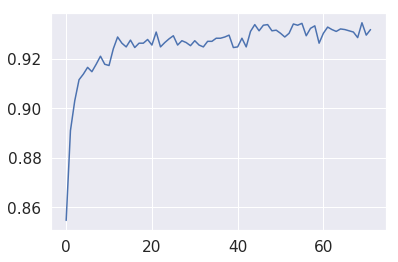

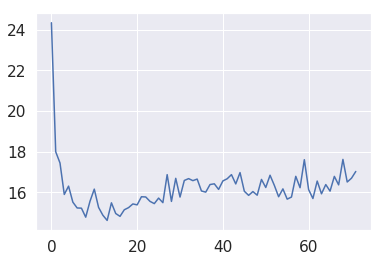

[2, 0, 1, 0, 3, 0, 3, 3, 1, 0, 3, 3, 1, 1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 3, 1, 1, 3, 0, 3, 0, 1, 1, 0, 0, 0, 1, 3, 0, 1, 1, 1, 0, 3, 2, 1, 3, 3, 0, 3, 0, 1, 3, 0, 3, 1, 3, 3, 3, 0, 3, 0, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 0, 3, 3, 1, 1, 1, 0, 3, 0, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 0, 0, 1, 0, 1, 0, 3, 0, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 2, 0, 1, 3, 3, 2, 3, 1, 1, 3, 3, 2, 0, 1, 1, 0, 3, 1, 1, 3, 0, 3, 1, 3, 2, 1, 1, 3, 3, 3, 0, 0, 1, 0, 1, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 2, 3, 1, 1, 3, 3, 3, 3, 0, 3, 1, 0, 3, 3, 0, 3, 3, 3, 1, 0, 3, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 0, 0, 3, 3, 0, 3, 2, 1, 2, 3, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 2, 3, 1, 1, 3, 0, 1, 1, 0, 1, 1, 3, 1, 0, 3, 1, 0, 0, 1, 3, 1, 2, 3, 0, 0, 3, 0, 1, 1, 3, 1, 3, 1, 0, 3, 3, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          22           1          15
C.f Worker          53         855           8          84
C.d

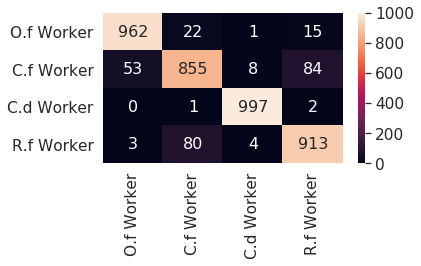


[73] accuracy: 0.931 loss: 16.751

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 15.1334

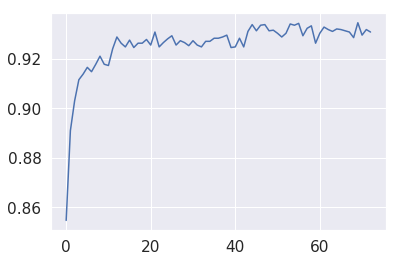

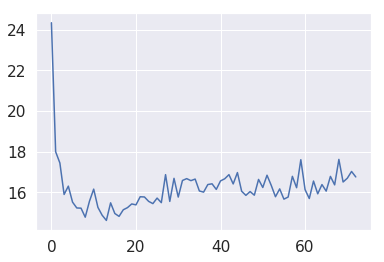

[3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 1, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 0, 2, 0, 3, 1, 1, 1, 1, 0, 3, 1, 3, 2, 1, 1, 3, 0, 0, 3, 0, 0, 3, 1, 3, 0, 1, 1, 1, 0, 1, 1, 3, 3, 1, 0, 1, 1, 3, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 3, 3, 1, 3, 3, 0, 3, 1, 2, 3, 3, 1, 3, 1, 3, 0, 1, 3, 0, 0, 3, 3, 0, 0, 3, 0, 1, 3, 3, 3, 2, 3, 0, 1, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 0, 3, 0, 3, 3, 1, 1, 0, 0, 0, 1, 2, 3, 3, 2, 1, 0, 1, 0, 3, 1, 3, 1, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 0, 0, 1, 0, 1, 3, 0, 3, 1, 1, 0, 3, 3, 1, 3, 1, 3, 3, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0, 0, 3, 0, 1, 3, 2, 3, 3, 1, 0, 0, 0, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 0, 1, 1, 0, 0, 1, 3, 0, 3, 1, 0, 1, 0, 1, 3, 0, 3, 1, 3, 3, 0, 1, 3, 1, 1, 3, 3, 2, 1, 0, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 2, 1, 3, 1, 3, 3, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          21           1          18
C.f Worker          58         858           7    

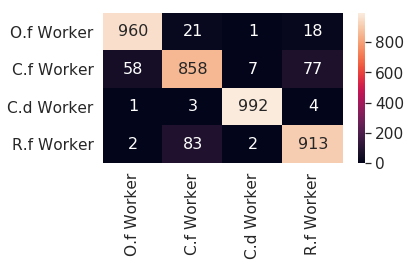


[74] accuracy: 0.930 loss: 17.808

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809050776064396, 1

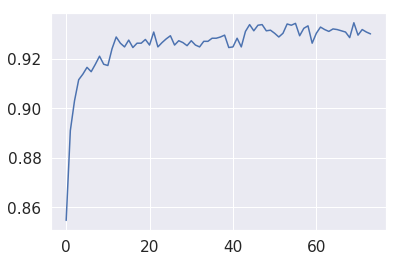

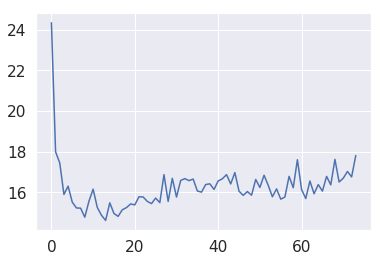

[1, 0, 1, 0, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 0, 2, 3, 3, 1, 1, 0, 0, 1, 0, 3, 3, 1, 3, 0, 0, 1, 0, 3, 3, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 1, 0, 1, 3, 1, 0, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 1, 3, 0, 1, 1, 0, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 2, 0, 1, 1, 3, 1, 1, 3, 0, 2, 1, 3, 1, 2, 1, 3, 1, 3, 1, 2, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 2, 0, 3, 1, 3, 0, 0, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 0, 3, 3, 1, 1, 3, 0, 1, 0, 0, 3, 1, 1, 3, 3, 2, 1, 2, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 2, 3, 3, 3, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 3, 0, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 0, 0, 3, 2, 0, 3, 3, 1, 3, 0, 3, 1, 3, 3, 1, 1, 0, 1, 3, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 3, 3, 1, 0, 3, 3, 1, 1, 3, 3, 0, 3, 0, 0, 0, 1, 1, 3, 0, 1, 3, 2, 0, 0, 3, 2, 0, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         959          21           0          20
C.f Worker          54         857       

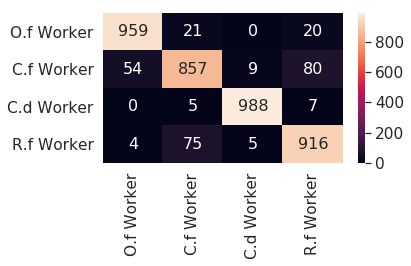


[75] accuracy: 0.931 loss: 16.672

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.8090507760

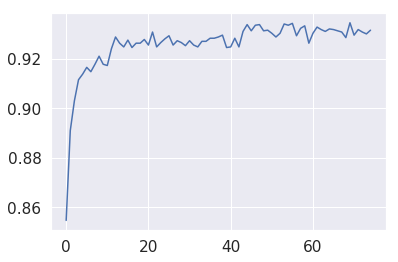

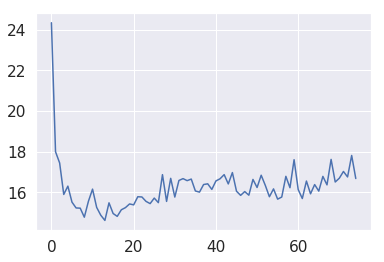

[0, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 2, 1, 3, 0, 1, 3, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 0, 0, 1, 1, 3, 1, 3, 1, 1, 3, 0, 3, 3, 2, 2, 3, 1, 3, 3, 1, 0, 1, 0, 3, 3, 3, 1, 1, 0, 0, 3, 3, 3, 0, 1, 1, 0, 0, 1, 3, 1, 3, 3, 0, 3, 0, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 3, 1, 3, 1, 0, 1, 3, 0, 3, 1, 1, 1, 1, 1, 2, 3, 1, 1, 0, 0, 3, 3, 1, 1, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 2, 0, 0, 3, 0, 1, 2, 3, 3, 0, 1, 3, 1, 1, 1, 3, 0, 3, 3, 0, 1, 1, 3, 0, 0, 0, 1, 3, 2, 3, 3, 1, 0, 1, 1, 3, 0, 0, 0, 1, 3, 1, 0, 0, 1, 3, 1, 3, 3, 3, 1, 0, 3, 1, 0, 0, 3, 3, 0, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 0, 2, 0, 0, 0, 1, 3, 1, 3, 1, 1, 0, 3, 1, 3, 3, 0, 0, 1, 1, 0, 0, 0, 3, 1, 1, 3, 0, 1, 0, 0, 0, 0, 1, 2, 3, 3, 3, 3, 1, 1, 0, 1, 1, 3, 1, 3, 3, 1, 1, 0, 1, 1, 2, 3, 1, 3, 0, 3, 1, 3, 0, 0, 3, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          18           1          21
C.f Worker          62         860           8          70


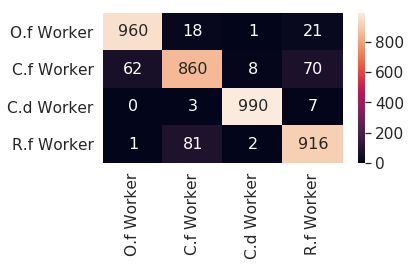


[76] accuracy: 0.931 loss: 17.390

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543047696352, 14.809

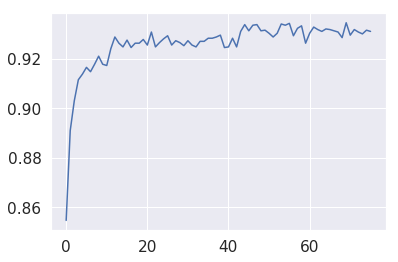

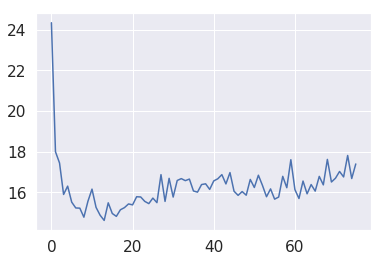

[0, 0, 1, 3, 3, 2, 1, 3, 3, 3, 3, 1, 1, 1, 0, 0, 1, 1, 3, 1, 3, 3, 2, 2, 1, 3, 0, 3, 1, 0, 0, 0, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 0, 3, 0, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 0, 3, 1, 1, 1, 0, 3, 3, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 3, 0, 1, 0, 2, 0, 0, 0, 1, 3, 3, 0, 2, 0, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 3, 0, 0, 3, 3, 2, 0, 1, 3, 1, 1, 0, 3, 0, 0, 1, 3, 1, 3, 3, 0, 0, 3, 3, 3, 1, 3, 3, 0, 1, 2, 1, 0, 1, 3, 3, 2, 3, 1, 1, 0, 1, 0, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 3, 0, 1, 1, 0, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 0, 1, 3, 3, 1, 0, 0, 0, 0, 0, 2, 3, 0, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 0, 0, 3, 1, 1, 3, 3, 1, 3, 3, 0, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 0, 1, 3, 0, 1, 1, 3, 0, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          21           1          20
C.f Worker          57         854           7       

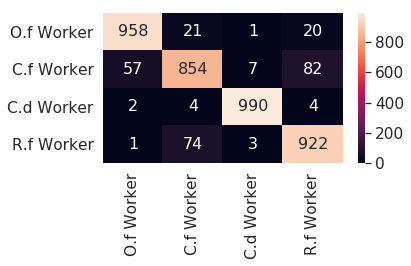


[77] accuracy: 0.932 loss: 16.887

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.94954304769635

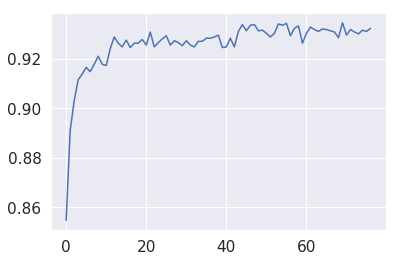

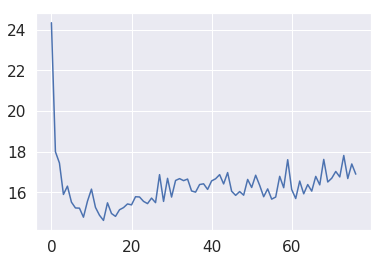

[1, 3, 3, 0, 0, 0, 1, 3, 1, 1, 3, 1, 0, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 0, 1, 0, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3, 1, 1, 2, 1, 0, 3, 3, 0, 2, 1, 0, 3, 3, 1, 3, 2, 1, 3, 3, 0, 1, 0, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 0, 3, 0, 2, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 2, 1, 0, 1, 0, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 1, 3, 1, 3, 0, 3, 1, 0, 3, 0, 1, 1, 0, 3, 0, 1, 2, 3, 1, 1, 3, 1, 3, 0, 1, 1, 2, 3, 0, 1, 1, 0, 1, 0, 1, 3, 1, 3, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 0, 0, 0, 0, 3, 1, 1, 1, 3, 1, 0, 1, 0, 3, 0, 0, 0, 3, 2, 0, 1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 0, 3, 1, 1, 3, 2, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 0, 1, 0, 0, 3, 1, 3, 3, 3, 1, 3, 0, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 3, 0, 1, 0, 1, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 2, 1, 0, 1, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          22           1          15
C.f Worker          47         859           9          85
C.d Worke

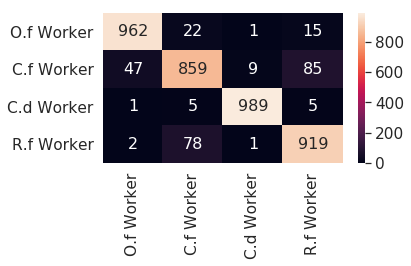


[78] accuracy: 0.930 loss: 17.243

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.949543

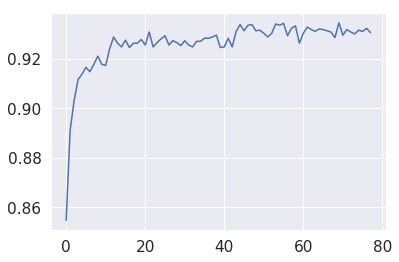

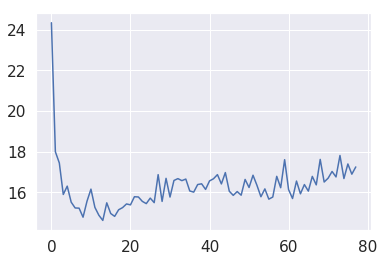

[1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 0, 1, 3, 1, 0, 3, 3, 1, 3, 1, 3, 1, 1, 0, 1, 3, 0, 0, 3, 3, 0, 1, 1, 3, 1, 1, 0, 0, 1, 3, 1, 3, 1, 1, 3, 3, 3, 0, 0, 1, 3, 0, 0, 3, 3, 0, 3, 1, 1, 3, 3, 1, 3, 0, 2, 0, 3, 2, 1, 0, 1, 0, 3, 3, 3, 2, 3, 3, 3, 0, 0, 1, 1, 3, 1, 1, 0, 1, 3, 2, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 3, 3, 1, 1, 1, 1, 3, 3, 2, 1, 3, 2, 3, 1, 0, 0, 3, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 0, 1, 3, 3, 0, 3, 3, 1, 0, 1, 1, 0, 1, 3, 3, 1, 3, 1, 1, 0, 0, 3, 0, 0, 1, 3, 1, 3, 0, 3, 1, 0, 1, 1, 1, 2, 3, 1, 1, 0, 0, 0, 1, 3, 0, 1, 3, 1, 0, 3, 3, 1, 0, 3, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 2, 2, 1, 3, 1, 0, 3, 0, 0, 0, 1, 3, 3, 1, 2, 3, 1, 0, 3, 3, 1, 3, 0, 1, 3, 0, 1, 0, 1, 3, 3, 3, 0, 1, 3, 1, 2, 1, 0, 3, 3, 3, 1, 1, 0, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         966          18           0          16
C.f Worker          53         853          10 

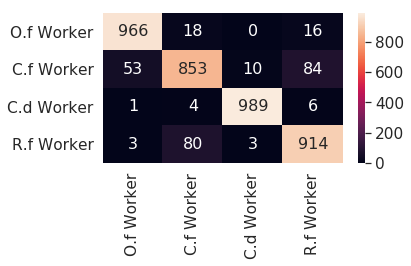


[79] accuracy: 0.930 loss: 17.016

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.475865580141544, 14.

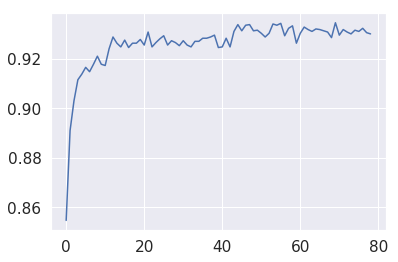

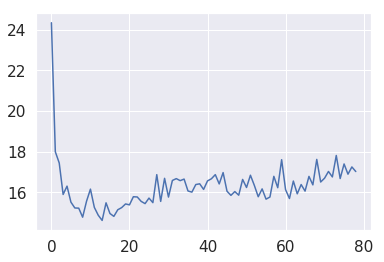

[0, 0, 0, 1, 1, 3, 3, 1, 3, 1, 3, 0, 0, 1, 3, 1, 3, 3, 1, 3, 1, 0, 3, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 3, 1, 0, 3, 1, 3, 2, 3, 3, 1, 3, 1, 0, 3, 0, 3, 3, 3, 0, 1, 0, 3, 3, 1, 1, 3, 1, 3, 0, 0, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 1, 0, 0, 3, 0, 0, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 2, 0, 0, 3, 1, 0, 1, 1, 0, 1, 3, 1, 1, 3, 1, 0, 1, 0, 3, 1, 3, 1, 3, 1, 3, 1, 0, 3, 3, 3, 0, 3, 0, 1, 3, 1, 3, 0, 0, 0, 1, 0, 2, 0, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 0, 0, 1, 3, 0, 3, 3, 1, 0, 3, 0, 1, 1, 0, 1, 3, 3, 1, 1, 1, 0, 3, 3, 2, 3, 1, 1, 1, 0, 0, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 2, 1, 0, 3, 0, 1, 0, 3, 2, 3, 3, 1, 1, 0, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 0, 3, 0, 2, 3, 0, 3, 0, 3, 0, 1, 1, 0, 2, 3, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 3, 3, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          22           0          16
C.f Worker          67         846       

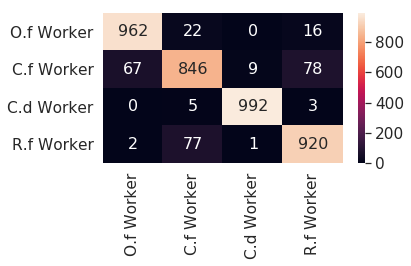


[80] accuracy: 0.925 loss: 17.885

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.47586558014

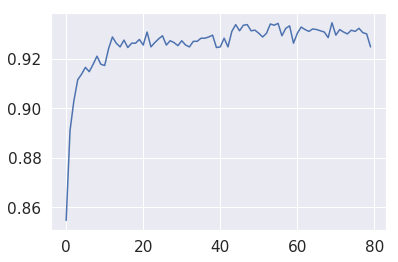

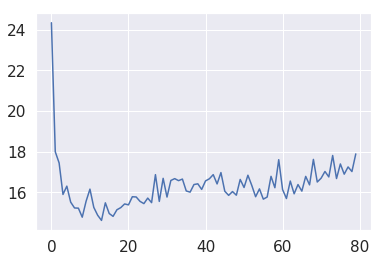

[3, 3, 0, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 0, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 2, 3, 1, 3, 1, 3, 1, 0, 3, 0, 0, 1, 3, 1, 3, 0, 3, 1, 0, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 2, 1, 3, 3, 3, 3, 3, 1, 0, 1, 0, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 3, 1, 2, 1, 3, 1, 1, 3, 2, 0, 3, 0, 1, 1, 0, 0, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 0, 1, 1, 0, 3, 3, 3, 1, 0, 2, 0, 3, 1, 2, 3, 1, 3, 0, 0, 1, 2, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 0, 0, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 2, 3, 0, 0, 1, 1, 1, 0, 3, 1, 1, 3, 0, 0, 3, 3, 0, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 0, 2, 0, 1, 1, 3, 1, 3, 3, 2, 1, 2, 0, 1, 3, 1, 3, 1, 0, 3, 3, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 1, 3, 0, 3, 1, 3, 1, 2, 3, 1, 0, 1, 3, 3, 3, 3, 2, 3, 1, 3, 0, 1, 3, 0, 3, 1, 0, 3, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          24   

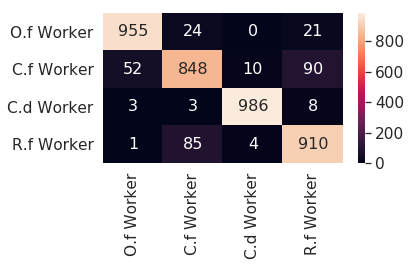


[81] accuracy: 0.933 loss: 16.956

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941456258297, 15.47

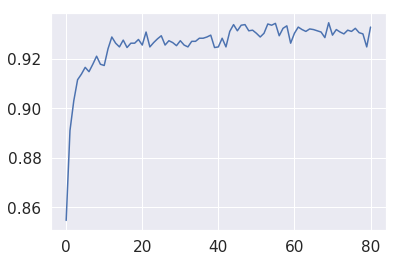

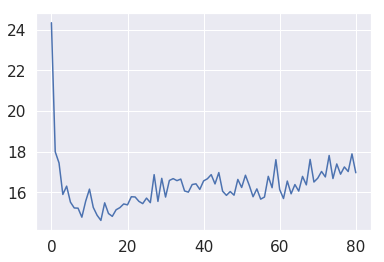

[3, 1, 1, 3, 1, 0, 1, 1, 0, 0, 1, 1, 3, 0, 1, 3, 2, 1, 1, 3, 3, 3, 0, 3, 3, 1, 2, 0, 1, 3, 1, 3, 0, 3, 3, 0, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 3, 1, 3, 0, 3, 1, 1, 3, 1, 3, 3, 0, 0, 0, 1, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 1, 3, 3, 1, 0, 3, 2, 3, 3, 1, 3, 1, 1, 1, 3, 3, 0, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 0, 3, 0, 0, 0, 3, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 3, 0, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 0, 3, 3, 0, 0, 1, 1, 1, 0, 0, 1, 3, 0, 3, 0, 1, 1, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 0, 3, 0, 3, 0, 3, 1, 1, 3, 0, 1, 0, 3, 3, 3, 3, 0, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 2, 1, 3, 2, 1, 0, 1, 1, 3, 0, 3, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 1, 1, 1, 3, 0, 3, 2, 1, 1, 3, 1, 2, 3, 1, 3, 3, 1, 1, 3, 0, 1, 3, 0, 3, 3, 1, 1, 0, 1, 1, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         959          25           0          16
C.f Worker          50         866           5          79
C.d Worker     

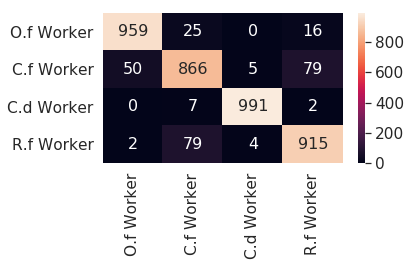


[82] accuracy: 0.931 loss: 17.377

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.609414562582

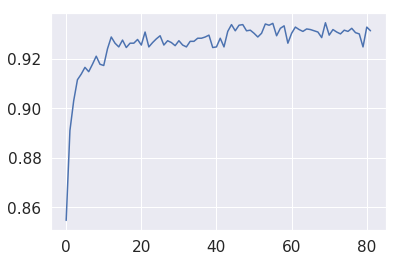

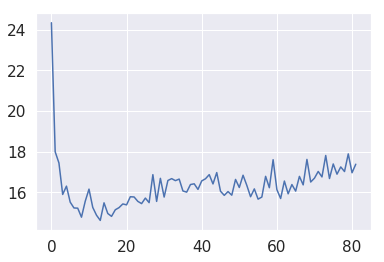

[0, 0, 1, 0, 1, 1, 1, 3, 3, 3, 1, 2, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3, 0, 3, 3, 1, 0, 1, 3, 3, 1, 2, 0, 1, 1, 1, 3, 0, 3, 3, 0, 0, 0, 1, 3, 3, 3, 0, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 0, 0, 0, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 2, 3, 1, 1, 1, 3, 3, 2, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 2, 3, 0, 3, 1, 2, 1, 1, 3, 3, 1, 1, 3, 2, 2, 1, 1, 1, 3, 1, 0, 3, 1, 0, 0, 0, 1, 0, 1, 1, 3, 3, 0, 0, 3, 3, 1, 3, 3, 1, 1, 2, 0, 3, 0, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 0, 3, 0, 1, 3, 0, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 0, 0, 3, 2, 0, 1, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 0, 0, 3, 1, 1, 0, 3, 0, 3, 3, 0, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 2, 3, 3, 1, 1, 3, 3, 0, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 0, 3, 0, 2]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          21           0          22
C.f Worker          52         851          10          

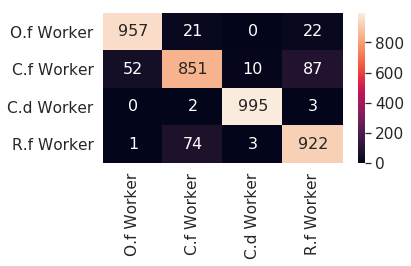


[83] accuracy: 0.929 loss: 17.279

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088, 14.60941

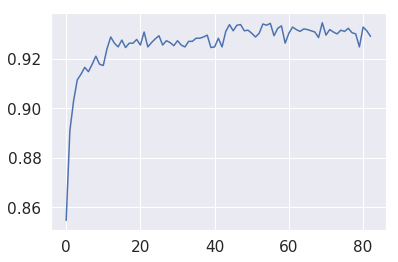

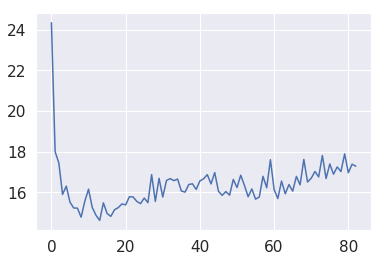

[0, 1, 1, 0, 0, 1, 3, 1, 0, 1, 3, 1, 0, 1, 1, 0, 1, 1, 1, 3, 1, 3, 3, 0, 0, 1, 3, 1, 3, 0, 1, 2, 3, 1, 3, 3, 0, 3, 3, 0, 0, 3, 1, 1, 1, 1, 2, 0, 3, 3, 3, 0, 0, 1, 3, 1, 1, 3, 1, 3, 2, 1, 0, 2, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 3, 1, 3, 1, 1, 0, 3, 3, 1, 0, 1, 3, 1, 1, 0, 3, 0, 3, 3, 3, 1, 3, 3, 3, 0, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 0, 1, 3, 1, 0, 3, 3, 1, 1, 0, 3, 1, 3, 3, 3, 1, 3, 0, 2, 1, 1, 3, 0, 1, 3, 0, 1, 0, 1, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 1, 0, 3, 0, 0, 3, 1, 3, 1, 3, 0, 1, 1, 1, 1, 3, 3, 3, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 1, 3, 0, 1, 3, 0, 0, 3, 3, 1, 3, 1, 1, 3, 0, 0, 1, 1, 1, 3, 1, 0, 2, 1, 0, 3, 1, 3, 0, 3, 1, 2, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 0, 1, 3, 0, 1, 1, 1, 2, 0, 1, 1, 1, 3, 0, 3, 1, 0, 3, 0, 1, 0, 3, 1, 3, 3, 3, 2, 1, 0, 3, 3, 1, 3, 0, 1, 0, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         953          27           1          19
C.f Worker          60       

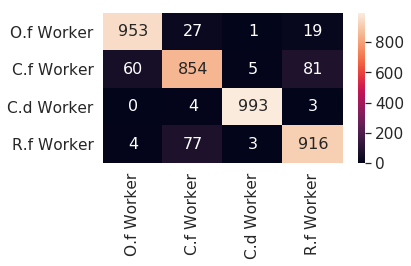


[84] accuracy: 0.937 loss: 16.519

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067112088,

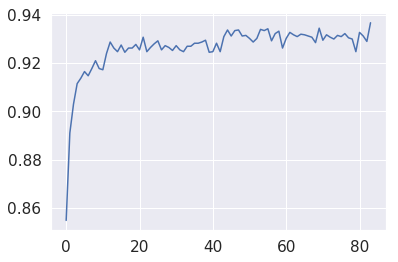

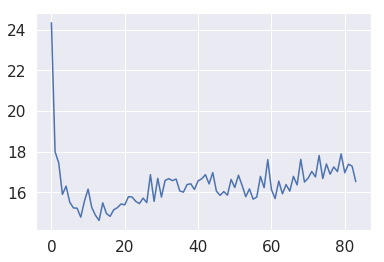

[0, 1, 0, 1, 0, 1, 0, 0, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 1, 1, 0, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 0, 1, 0, 2, 1, 1, 3, 1, 1, 3, 1, 0, 3, 1, 3, 0, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 1, 1, 3, 0, 3, 0, 0, 3, 1, 2, 1, 0, 1, 1, 0, 3, 3, 3, 1, 3, 1, 0, 2, 3, 3, 0, 3, 2, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 0, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 1, 1, 3, 1, 0, 0, 2, 0, 1, 2, 3, 1, 1, 3, 2, 1, 1, 2, 1, 0, 3, 3, 0, 0, 1, 1, 3, 1, 3, 0, 3, 3, 1, 3, 1, 0, 0, 0, 0, 3, 3, 3, 1, 0, 1, 0, 0, 1, 3, 3, 0, 3, 3, 3, 2, 3, 0, 1, 1, 1, 0, 2, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 1, 3, 3, 1, 3, 1, 1, 2, 0, 3, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         957          24           0          19
C.f Worker          42         870          10          78
C.d Worker           0           1         994           5
R.f 

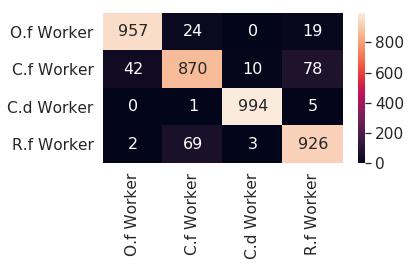


[85] accuracy: 0.932 loss: 17.650

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.865131067

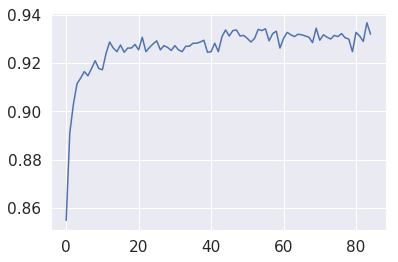

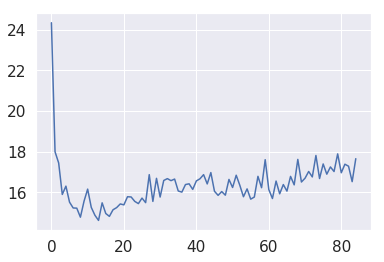

[0, 3, 3, 1, 1, 3, 1, 3, 1, 0, 1, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 3, 1, 0, 0, 0, 0, 1, 3, 3, 2, 1, 1, 1, 3, 0, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 0, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3, 1, 0, 3, 1, 1, 1, 2, 0, 0, 3, 3, 3, 3, 1, 0, 0, 0, 0, 1, 3, 1, 0, 0, 1, 3, 1, 1, 0, 1, 3, 1, 1, 3, 1, 0, 2, 3, 3, 3, 0, 3, 1, 1, 0, 3, 3, 2, 1, 1, 3, 1, 3, 3, 3, 0, 1, 0, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 1, 1, 0, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 0, 1, 3, 3, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 1, 3, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 3, 3, 2, 1, 0, 1, 0, 1, 3, 0, 1, 3, 3, 1, 2, 3, 3, 3, 0, 1, 3, 1, 0, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         965          18           0          17
C.f Worker          52         855           7          86
C.d Wo

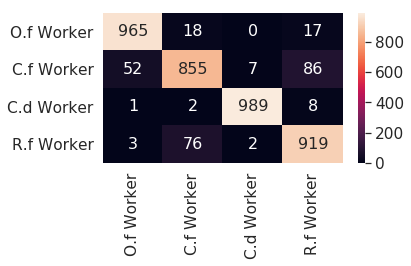


[86] accuracy: 0.931 loss: 16.682

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872044, 14.

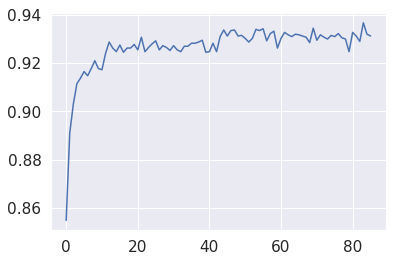

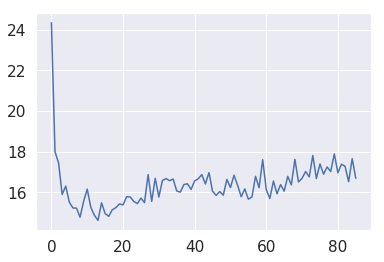

[1, 3, 1, 0, 1, 1, 1, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 0, 3, 3, 1, 0, 1, 0, 1, 3, 1, 1, 2, 1, 3, 3, 1, 1, 0, 3, 3, 0, 1, 1, 1, 1, 0, 3, 1, 0, 3, 1, 2, 1, 3, 0, 1, 2, 0, 1, 3, 0, 3, 1, 1, 3, 1, 0, 3, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 3, 1, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1, 0, 1, 0, 0, 3, 0, 1, 3, 0, 1, 1, 1, 1, 0, 1, 1, 0, 3, 2, 3, 1, 0, 1, 1, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 0, 2, 0, 1, 0, 3, 3, 1, 1, 3, 3, 3, 2, 3, 1, 0, 3, 3, 1, 0, 3, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 1, 3, 1, 0, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 3, 3, 0, 0, 3, 1, 3, 3, 1, 0, 1, 0, 1, 0, 1, 1, 3, 3, 1, 1, 1, 0, 3, 0, 1, 1, 0, 1, 3, 1, 3, 1, 3, 1, 0, 0, 3, 3, 1, 3, 3, 3, 1, 0, 3, 2, 1, 3, 3, 1, 1, 0, 3, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         968          18           0          14
C.f Worker          57         857           6          

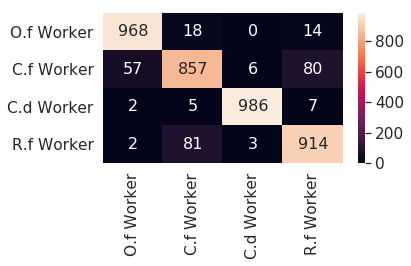


[87] accuracy: 0.926 loss: 17.397

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.250949896872

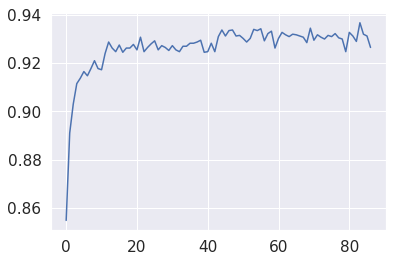

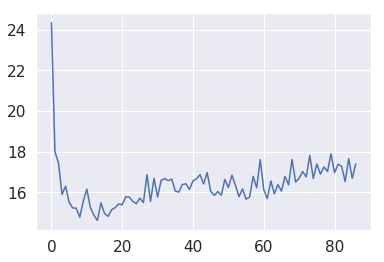

[1, 3, 3, 1, 3, 0, 1, 1, 0, 1, 1, 2, 3, 3, 1, 1, 0, 1, 3, 0, 3, 3, 0, 1, 0, 2, 1, 0, 3, 0, 1, 1, 2, 1, 3, 3, 2, 1, 1, 3, 1, 3, 1, 3, 3, 0, 1, 3, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 1, 1, 1, 0, 1, 1, 3, 3, 1, 0, 0, 0, 3, 1, 3, 0, 1, 1, 1, 2, 3, 1, 0, 3, 3, 0, 0, 1, 3, 3, 1, 3, 1, 2, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 0, 0, 1, 2, 0, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 0, 0, 2, 3, 0, 2, 3, 1, 1, 2, 1, 0, 1, 3, 2, 3, 3, 3, 1, 3, 0, 1, 3, 0, 3, 1, 0, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 1, 2, 1, 0, 3, 1, 3, 1, 0, 3, 3, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 3, 1, 1, 0, 0, 1, 3, 1, 3, 1, 0, 1, 0, 0, 1, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 1, 3, 0, 3, 2, 1, 0, 1, 0, 1, 2, 1, 3, 1, 0, 3, 3, 1, 2, 1, 2, 3, 2, 2, 0, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          21           1          18

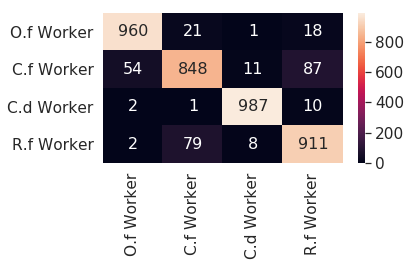


[88] accuracy: 0.928 loss: 17.011

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454, 15.25094

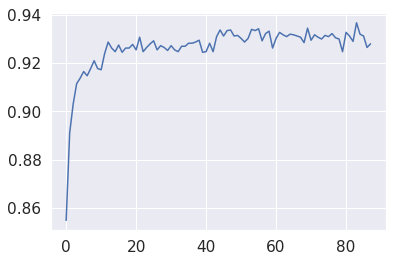

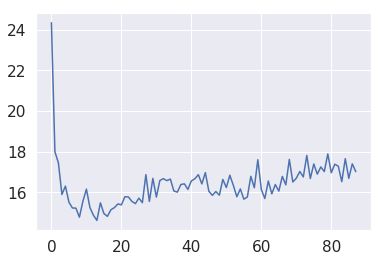

[3, 0, 0, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 2, 0, 3, 1, 3, 3, 0, 1, 1, 3, 0, 3, 1, 0, 2, 0, 1, 3, 0, 3, 0, 1, 0, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 1, 0, 1, 1, 3, 1, 1, 0, 0, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 0, 3, 2, 0, 1, 3, 3, 0, 3, 0, 1, 3, 1, 1, 1, 3, 1, 1, 3, 0, 1, 2, 3, 3, 0, 3, 3, 3, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 0, 3, 1, 1, 2, 1, 3, 0, 1, 3, 3, 3, 0, 3, 0, 3, 0, 1, 0, 1, 1, 1, 1, 1, 3, 3, 3, 1, 2, 0, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 2, 3, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 2, 0, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 3, 2, 3, 0, 3, 1, 0, 0, 1, 3, 3, 3, 1, 3, 1, 3, 2, 0, 3, 1, 0, 1, 0, 1, 3, 0, 1, 2, 3, 2, 0, 3, 0, 0, 3, 2, 3, 1, 0, 0, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          22           1          19
C.f Worker       

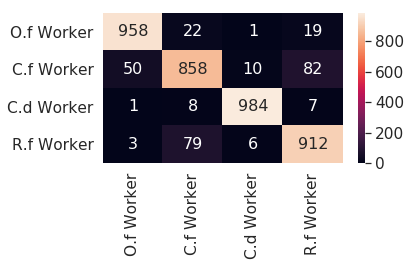


[89] accuracy: 0.932 loss: 16.544

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.150285582989454,

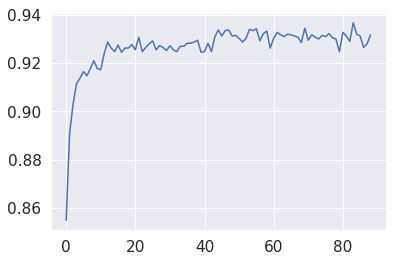

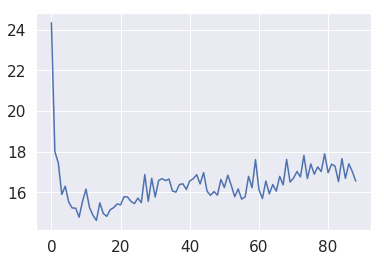

[3, 0, 3, 0, 3, 0, 0, 1, 1, 1, 3, 1, 1, 1, 3, 1, 2, 3, 3, 1, 3, 3, 0, 1, 1, 1, 3, 3, 0, 3, 3, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 1, 3, 3, 0, 3, 3, 2, 0, 0, 1, 3, 0, 3, 0, 0, 1, 3, 0, 0, 0, 3, 3, 3, 2, 0, 3, 3, 3, 3, 0, 0, 3, 0, 2, 1, 1, 3, 1, 0, 3, 0, 3, 1, 0, 1, 1, 0, 0, 3, 2, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 0, 1, 0, 1, 2, 1, 3, 1, 1, 1, 0, 3, 1, 3, 1, 3, 0, 1, 3, 1, 1, 0, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1, 3, 1, 3, 1, 0, 3, 0, 3, 3, 3, 0, 3, 0, 1, 1, 1, 0, 3, 0, 3, 3, 0, 0, 0, 1, 3, 1, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 0, 1, 2, 1, 0, 3, 1, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 0, 1, 1, 1, 0, 1, 1, 3, 3, 0, 0, 3, 0, 3, 1, 3, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 1, 3, 1, 3, 2, 0, 3, 0, 3, 0, 0, 3, 3, 0, 3, 1, 3, 1, 0, 3, 3, 0, 1, 3, 0, 0, 1, 1, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         965          17           0          18
C.f Worker          58         856           9          77
C.d

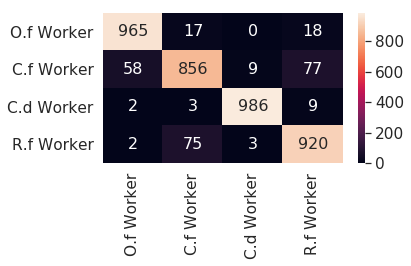


[90] accuracy: 0.932 loss: 16.612

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 16.1502855

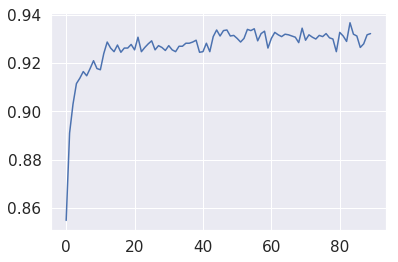

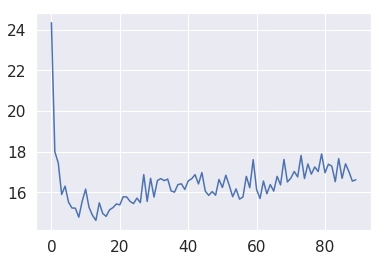

[1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 0, 3, 3, 1, 3, 3, 1, 1, 0, 3, 0, 3, 3, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 0, 3, 3, 1, 3, 2, 3, 1, 1, 1, 0, 3, 3, 3, 3, 0, 1, 1, 3, 1, 0, 0, 0, 3, 1, 1, 0, 3, 3, 1, 3, 0, 3, 1, 1, 0, 3, 1, 1, 1, 0, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 3, 1, 1, 3, 3, 1, 0, 0, 3, 3, 3, 1, 1, 0, 3, 2, 3, 1, 0, 3, 1, 3, 0, 2, 3, 3, 1, 0, 1, 3, 1, 1, 3, 0, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 0, 1, 3, 1, 0, 1, 1, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 0, 3, 1, 3, 3, 3, 0, 1, 1, 0, 3, 0, 3, 1, 1, 3, 1, 3, 2, 1, 0, 3, 3, 2, 1, 1, 3, 1, 1, 2, 0, 1, 1, 1, 0, 3, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 2, 0, 3, 1, 1, 1, 1, 3, 3, 1, 0, 2, 0, 0, 1, 1, 2, 1, 3, 2, 1, 0, 3, 3, 0, 1, 1, 3, 0, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 0, 0, 0, 2, 0, 1, 0, 0, 1, 3, 1, 1, 1, 3, 0, 1, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          21           0          21
C.f Worker          47         865          10          78
C.d Worke

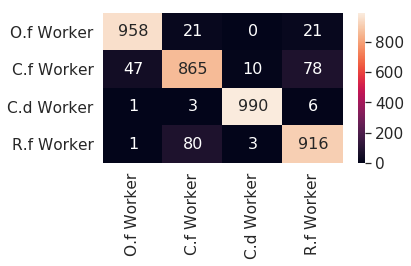


[91] accuracy: 0.931 loss: 17.508

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488163233, 1

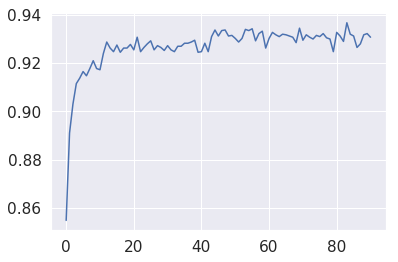

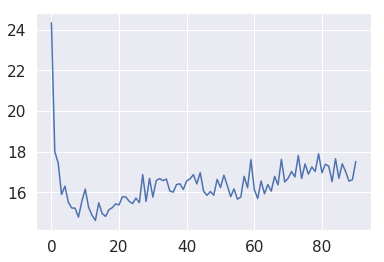

[3, 0, 3, 3, 1, 0, 1, 1, 3, 2, 3, 1, 1, 3, 0, 3, 3, 3, 0, 3, 1, 0, 3, 0, 1, 3, 1, 1, 3, 1, 0, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 0, 1, 0, 0, 3, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 3, 0, 1, 1, 1, 1, 3, 0, 0, 3, 3, 1, 2, 1, 2, 3, 0, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 0, 3, 1, 3, 3, 0, 0, 1, 3, 1, 1, 1, 0, 3, 0, 1, 3, 3, 1, 3, 1, 2, 2, 2, 1, 3, 1, 0, 3, 3, 0, 1, 0, 1, 3, 0, 0, 1, 1, 3, 1, 1, 0, 0, 3, 1, 2, 1, 3, 3, 3, 0, 0, 0, 3, 1, 3, 1, 3, 0, 0, 3, 0, 3, 3, 0, 1, 1, 3, 1, 1, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 1, 3, 0, 1, 0, 0, 1, 2, 1, 3, 0, 3, 3, 3, 0, 0, 1, 1, 1, 0, 3, 0, 1, 0, 0, 1, 1, 1, 3, 3, 3, 3, 0, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 3, 3, 1, 0, 0, 3, 1, 3, 1, 1, 0, 1, 3, 1, 0, 0, 1, 3, 3, 0, 1, 1, 3, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 3, 3, 3, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         955          25           0          20
C.f Worker          57         863           7    

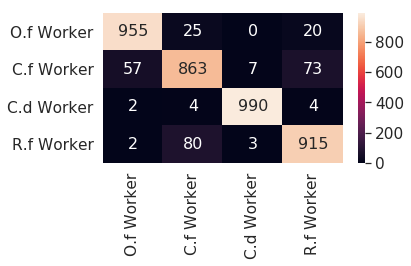


[92] accuracy: 0.933 loss: 16.930

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.553530488

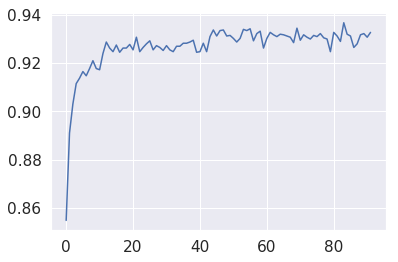

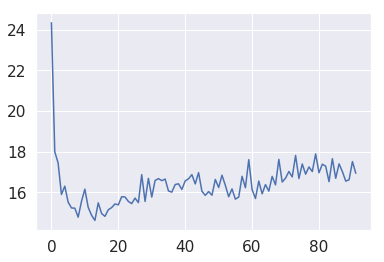

[3, 1, 1, 3, 1, 1, 1, 1, 3, 2, 3, 3, 2, 3, 3, 3, 0, 0, 1, 1, 3, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 2, 3, 0, 0, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 0, 0, 1, 3, 3, 2, 3, 0, 0, 3, 1, 3, 1, 0, 0, 1, 3, 3, 3, 1, 0, 3, 3, 0, 2, 3, 0, 2, 3, 0, 3, 0, 3, 3, 3, 3, 1, 0, 1, 1, 3, 1, 0, 0, 1, 1, 1, 0, 3, 1, 0, 0, 0, 2, 3, 1, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1, 3, 1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 0, 1, 1, 3, 3, 0, 1, 0, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1, 1, 1, 0, 2, 3, 1, 3, 0, 3, 1, 3, 3, 1, 1, 3, 1, 1, 0, 3, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 1, 0, 1, 1, 3, 2, 0, 3, 1, 1, 1, 3, 1, 1, 2, 0, 3, 1, 1, 1, 0, 1, 1, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          27           0          13
C.f Worker          46         859          11          84
C.d Worker     

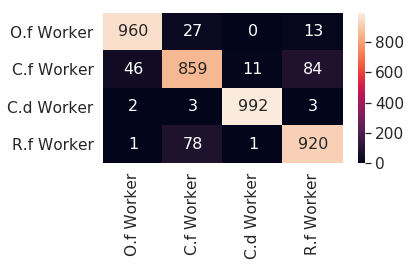


[93] accuracy: 0.932 loss: 16.750

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.768616177141666, 15.

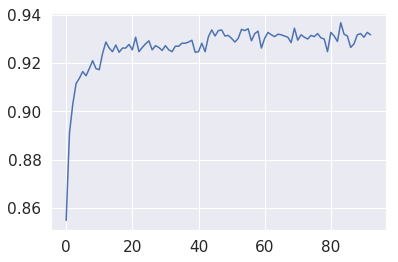

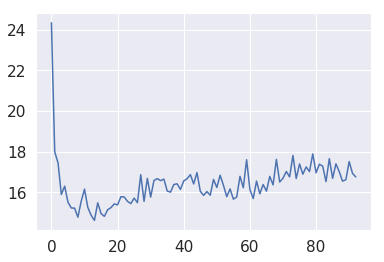

[0, 3, 1, 3, 0, 3, 0, 0, 3, 0, 0, 1, 1, 1, 1, 0, 1, 3, 1, 1, 3, 1, 0, 1, 1, 1, 3, 3, 1, 3, 1, 0, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 0, 2, 1, 3, 3, 1, 1, 0, 3, 0, 1, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 1, 0, 1, 1, 3, 0, 0, 3, 3, 2, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 3, 1, 2, 1, 1, 3, 3, 3, 1, 1, 0, 3, 1, 2, 0, 1, 3, 3, 1, 1, 0, 0, 1, 3, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 3, 0, 3, 1, 0, 3, 3, 0, 1, 1, 0, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 1, 1, 0, 0, 3, 1, 0, 3, 1, 0, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 0, 3, 3, 1, 2, 1, 3, 1, 1, 1, 3, 3, 3, 2, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 2, 0, 3, 2, 3, 0, 2, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          24           1          17
C.f Worker          52         861           9          78
C.d

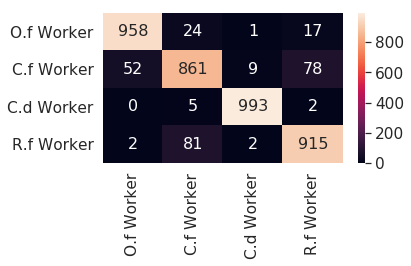


[94] accuracy: 0.931 loss: 17.956

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175, 0.93075]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.76861617714

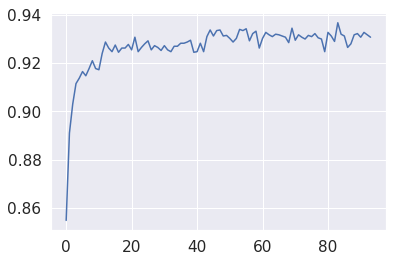

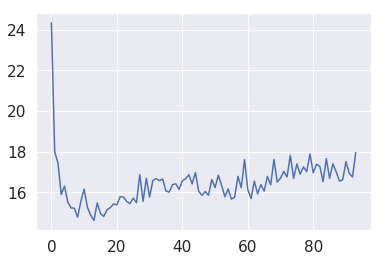

[3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 0, 3, 0, 1, 1, 1, 1, 3, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 3, 1, 1, 0, 2, 3, 2, 1, 1, 3, 1, 0, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 0, 1, 1, 0, 3, 1, 1, 0, 3, 3, 3, 3, 1, 0, 0, 3, 1, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 3, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 3, 0, 3, 1, 2, 0, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 3, 1, 1, 2, 3, 3, 2, 3, 1, 0, 0, 0, 3, 1, 3, 1, 0, 0, 1, 3, 3, 3, 0, 1, 1, 1, 1, 3, 0, 3, 1, 1, 0, 0, 0, 3, 1, 3, 0, 1, 0, 0, 1, 1, 0, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 1, 1, 0, 1, 1, 0, 1, 3, 3, 2, 3, 1, 1, 1, 1, 3, 0, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 0, 2, 3, 3, 1, 2, 1, 3, 0, 0, 3, 0, 1, 1, 0, 3, 3, 3, 1, 3, 1, 0, 1, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         962          22           0          16
C.f Worker          55         860           7    

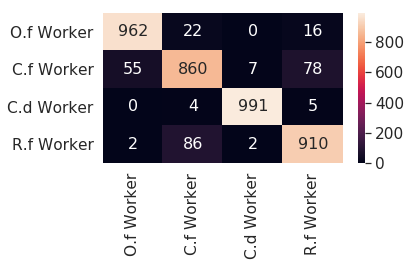


[95] accuracy: 0.931 loss: 17.936

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175, 0.93075, 0.93125]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.212880373001099, 14.76

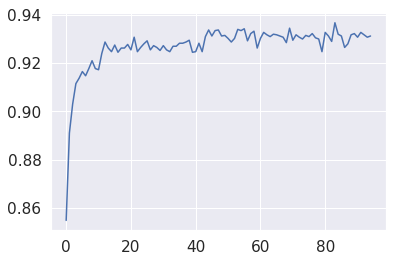

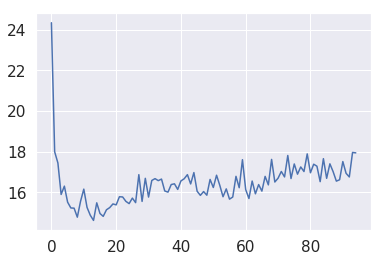

[1, 0, 3, 2, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 0, 1, 1, 1, 0, 1, 3, 0, 3, 1, 3, 3, 0, 0, 1, 1, 1, 1, 1, 1, 0, 3, 1, 0, 3, 1, 3, 2, 1, 2, 0, 3, 0, 1, 2, 2, 3, 3, 1, 1, 0, 1, 1, 3, 1, 0, 0, 0, 0, 1, 3, 1, 0, 3, 2, 0, 1, 3, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 0, 1, 0, 1, 1, 3, 3, 1, 0, 1, 3, 0, 1, 0, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 0, 1, 1, 0, 3, 1, 1, 0, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 1, 2, 3, 1, 3, 3, 1, 3, 0, 1, 0, 0, 2, 0, 3, 1, 0, 1, 3, 3, 3, 0, 0, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 0, 0, 3, 2, 3, 2, 1, 1, 3, 0, 3, 3, 3, 0, 0, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 3, 2, 3, 2, 1, 0, 1, 0, 0, 1, 1, 1, 3, 0, 3, 3, 0, 3, 1, 0, 1, 3, 1, 0, 1, 1, 2, 3, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         961          22           0          17
C.f Worker          53         861          10          

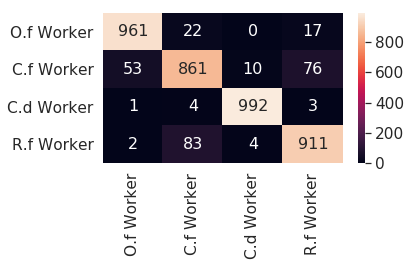


[96] accuracy: 0.931 loss: 17.143

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175, 0.93075, 0.93125, 0.93075]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.2128803730010

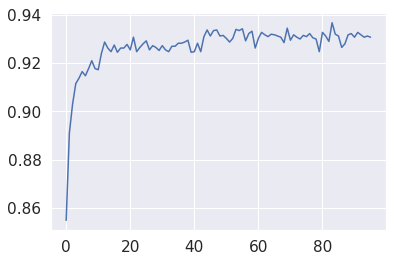

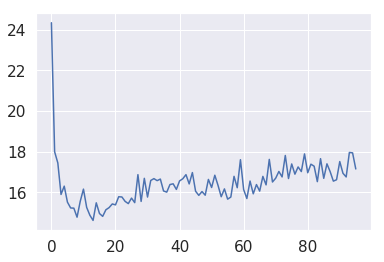

[1, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 3, 0, 0, 3, 1, 1, 0, 1, 1, 1, 1, 3, 0, 3, 3, 1, 1, 3, 1, 0, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 0, 1, 3, 3, 1, 2, 1, 3, 3, 3, 1, 3, 1, 1, 1, 0, 0, 0, 0, 1, 1, 3, 3, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 0, 0, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 1, 1, 3, 0, 1, 3, 3, 2, 3, 1, 0, 3, 3, 1, 0, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 0, 3, 0, 0, 0, 3, 1, 1, 3, 1, 0, 3, 0, 3, 3, 3, 3, 1, 1, 0, 3, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3, 1, 0, 3, 3, 1, 0, 3, 1, 0, 0, 2, 0, 1, 1, 3, 0, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 0, 1, 1, 1, 3, 1, 0, 3, 1, 1, 0, 1, 1, 3, 1, 1, 0, 1, 3, 1, 3, 3, 3, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 1, 3, 1, 3, 1, 3, 2, 1, 0, 0, 0, 2, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         960          21           0          19
C.f Worker          51         866           8    

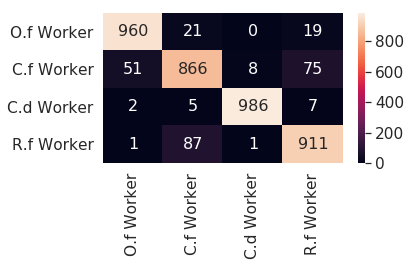


[97] accuracy: 0.932 loss: 16.796

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175, 0.93075, 0.93125, 0.93075, 0.93175]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913, 15.2128

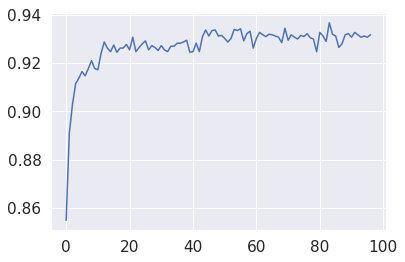

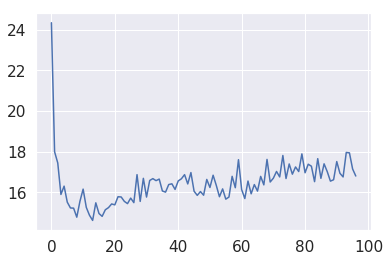

[3, 3, 3, 3, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 1, 2, 0, 3, 1, 0, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 1, 1, 1, 3, 3, 3, 0, 3, 0, 3, 3, 2, 0, 3, 3, 1, 3, 0, 3, 0, 3, 3, 1, 1, 1, 3, 3, 0, 3, 1, 0, 0, 3, 1, 1, 0, 0, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 3, 1, 1, 3, 0, 3, 1, 1, 0, 3, 3, 1, 3, 1, 1, 3, 3, 3, 0, 0, 0, 0, 1, 1, 0, 0, 1, 3, 3, 2, 0, 1, 0, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 0, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 0, 1, 3, 1, 1, 1, 0, 3, 1, 3, 2, 1, 0, 0, 1, 0, 0, 3, 1, 3, 2, 3, 1, 1, 1, 1, 3, 3, 3, 0, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 0, 3, 1, 3, 1, 3, 3, 1, 1, 3, 0, 3, 3, 1, 1, 0, 3, 3, 3, 0, 1, 1, 1, 1, 3, 0, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 3, 3, 0, 2, 3, 1, 3, 3, 0, 0, 2, 0, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 2, 1, 3, 3, 1, 0, 3, 2, 0, 1, 0, 3, 1, 3, 0, 3, 3, 1, 1, 1, 0, 2, 1, 0, 0, 1, 3, 3, 1, 3, 1, 3]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          23           0          19
C.f Worker          53         863           4          80
C.d

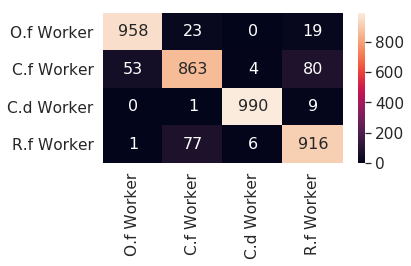


[98] accuracy: 0.929 loss: 17.828

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175, 0.93075, 0.93125, 0.93075, 0.93175, 0.9295]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.222898811101913,

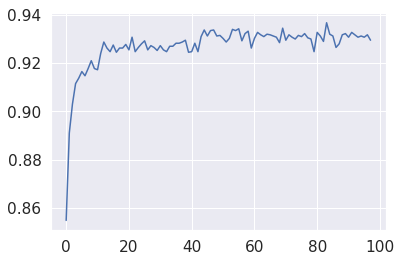

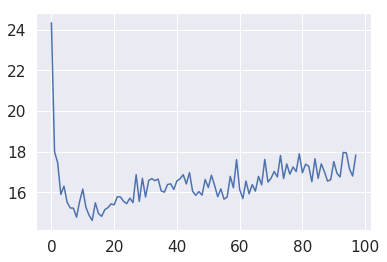

[1, 1, 3, 1, 3, 1, 1, 0, 1, 3, 0, 3, 0, 3, 2, 2, 0, 0, 1, 3, 0, 1, 3, 3, 1, 3, 3, 3, 0, 1, 3, 1, 3, 0, 3, 1, 2, 3, 3, 1, 3, 2, 0, 0, 3, 0, 3, 1, 2, 1, 0, 1, 1, 1, 1, 0, 3, 0, 0, 0, 3, 1, 0, 0, 0, 3, 1, 3, 0, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 1, 3, 3, 2, 2, 0, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 3, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 0, 1, 3, 3, 1, 0, 0, 3, 1, 1, 1, 3, 3, 0, 1, 1, 0, 3, 0, 2, 1, 2, 2, 0, 0, 3, 3, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 0, 1, 3, 3, 3, 1, 1, 3, 0, 1, 3, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 3, 0, 1, 1, 1, 3, 0, 3, 1, 3, 1, 3, 1, 1, 1, 0, 3, 0, 3, 1, 1, 3, 3, 3, 1, 2, 3, 3, 0, 1, 2, 0, 1]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          21           1          20
C.f Worker          52         860 

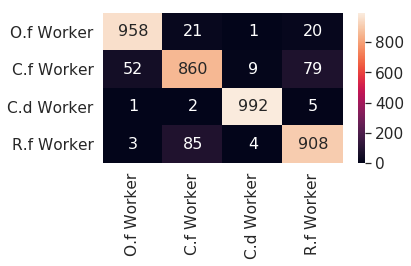


[99] accuracy: 0.930 loss: 17.466

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175, 0.93075, 0.93125, 0.93075, 0.93175, 0.9295, 0.92975]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 15.2228988

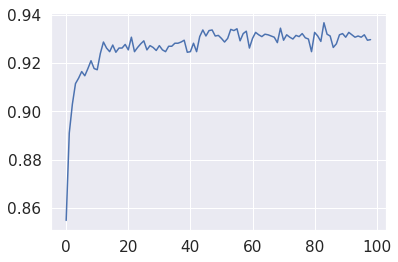

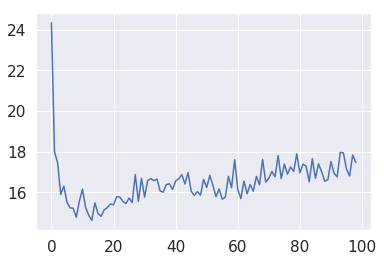

[1, 0, 1, 1, 0, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 0, 3, 3, 1, 2, 3, 3, 3, 3, 0, 1, 1, 0, 1, 0, 3, 0, 1, 0, 3, 1, 2, 1, 1, 1, 3, 3, 0, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 1, 3, 1, 3, 0, 1, 1, 1, 0, 3, 1, 3, 0, 3, 3, 3, 0, 1, 0, 3, 1, 3, 1, 0, 0, 1, 2, 3, 0, 0, 3, 3, 3, 3, 3, 3, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 3, 0, 3, 3, 3, 0, 1, 1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 3, 3, 0, 1, 3, 0, 1, 0, 3, 3, 1, 3, 0, 1, 3, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 0, 2, 2, 3, 1, 3, 0, 0, 3, 3, 1, 3, 3, 0, 1, 0, 3, 1, 1, 1, 1, 0, 3, 1, 0, 1, 0, 1, 1, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 1, 3, 3, 1, 3, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 0, 0, 3, 3, 3, 3, 1, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         958          23           2          17
C.f Worker          54         855    

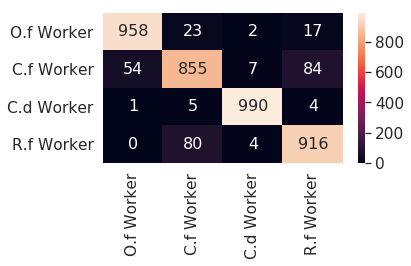


[100] accuracy: 0.930 loss: 17.299

[0.85475, 0.891, 0.903, 0.9115, 0.91375, 0.9165, 0.91475, 0.91775, 0.921, 0.91775, 0.91725, 0.924, 0.92875, 0.92625, 0.92475, 0.9275, 0.9245, 0.92625, 0.92625, 0.92775, 0.9255, 0.93075, 0.92475, 0.9265, 0.928, 0.92925, 0.9255, 0.92725, 0.9265, 0.92525, 0.92725, 0.9255, 0.92475, 0.927, 0.927, 0.92825, 0.92825, 0.92875, 0.9295, 0.9245, 0.92475, 0.92825, 0.92475, 0.931, 0.93375, 0.93125, 0.9335, 0.93375, 0.93125, 0.9315, 0.93025, 0.92875, 0.93025, 0.934, 0.9335, 0.93425, 0.92925, 0.93225, 0.93325, 0.92625, 0.93025, 0.93275, 0.93175, 0.931, 0.932, 0.93175, 0.93125, 0.93075, 0.9285, 0.9345, 0.9295, 0.93175, 0.93075, 0.93, 0.9315, 0.931, 0.93225, 0.9305, 0.93, 0.92475, 0.93275, 0.93125, 0.929, 0.93675, 0.932, 0.93125, 0.9265, 0.928, 0.93175, 0.93225, 0.93075, 0.93275, 0.93175, 0.93075, 0.93125, 0.93075, 0.93175, 0.9295, 0.92975, 0.93025]
[24.343521431088448, 17.989721469581127, 17.4379405900836, 15.887787975370884, 16.297419518232346, 15.508951976895332, 

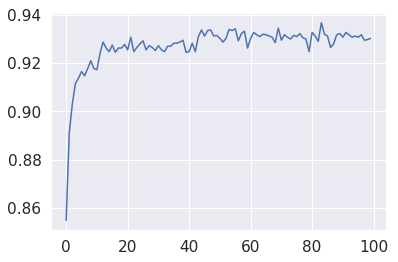

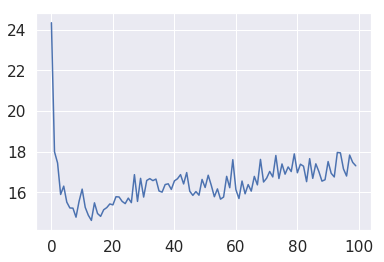

[3, 1, 2, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 0, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 1, 3, 1, 3, 3, 2, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 1, 0, 1, 1, 0, 0, 3, 0, 0, 2, 1, 3, 1, 1, 0, 3, 3, 1, 3, 0, 1, 2, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 0, 1, 2, 2, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 0, 0, 1, 3, 0, 0, 3, 1, 1, 1, 0, 0, 3, 1, 1, 3, 3, 3, 3, 0, 0, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 0, 3, 0, 1, 0, 0, 3, 3, 3, 2, 1, 3, 2, 3, 2, 1, 0, 1, 1, 0, 0, 2, 1, 3, 3, 1, 3, 1, 3, 0, 1, 0, 1, 0, 1, 3, 0, 3, 3, 1, 2, 0, 3, 0, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 1, 0, 0, 1, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 0, 0, 1, 0, 3, 3, 1, 3, 1, 1, 3, 1, 1, 0]
            O.f Worker  C.f Worker  C.d Worker  R.f Worker
O.f Worker         961          20           0          19
C.f Worker          46         855          

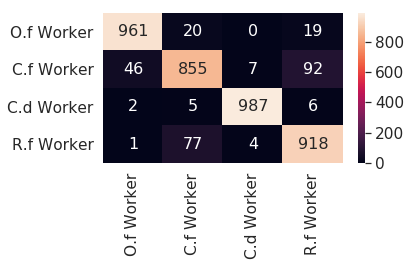

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
test_acc = []
test_loss = []
# classes2 = ["O. formosanus Worker","C. formosanus Worker", "C. domesticus Worker", "R. flaviceps Worker"]
for model_num in range(1, EPOCH+1):
    wrong_images = []
    wrong_answer = []
    actual_answer = []
    weight_path = model_directory + "%03d_weights.pt" % (model_num)
    state_dict = torch.load(weight_path)
    model.load_state_dict(state_dict)
    running_loss = 0.0
    total = 0
    correct = 0
    confusion_matrix = torch.zeros(len(classes), len(classes))
    for step, (labels, images, paths) in enumerate(testloader):
        optimizer.zero_grad()
        images = images.detach().cuda()
        labels = labels.detach().cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # append to the wrong list (test log file)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
#                 print(paths[i], predicted[i], labels[i])
                wrong_images.append(paths[i])
                wrong_answer.append(predicted[i].item())
                actual_answer.append(labels[i].item())
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
#             print(t.item(), p.item())
#             mapp = { 1: 0,
#                     3: 1,
#                     5: 2,
#                     6: 3}
#             confusion_matrix[mapp[t.item()], mapp[p.item()]] += 1
            confusion_matrix[t.item(), p.item()] += 1
    
    running_acc = correct / total
    print('\n[%d] accuracy: %.3f loss: %.3f\n' % (model_num, running_acc, running_loss))
    
    test_acc.append(running_acc)
    test_loss.append(running_loss)
    print(test_acc)
    print(test_loss)
    plt.figure()
    plt.plot(range(0,model_num), test_acc)
    plt.savefig(test_directory + "test_acc_E%03d.jpg" % (model_num), dpi=500)
    plt.show()
    plt.figure()
    plt.plot(range(0,model_num), test_loss)
    plt.savefig(test_directory + "test_loss_E%03d.jpg" % (model_num), dpi=500)
    plt.show()
    
    
    print(wrong_answer)
    with open(test_directory + "%03d_wrong.txt" % (model_num), 'w') as wrong:
#         c = zip(wrong_images, wrong_answer, actual_answer)
#         c = sorted(c)
#         (wrong_images, wrong_answer, actual_answer) = zip(*c)
#         print(wrong_images)
        for i in range(len(wrong_images)):
            wrong.write(wrong_images[i] + " " + classes[wrong_answer[i]] + " " + classes[actual_answer[i]])
#             print(wrong_images[i] + " " + classes[wrong_answer[i]] + " " + classes[actual_answer[i]])
            wrong.write("\n")
        wrong.close()
#     print(confusion_matrix)
    confusion_matrix = confusion_matrix.numpy().astype(int)
#     print(confusion_matrix)
    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in classes],
                  columns = [i for i in classes])
    print(df_cm)
    sn.set(font_scale=1.4)#for label size
#     print(classes)
    img = sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt="d")
    figure = img.get_figure()
    plt.tight_layout()
    plt.savefig(test_directory + "confusion_matrix_%03d.jpg" % (model_num), dpi=500)
    plt.show()
    


In [27]:
resultfile = open(model_directory+"test_results.txt", "a")
resultfile.write("test")
resultfile.write("\n")
resultfile.write(str(test_acc))
resultfile.write("\n")
resultfile.write(str(test_loss))
resultfile.write("\n")
resultfile.close()
